In [1]:
# check installed version
import pycaret 
pycaret.__version__
    
# import pandas module
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import subprocess
import json
from datetime import date
from pycaret.regression import *
import os
    
def run_pipeline(source_filename, period_start, period_end):

    
    # global variables
    Soil_humi = []
    Resistance = []
    Soil_temp = []
    total_amount = 0
    rolling_mean_window_data = 15
    rolling_mean_window_grouped = 5
    min_length_df = 300 #was 50
    slope_irrigation = -0.07
    tension_threshold = 7
    sample_rate = 60 #in min
    #source_filename = "binned_removed_new.csv"
    
    # creating a data frame
    data = pd.read_csv(source_filename, header=0)
    data.head()
    
    # create array with sensors strings
    for col in data.columns:
        if re.findall(r"SoilHumiditySensor$", col):
            Soil_humi.append(col)
        elif re.findall(r"\/ $", col):
            Resistance.append(col)
        elif re.findall(r"SoilThermometer$", col):
            Soil_temp.append(col)
    
    # print them to check
    for i in range(len(Soil_humi)):
        total_amount += 1
        print(Soil_humi[i])
    for i in range(len(Resistance)):
        total_amount += 1
        print(Resistance[i])
    for i in range(len(Soil_temp)):
        total_amount += 1
        print(Soil_temp[i])
        
    print("Total amount of values: ", total_amount)
    
    # Show if there are any missing values inside the data
    data.isna().any()
    
    data['Time'] = data['Time'].str[:-9]
    data['Time']=pd.to_datetime(data['Time'])
    data = data.set_index('Time')
    
    data = data.loc['2023-03-24 22:00:00':] # for binned_removed_new
    #data = data.loc['2023-03-24 22:00:00':'2023-09-15 23:50:00'] # for binned_removed-2024
    data = data.loc[period_start:period_end]
    
    
    
    #data = data.fillna(method = 'bfill')
    data = data.interpolate(method='linear')
    data.plot(subplots=True, figsize=(20,50))
    
    # resample using timespan of 30min -> hopefully reduces overfitting
    if sample_rate != 10:
        data_re = data.resample(str(sample_rate)+'T').mean()# median() ...was median
        data = data_re
    
    # creating a data frame
    data_weather = pd.read_csv("april_weather.csv", header=0, sep=";")
    data_weather.head()
    
    # Convert the datetime column to a datetime object
    data_weather['Heure'] = pd.to_datetime(data_weather['Heure'], format=' %d/%m/%Y %H:%M:%S')#, errors='coerce')
    #print("After datetime, before ISO:  \n", data_weather, "\n", data_weather.dtypes, "\n")
    
    # Format the datetime object as an ISO time string
    data_weather['Heure'] = data_weather['Heure'].dt.strftime('%Y-%m-%dT%H:%M:%S')
    
    #change name
    data_weather = data_weather.rename(columns={'Heure':'Time'})
    
    # change datatype
    data_weather['Time'] = pd.to_datetime(data_weather['Time'])
    
    # set the index of the DataFrame to the timestamp column
    data_weather = data_weather.set_index('Time')
    
    # Drop useless
    data_weather = data_weather.drop(['Température intérieure(°C)', 'Humidité intérieure(%)', 'Intervalle', 'NO.', 'Pression relative(hpa)', 'Rafale(km/h)', 'Point de rosée(°C)', 'UVI'], axis=1)#, 'Précipitations dernière heure(mm)', 'Précipitations de la semaine(mm)', 'Précipitations du mois(mm)', 'Précipitations totales(mm)'], axis=1)
    
    # Convert wind direction to integer
    directions = [" N", " NNE", " NE", " ENE", " E", " ESE", " SE", " SSE", " S", " SSW", " SW", " WSW", " W", " WNW", " NW", " NNW"]
    target_col = 'Direction du vent'
    
    for index, value in data_weather[target_col].iteritems():
        # Calculate wind direction in degrees -> TODO : convert to int and round
        if value == " ---":
            data_weather[target_col][index] = np.nan
        else:
            data_weather[target_col][index] = directions.index(value) * 22.5
            
    data_weather[target_col] = data_weather[target_col].astype("float64")
    
    # convert to float64
    def convert_cols(data,ref_dtype):
        obj_dtype = 'object'
        
        for col in data.columns:
            if data[col].dtype == obj_dtype:
                data[col] = pd.to_numeric(data[col], errors='coerce')
            print("This is :",col, "it has the following dtype: ", data[col].dtype)
    
    convert_cols(data_weather, 'float64')
    
    # preserve old datetimeindex
    timestamps = data_weather.index
    data_weather.reset_index(drop=True)

    
    # Init the transformer
    reg_imp = IterativeImputer(estimator=Ridge())
    
    # Fit/transform
    data_weather = pd.DataFrame(reg_imp.fit_transform(data_weather), columns=data_weather.columns)
    
    # restore old index
    data_weather['Time'] = timestamps
    data_weather = data_weather.set_index('Time')
    data_weather.index = pd.to_datetime(data_weather.index)
    
    #ref_dtype = 'float64'
    # iterate through the columns and compare their data types to the reference data type
    #for col in data_weather.columns:
    #    print("This is :",col)
    #    if data_weather[col].dtype == 'datetime64[ns]':
    #        data_weather[col] = data_weather[col].resample('10T').ffill()
    #    if data_weather[col].dtype == ref_dtype:
    #        data_weather[col] = data_weather[col].resample('10T').mean()
    #    else:
    #        data_weather[col] = data_weather[col].resample('10T').ffill()
    
    data_weather.head()
    
    data_weather_re = data_weather.resample('10T').fillna(method = 'bfill') #TODO: fill with mean!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    data_weather_re.index
    
    data_weather_re.head(10)
    
    lattitude, longitude = 35.222866, 9.090245
    start_date, end_date = data.index[0].strftime("%Y-%m-%d"), data.index[-1].strftime("%Y-%m-%d")
    today = date.today()
    
    def get_historical_weather_api(lattitude, longitude, start_date, end_date):
        dct = subprocess.check_output(['curl', f'https://archive-api.open-meteo.com/v1/era5?latitude={lattitude}&longitude={longitude}&start_date={start_date}&end_date={today.strftime("%Y-%m-%d")}&hourly=temperature_2m,relativehumidity_2m,rain,cloudcover,shortwave_radiation,windspeed_10m,winddirection_10m,soil_temperature_7_to_28cm,soil_moisture_0_to_7cm,et0_fao_evapotranspiration']).decode()
        dct = json.loads(dct)
        # I also convert it to a pandas dataframe
        
        data = (pd.DataFrame([dct['hourly']['temperature_2m'], 
                              dct['hourly']['relativehumidity_2m'], 
                              dct['hourly']['rain'], 
                              dct['hourly']['cloudcover'], 
                              dct['hourly']['shortwave_radiation'],
                              dct['hourly']['windspeed_10m'], 
                              dct['hourly']['winddirection_10m'], # not important
                              dct['hourly']['soil_temperature_7_to_28cm'], 
                              dct['hourly']['soil_moisture_0_to_7cm'], 
                              dct['hourly']['et0_fao_evapotranspiration'],
                              dct['hourly']['time']], 
                             index = ['Temperature', 'Humidity', 'Rain', 'Cloudcover', 'Shortwave_Radiation', 'Windspeed', 'Winddirection', 'Soil_temperature_7-28', 'Soil_moisture_0-7', 'Et0_evapotranspiration', 'date'])
                .T
                .assign(date = lambda x : pd.to_datetime(x.date, format='%Y-%m-%dT%H:%M'))
                .set_index(['date']).dropna())
    
        return data
    
    data_weather_api = get_historical_weather_api(lattitude, longitude, start_date, end_date)
    
    data.index[-1].strftime("%Y-%m-%d")
    
    today.strftime("%y-%m-%d")
    
    data_weather_api.tail(20)
    
    convert_cols(data_weather_api, 'float64')
    
    # Fill is not as good as interpolate -> do not use -> TODO: resample according to sampling_rate
    
    data_weather_api = data_weather_api.resample(str(sample_rate)+'T')#.fillna(method = 'bfill') #TODO: fill with mean!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    # Convert cols datatype to float64
    
    
    # Interpolate missing values using linear interpolation
    data_weather_api = data_weather_api.interpolate(method='linear')
    data_weather_api.index
    
    data_weather_api.isna().any()
    
    # concatenate the DataFrames vertically
    #data_comb = pd.concat([data, data_weather_re], axis=0)
    data_comb = pd.merge(data, data_weather_api, left_index=True, right_index=True, how='outer')
    
    # Select the rows between two dates => cut dataframe
    start_date = '2023-03-24 22:00:00'#str(data_weather_re.index[0])
    end_date = str(data.index[-1])#str(data_weather_re.index[-1])
    data_comb_cut = data_comb.loc[start_date:end_date]
    
    data = data_comb_cut
    
    print("Dataframe starts at:", data.index[0], "and ends at:",data.index[-1])
    
    ref_dtype = 'float64'
    obj_dtype = 'object'
    
    for col in data.columns:
        if data[col].dtype == obj_dtype:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        #if data[col].dtype == ref_dtype:
            #data[col] = data[col].rolling(window=rolling_mean_window_data, win_type='gaussian').mean(std=rolling_mean_window_data)
            
        print("This is :",col, "it has the following dtype: ", data[col].dtype)
    
    def compare_dataframes(df1, df2):
        # Verify column names
        if not set(df1.columns) == set(df2.columns):
            print("Column names are not the same in both dataframes.")
            return
    
        # Find the common columns between the two dataframes
        common_columns = df1.columns.intersection(df2.columns)
    
        # Compare the available values in the common columns
        for column in common_columns:
            values1 = df1[column].dropna()
            values2 = df2[column].dropna()
    
            min_length = min(len(values1), len(values2))
            values1 = values1[:min_length]
            values2 = values2[:min_length]
    
            diff = np.abs(values1.values - values2.values)
            mae = np.mean(diff)
            rmse = np.sqrt(np.mean(diff ** 2))
            mpe = np.mean(diff / values1.values) * 100
    
            print(f"Column: {column}")
            print(f"MAE: {mae:.2f}")
            print(f"RMSE: {rmse:.2f}")
            print(f"MPE: {mpe:.2f}%")
            print("df1 len:",len(values1),"df2 len:",len(values2))
            print()
    
    #compare_dataframes(data, data_imp)
    
    # create average cols
    data['grouped_soil'] = data[Soil_humi].mean(axis=1)
    data['grouped_resistance'] = data[Resistance].mean(axis=1)
    data['grouped_soil_temp'] = data[Soil_temp].mean(axis=1)
    
    data.index.dtype
    
    ## Create Features
    ## create rolling mean: introduces NaN again -> later just cut off
    data['rolling_mean_grouped_soil'] = data['grouped_soil'].rolling(window=rolling_mean_window_grouped, win_type='gaussian').mean(std=rolling_mean_window_grouped)
    data['rolling_mean_grouped_soil_temp'] = data['grouped_soil_temp'].rolling(window=rolling_mean_window_grouped, win_type='gaussian').mean(std=rolling_mean_window_grouped)
    
    data['hour'] = data.index.hour#.astype("float64")
    data['minute'] = data.index.minute#.astype("float64")
    data['date'] = data.index.day#.astype("float64")
    data['month'] = data.index.month#.astype("float64")
    data['day_of_year'] = data.index.dayofyear#.astype("float64")
    
    # soil-water retention curve for sandy clay
    soil_water_retention_curve = [
        (0, 0.45),
        (5, 0.40),
        (10, 0.37),
        (20, 0.30),
        (50, 0.25),
        (100, 0.20),
        (200, 0.15),
        (500, 0.10),
        (1000, 0.05),               
    ]
    # this is basically made up to match the weather apis values
    soil_water_retention_curve2 = [
        (0, 0.225),
        (5, 0.2),
        (10, 0.185),
        (20, 0.15),
        (50, 0.125),
        (100, 0.1),
        (200, 0.075),
        (500, 0.05),
        (1000, 0.025),               
    ]
    
    def soil_tension_to_volumetric_water_content_log(soil_tension, soil_water_retention_curve):
        # Transform the tension and content values to logarithmic space
        tensions_log = np.log10([point[0] for point in soil_water_retention_curve])
        content_log = np.log10([point[1] for point in soil_water_retention_curve])
    
        # Interpolate in logarithmic space
        interpolated_content_log = np.interp(np.log10(soil_tension), tensions_log, content_log)
    
        # Transform back to linear space
        interpolated_content = 10 ** interpolated_content_log
        
        return interpolated_content
    
    def soil_tension_to_volumetric_water_content(soil_tension, soil_water_retention_curve):
        """
        Convert soil tension (kPa) to volumetric water content (fraction) using a given soil-water retention curve.
        
        Parameters:
            soil_tension (float): Soil tension value in kPa.
            soil_water_retention_curve (list of tuples): A list of tuples containing points on the soil-water retention curve.
                Each tuple contains two elements: (soil_tension_value, volumetric_water_content_value).
        
        Returns:
            float: Volumetric water content as a fraction (between 0 and 1).
        """
        # Extract tension and water content values from the curve
        tensions, water_contents = zip(*soil_water_retention_curve)
        
        # Use polynomial interpolation to fit a quadratic curve
        coefficients = np.polyfit(tensions, water_contents, 2)
        
        # Evaluate the polynomial at the given soil tension
        interpolated_water_content = np.polyval(coefficients, soil_tension)
        
        # Clip the result to ensure it remains within the valid range [0, 1]
        return np.clip(interpolated_water_content, 0, 1)
    
    def add_volumetric_col_to_df(df, col_name, soil_water_retention_curve):
        # Iterate over the rows of the dataframe and calculate volumetric water content
        for index, row in df.iterrows():
            soil_tension = row[col_name]
            # Calculate volumetric water content
            volumetric_water_content = soil_tension_to_volumetric_water_content_log(soil_tension, soil_water_retention_curve)
            # Assign the calculated value to a new column in the dataframe
            df.at[index, col_name + '_vol'] = round(volumetric_water_content, 4)
    
        return df
    
    data = add_volumetric_col_to_df(data, 'rolling_mean_grouped_soil', soil_water_retention_curve2)
    
    # Create a DataFrame to test interpolation method
    testframe = pd.DataFrame({'Column1': range(0, 201, 10)})
    testframe = add_volumetric_col_to_df(testframe, 'Column1', soil_water_retention_curve2)
    testframe.head(100)
    
    # Check calculated values against expected values for specific points
    i = 0
    for point in soil_water_retention_curve2:
        calculated_value = round(soil_tension_to_volumetric_water_content_log(point[0], soil_water_retention_curve2), 4)
        print(f"Point: {point}, Expected: {soil_water_retention_curve2[i][1]}, Calculated: {calculated_value}")
        i = i + 1
    
    soil_water_retention_curve2_df = pd.DataFrame(soil_water_retention_curve2)
    soil_water_retention_curve2_df.head()
    
    column_names = soil_water_retention_curve2_df.columns
    
    # Print or display the column names
    print(column_names)
    
    soil_water_retention_curve2_df = soil_water_retention_curve2_df.set_index(0)
    
    soil_water_retention_curve2_df.head()
    
    ax = soil_water_retention_curve2_df.plot(figsize = (20,10))
    
    # compare weatherdata from past against messured values more expressive:
    mean_recorded_sensor_values = data["rolling_mean_grouped_soil_vol"].mean()
    mean_open_meteo_past_vol = data_weather_api["Soil_moisture_0-7"].mean()
    factor = mean_open_meteo_past_vol / mean_recorded_sensor_values
    print("mean_recorded_sensor_values: ", mean_recorded_sensor_values, " mean_open_meteo_past_vol: ", mean_open_meteo_past_vol, " factor: ", factor)
    # Multiply the second column by factor
    modified_curve = [(x, y * factor) for x, y in soil_water_retention_curve2]
    
    # Display the modified list
    print(modified_curve)
    
    # do not use this approach, does not yield better results
    data = data.drop(columns=['rolling_mean_grouped_soil_vol'])
    #data = add_volumetric_col_to_df(data, 'rolling_mean_grouped_soil', modified_curve)
    
    # Min-Max Normalization
    def max_min_norm(df_all):
        df = df_all.drop(['rolling_mean_grouped_soil', 'hour', 'minute', 'date', 'month', 'day_of_year'], axis=1)
        index = df.index
        df_norm = pd.DataFrame()
        for col in df.columns:
            print("Current col: ", col)
            if df[col].dtype == ref_dtype:
                print("Normalize:   ", col, "Max value: ", df[col].max())
                df_norm[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min())
        df_norm = pd.concat([df_norm,  df_all.rolling_mean_grouped_soil, df_all['hour'], df_all['minute'], df_all['date'], df_all['month'], df_all['day_of_year']], 1)
        return df_norm
    
    #data = max_min_norm(data)
    
    print(str(Soil_temp).replace("[", "").replace("]", ""))
    
    #data = data[['Time', 'hour', 'minute', 'date', 'month', 'grouped_soil', 'grouped_resistance', 'grouped_soil_temp', 'rolling_mean_grouped_soil', 'rolling_mean_grouped_soil_temp', 
    #             str(Soil_humi).replace("[", "").replace("]", "").replace("\\",""),
    #             str(Resistance).replace("[", "").replace("]", "").replace("\\",""),
    #             str(Soil_temp).replace("[", "").replace("]", "").replace("\\","")
    #            ]]
    
    # drop those values without rolling_mean
    #data = data[rolling_mean_window_data+int(rolling_mean_window_grouped/2 + 0.5):]
    data = data[4:]
    data.head()
    
    # reset changed index(due to drop)
    #data = data.reset_index()
    
    #data = data.drop(['index'],axis=1)
    
    # Drop the first eight columns 
    #->better without raw values-> overfitting
    data = data.iloc[:, total_amount:]
    
    def hours_since_pump_was_turned_on(df):    
        # Find the index of rows where pump state is 1
        pump_on_indices = df[df['pump_state'] == 1].index
        
        # Initialize a new column with NaN values
        df['rows_since_last_pump_on'] = float('nan')
        
        # Iterate over pump_on_indices and update the new column
        for i in range(len(pump_on_indices)):
            if i == 0:
                # If it's the first occurrence, update with the total rows
                df.loc[:pump_on_indices[i], 'rows_since_last_pump_on'] = len(df)
            else:
                # Update with the difference in rows since the last occurrence
                df.loc[pump_on_indices[i - 1] + 1:pump_on_indices[i], 'rows_since_last_pump_on'] = \
                    pump_on_indices[i] - pump_on_indices[i - 1] - 1
        
        # Fill NaN values with 0 for rows where pump state is 1
        df['rows_since_last_pump_on'] = df['rows_since_last_pump_on'].fillna(0).astype(int)
        
        # Display the DataFrame
        print(df)
    
        return df
    

    # calculate slope of "rolling_mean_grouped_soil"
    f = data.rolling_mean_grouped_soil
    data['gradient'] = np.gradient(f)
    data['pump_state'] = int(0)
    #data.iloc[3270:3330]
    # also add hours since last irrigation
    #data = hours_since_pump_was_turned_on(data)
    data.tail(10)
    
    # create dataframe with downward slope
    neg_slope = pd.DataFrame({"Time":[],
                              "index":[],
                              "rolling_mean_grouped_soil":[],
                              "gradient":[]
                             })
    i=0
    for index, row in data.iterrows():
        if row['gradient'] < slope_irrigation:
            print(index, row['rolling_mean_grouped_soil'], row['gradient'], row['Rain'])
            # only add if there was no rain in the previous hours
            if row['Rain'] == 0.0:
                data.at[index, 'pump_state'] = 1
                current_series = pd.Series([index, int(i), row['rolling_mean_grouped_soil'], row['Rain'], row['gradient']], index=['Time', 'index', 'rolling_mean_grouped_soil', 'Rain', 'gradient'])#.to_frame().T
                neg_slope = neg_slope.append(current_series,ignore_index=True)
        i += 1
    len(neg_slope)
    
    # also create a numerical index
    data['NumericalIndex'] = range(len(data))
    data.head()
    
    # here a threshold is choosen to invalidate very short occurances
    def delete_nonconsecutive_rows(df, column_name, min_consecutive):
        #arr = df[column_name].to_numpy()
        
        i = 0
        for index, row in df.iterrows():
            if df.at[index, 'pump_state'] == 1 and df.at[index+1, 'pump_state'] == 1:
                start_index = i
                while i < len(arr) - 1 and df.at[i, 'pump_state'] == df.at[i+1, 'pump_state']:
                    i += 1
                end_index = i
                if end_index - start_index + 1 < min_consecutive:
                    #df = df.drop(range(start_index, end_index+1))
                    print(i +'should be drop')
            i += 1
        return df
    
    #data = delete_nonconsecutive_rows(data, 'NumericalIndex', 5)
    #print(neg_slope)
    
    # Split dataset into train and test set
    def split_data(data, split_date):
        return data[data.index <= split_date].copy(), \
               data[data.index >  split_date].copy()
    
    #train, test = split_data(data, pd.to_datetime('2023-04-25 15:30')) # splitting the data for training before 15th June
    
    # Split dataset into train and test set by ratio     
    def split_by_ratio(data, test_size_percent):
        # Calculate the number of rows for the test set
        test_size = int(len(data) * (test_size_percent / 100))
    
        # Split the DataFrame
        train_set = data.iloc[:-test_size]
        test_set = data.iloc[-test_size:]
    
        return train_set, test_set
        
    train, test = split_by_ratio(data, 20) # splitting the data for training
    
    data_re = train
    #data_re['Timestamp'] = data_re.index#data.index
    data_re = data_re.drop(['NumericalIndex'],axis=1)
    data_re.reset_index(drop=False, inplace=True)
    data_re.rename(columns={'index': 'Timestamp'}, inplace=True)
    #data_re['Timestamp']=pd.to_datetime(data_re['Timestamp'])
    

    re_exp = RegressionExperiment()
    
    to_be_dropped = ['minute', 'Timestamp','gradient','grouped_soil','grouped_resistance','grouped_soil_temp','Winddirection','month','day_of_year']
    
    s = re_exp.setup(data_re, 
                  target = 'rolling_mean_grouped_soil', 
                  session_id = 123,
                  ignore_features = to_be_dropped,
                  train_size = 0.8
                 )
    
    best_re = re_exp.compare_models(
        n_select = 19, 
        fold = 20, 
        sort = 'R2',
        verbose = 1,
        exclude=['lar','dummy']
    )
    
    #from datetime import datetime, timedelta
    # TODO: make variable timestaps work (sample_rate) 
    forcast_horizon = 5 #days
    
    start = data_re['Timestamp'].iloc[0]
    print("start: ", start)
    train_end = data_re['Timestamp'].iloc[-1] #+ timedelta(minutes=sample_rate)
    print("train end before adding: ", train_end)
    end = train_end+pd.Timedelta(days=forcast_horizon)
    print("end after adding: ", end,"\n")
    all_dates = pd.date_range(start=train_end, end=end, freq='60T') #str(sample_rate)+'T')    
    print("all dates: ", all_dates,"\n")
    
    data_weather_api_cut = (data_weather_api.loc[train_end:end])
    print("Length of data_weather_api_cut:",len(data_weather_api_cut))
    print(data_weather_api_cut.head(1))
    print(data_weather_api_cut.tail(1))
    data_weather_api_cut.head(10)
    
    print("DATA: ", data.index[0], "-", data.index[-1], "\nDataAPI:", data_weather_api.index[0], "-", data_weather_api.index[-1])
    
    new_data = (pd.DataFrame())
    
    # weather forecast 
    new_data.index = all_dates
    new_data = pd.concat([new_data, data_weather_api_cut], axis=1)
    new_data.reset_index(inplace=True)  # Reset the index
    new_data.rename(columns={'index': 'Timestamp'}, inplace=True)
    
    # dates
    new_data['hour'] = [i.hour for i in new_data['Timestamp']]
    # new_data['minute'] = [i.minute for i in new_data.index] #minute is not important
    new_data['date'] = [i.day for i in new_data['Timestamp']]
    new_data['month'] = [i.month for i in new_data['Timestamp']]
    new_data['day_of_year'] = [i.dayofyear for i in new_data['Timestamp']]
    
    # align Soil_temperature_7-28 (API) with rolling_mean_grouped_soil_temp (messured) by mean deviation 
    mean_recorded_sensor_values_temp = data["rolling_mean_grouped_soil_temp"].mean()
    mean_open_meteo_past_temp = data["Soil_temperature_7-28"].mean()
    factor = mean_recorded_sensor_values_temp / mean_open_meteo_past_temp
    print("mean_recorded_sensor_values_temp: ", mean_recorded_sensor_values_temp, " mean_open_meteo_past_temp: ", mean_open_meteo_past_temp, " factor: ", factor)
    
    # make up some other data from weatherAPI
    #new_data['rolling_mean_grouped_soil_vol'] = new_data['Soil_moisture_0-7']
    new_data['rolling_mean_grouped_soil_temp'] = new_data['Soil_temperature_7-28']*factor
    
    # also include pump_state => only here for validation => production impute 0
    test_timestamp = test.copy()
    test_timestamp.head()
    
    #### orig:
    test_timestamp.loc[train_end:end]
    test_timestamp.reset_index(drop=False, inplace=True)
    test_timestamp.rename(columns={'index': 'Timestamp'}, inplace=True)
    
    new_data = pd.merge(new_data, test_timestamp[['Timestamp', 'pump_state']], on='Timestamp', how='inner')
    test_timestamp.set_index('Timestamp', inplace=True)
    test_timestamp.head()
    
    # Identify missing columns in the prediction data
    missing_columns = set(data_re.columns) - set(new_data.columns) #data.columns
    missing_columns.remove('rolling_mean_grouped_soil') # use array from setup function
    #missing_columns.remove('Timestamp')
    #missing_columns.remove('NumericalIndex')
    #missing_columns.drop(columns=to_be_dropped,inplace=True)
    missing_columns.remove('gradient')
    missing_columns.remove('grouped_soil')
    missing_columns.remove('grouped_resistance')
    missing_columns.remove('grouped_soil_temp')
    missing_columns.remove('minute')
    
    #missing_columns.remove('rolling_mean_grouped_soil_temp')
    #missing_columns.remove('rows_since_last_pump_on')
    
    print(missing_columns)
    print(to_be_dropped)
    
    # drop missing
    for col in missing_columns:
        new_data.drop(columns = col, inplace=True)
    
    new_data.set_index('Timestamp', inplace=True)
    new_data = new_data.assign(pump_state=0)
    new_data.head(40)
    
    # calculate predictions with new data
    predictions = []
    for i in range(len(best_re)):
        predictions.append(re_exp.predict_model(best_re[i], data=new_data))
    
    for i in range(len(best_re)):
        plt.figure(figsize=(10, 6))
        plt.plot(predictions[i].index, predictions[i]['prediction_label'], label=[best_re[i].__module__], marker='o')
        plt.plot(predictions[i].index, test['rolling_mean_grouped_soil'].iloc[:len(predictions[i]['prediction_label'])], label=['ground_truth'], marker='p')
        plt.plot(predictions[i].index, test['pump_state'].iloc[:len(predictions[i]['prediction_label'])], label=['pump_state'], marker='p')
        plt.plot(predictions[i].index, test['Rain'].iloc[:len(predictions[i]['prediction_label'])], label=['rain'], marker='p', color='yellow')
        plt.xlabel('Time')
        plt.ylabel('Target Variable')
        plt.title('Forecast (Predicted) for DataFrame: '+ str(i+1) + ' and model: ' + best_re[i].__module__)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    #test.set_index('Timestamp', inplace=True)
    test = test.loc[train_end:end]
    #test.reset_index(drop=False, inplace=True)
    #test.rename(columns={'index': 'Timestamp'}, inplace=True)
    
    print(predictions[0]['prediction_label'].head())
    print(test['rolling_mean_grouped_soil'].head())

    # evaluate performance of prediction against test part of data
    def evaluate_target_variable(model, series1, series2):
        # drop missing
        values1 = series1.dropna()
        values2 = series2.dropna()
    
        # calc max length
        min_length = min(len(values1), len(values2))
        values1 = values1[:min_length]
        values2 = values2[:min_length]
    
        # test print
        #print(values1)
        #print(values2)
        
        # MAE, RMSE, MPE
        diff = np.abs(values1.values - values2.values)
        mae = np.mean(diff)
        rmse = np.sqrt(np.mean(diff ** 2))
        mpe = np.mean(diff / values1.values) * 100
    
        # R2
        mean_series1 = np.mean(series1)
        ss_total = np.sum((series1 - mean_series1) ** 2)
        ss_residual = np.sum((series1 - series2) ** 2)
        r2_score = 1 - (ss_residual / ss_total)
    
        # print metrics
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MPE: {mpe:.2f} %")
        print(f"R2 {r2_score:.2f}",'\n')
        #print("df1 len:",len(values1),"df2 len:",len(values2),'\n')
    
        return pd.Series({#'Dataset / Timespan': source_filename + " / " + str(train.index[0]) + " - " + str(train.index[-1]), 
                          'MAE': str(mae), 
                          'RMSE':str(rmse), 
                          'MPE': str(mpe),
                          'R2': str(r2_score)
                         })
    
    file_path = 'appended_results.csv'
    existing_data = pd.DataFrame()
    
    # Check if the file exists
    if not os.path.isfile(file_path):
        # Create an empty DataFrame
        table_head = []
        table_head.append('Dataset / Timespan')
    
        for i in range(len(best_re)):
            table_head.append(best_re[i].__module__)
    
        print(table_head)
        existing_data = pd.DataFrame(columns=[table_head])
        # Save the empty DataFrame to a CSV file
        existing_data.to_csv(file_path, index=False)
        print(f'CSV file "{file_path}" created successfully.')
    else:
        print(f'CSV file "{file_path}" already exists.')
        existing_data = pd.read_csv(file_path)
    
    # Find the index of the first row where the specific column is empty
    len_existing_data = len(existing_data)
    existing_data.at[len_existing_data, 'Dataset / Timespan'] = source_filename + " / " + str(train.index[0]) + " - " + str(train.index[-1])
    
    #print(existing_data.head())
    for i in range(len(best_re)):
        print(best_re[i].__module__)
        row = evaluate_target_variable(best_re[i].__module__, test['rolling_mean_grouped_soil'], predictions[i]['prediction_label'])
        existing_data.at[len_existing_data, best_re[i].__module__]  = str(row)
    
    # Save the updated DataFrame to a CSV file
    existing_data.to_csv(file_path, index=False)
    print(f'Results appended to "{file_path}" successfully.')

Timespan 1: 2023-05-06 to 2023-07-26
638de53168f31919048f189d; 63932c6e68f319085df375b5 / B2_solar_x2_03; Soil_tension / SoilHumiditySensor
638de56a68f31919048f189e; 63932ce468f319085df375c9 / B3_solar_x1_02; Soil_tension / SoilHumiditySensor
638de57568f31919048f189f; 63932c3668f319085df375ab / B4_solar_x1_03; Soil_tension / SoilHumiditySensor
638de53168f31919048f189d; 63932c6e68f319085df375b7 / B2_solar_x2_03; Resistance / 
638de56a68f31919048f189e; 63932ce468f319085df375cb / B3_solar_x1_02; Resistance / 
638de57568f31919048f189f; 63932c3668f319085df375ad / B4_solar_x1_03; Resistance / 
638de53168f31919048f189d; 63932c6e68f319085df375b9 / B2_solar_x2_03; Soil_temperature / SoilThermometer
638de56a68f31919048f189e; 63932ce468f319085df375cd / B3_solar_x1_02; Soil_temperature / SoilThermometer
638de57568f31919048f189f; 63932c3668f319085df375af / B4_solar_x1_03; Soil_temperature / SoilThermometer
Total amount of values:  9
This is : Température extérieure(°C) it has the following dtype:  

Processing:   0%|          | 0/94 [00:00<?, ?it/s]

start:  2023-05-06 04:00:00
train end before adding:  2023-07-10 15:00:00
end after adding:  2023-07-15 15:00:00 

all dates:  DatetimeIndex(['2023-07-10 15:00:00', '2023-07-10 16:00:00',
               '2023-07-10 17:00:00', '2023-07-10 18:00:00',
               '2023-07-10 19:00:00', '2023-07-10 20:00:00',
               '2023-07-10 21:00:00', '2023-07-10 22:00:00',
               '2023-07-10 23:00:00', '2023-07-11 00:00:00',
               ...
               '2023-07-15 06:00:00', '2023-07-15 07:00:00',
               '2023-07-15 08:00:00', '2023-07-15 09:00:00',
               '2023-07-15 10:00:00', '2023-07-15 11:00:00',
               '2023-07-15 12:00:00', '2023-07-15 13:00:00',
               '2023-07-15 14:00:00', '2023-07-15 15:00:00'],
              dtype='datetime64[ns]', length=121, freq='60T') 

Length of data_weather_api_cut: 121
                     Temperature  Humidity  Rain  Cloudcover  \
date                                                           
2023-07-10 15:0

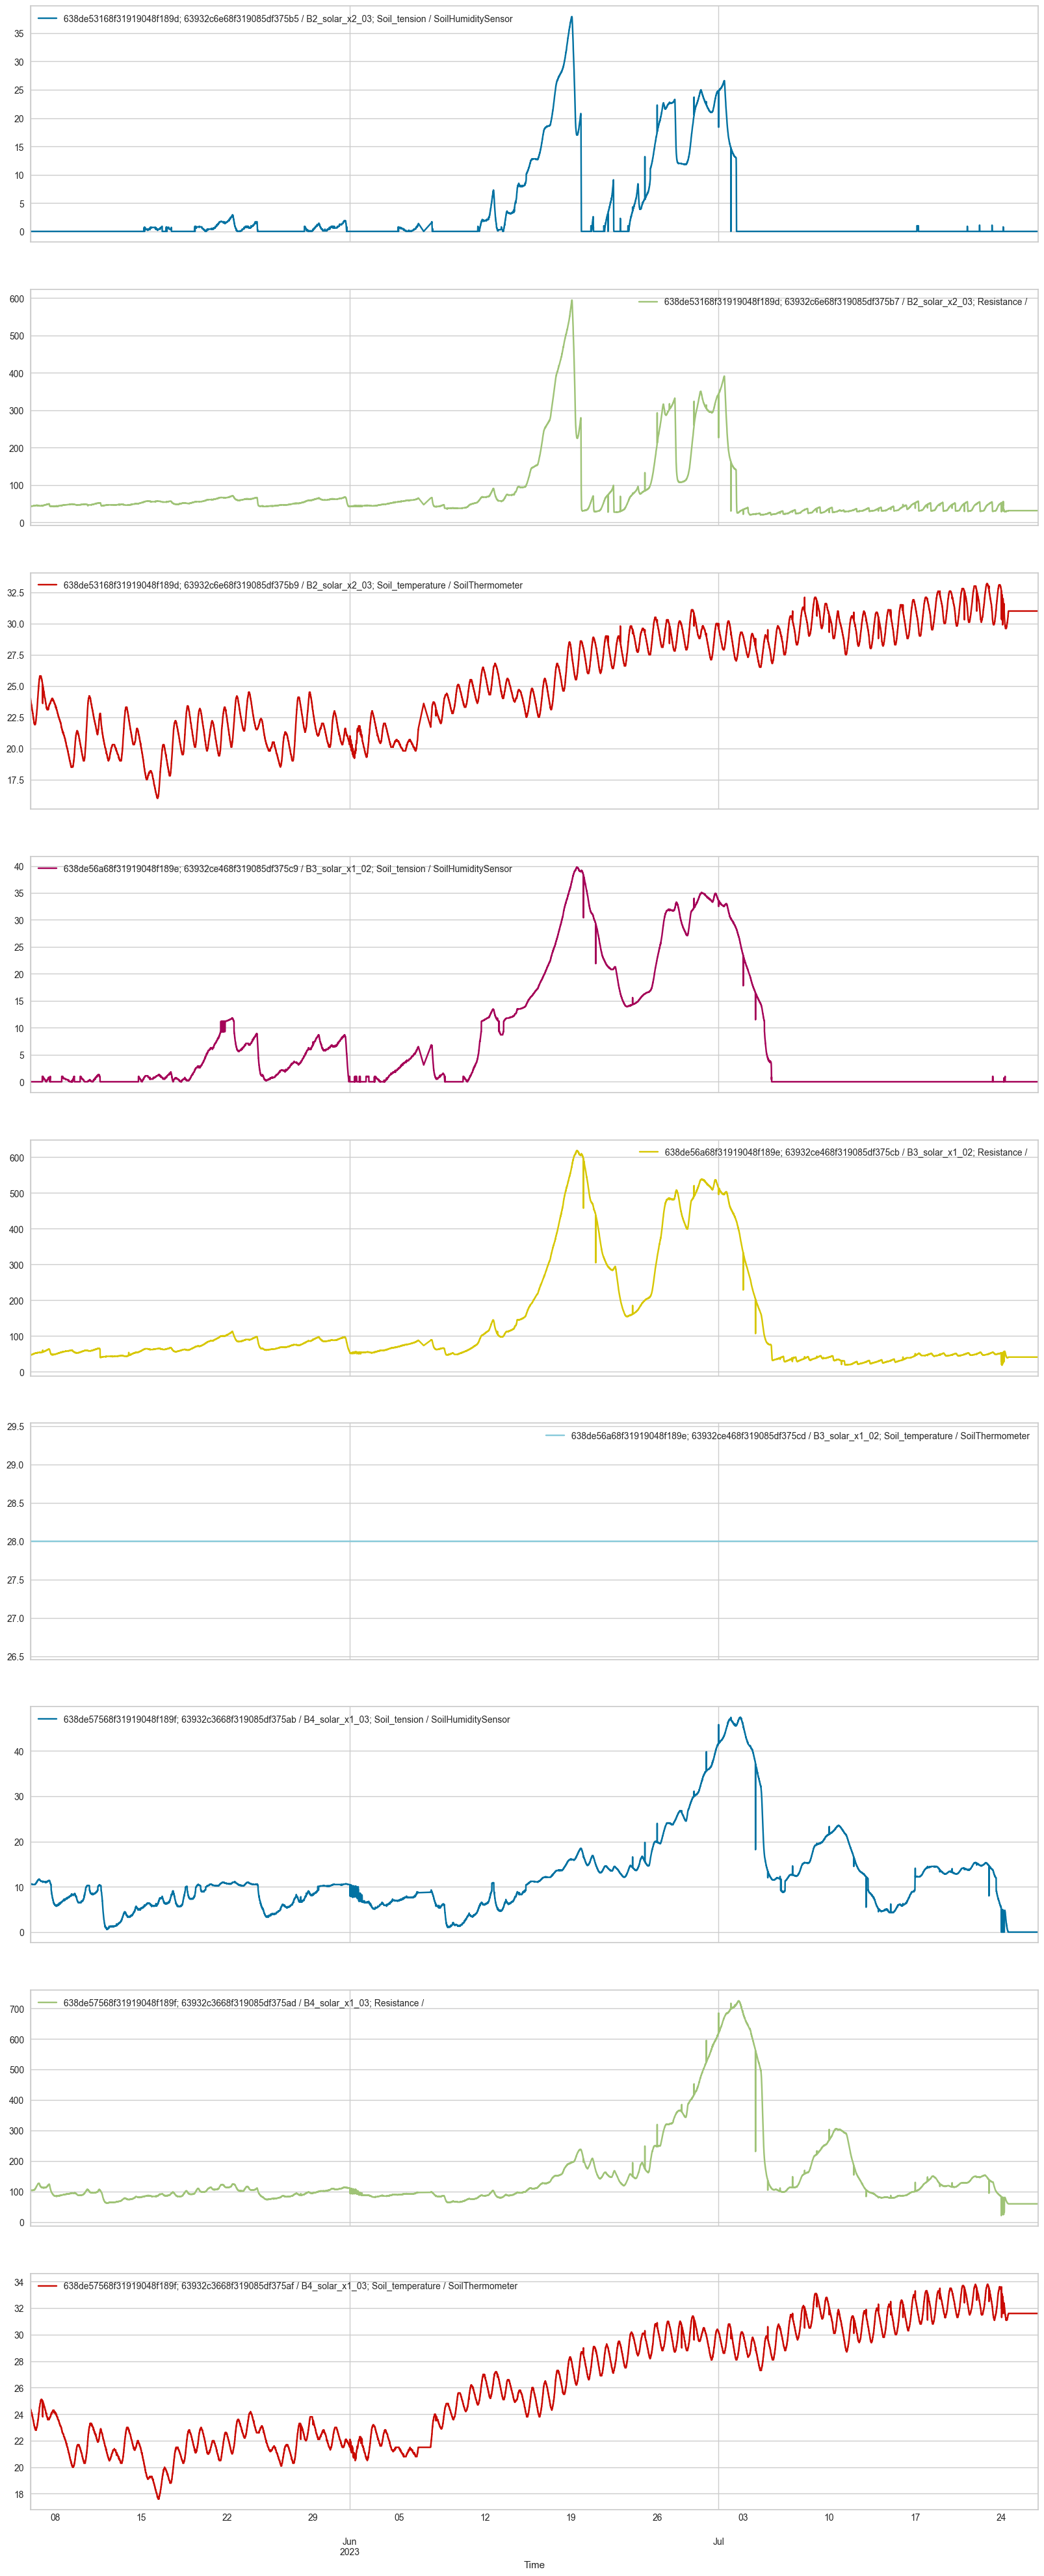

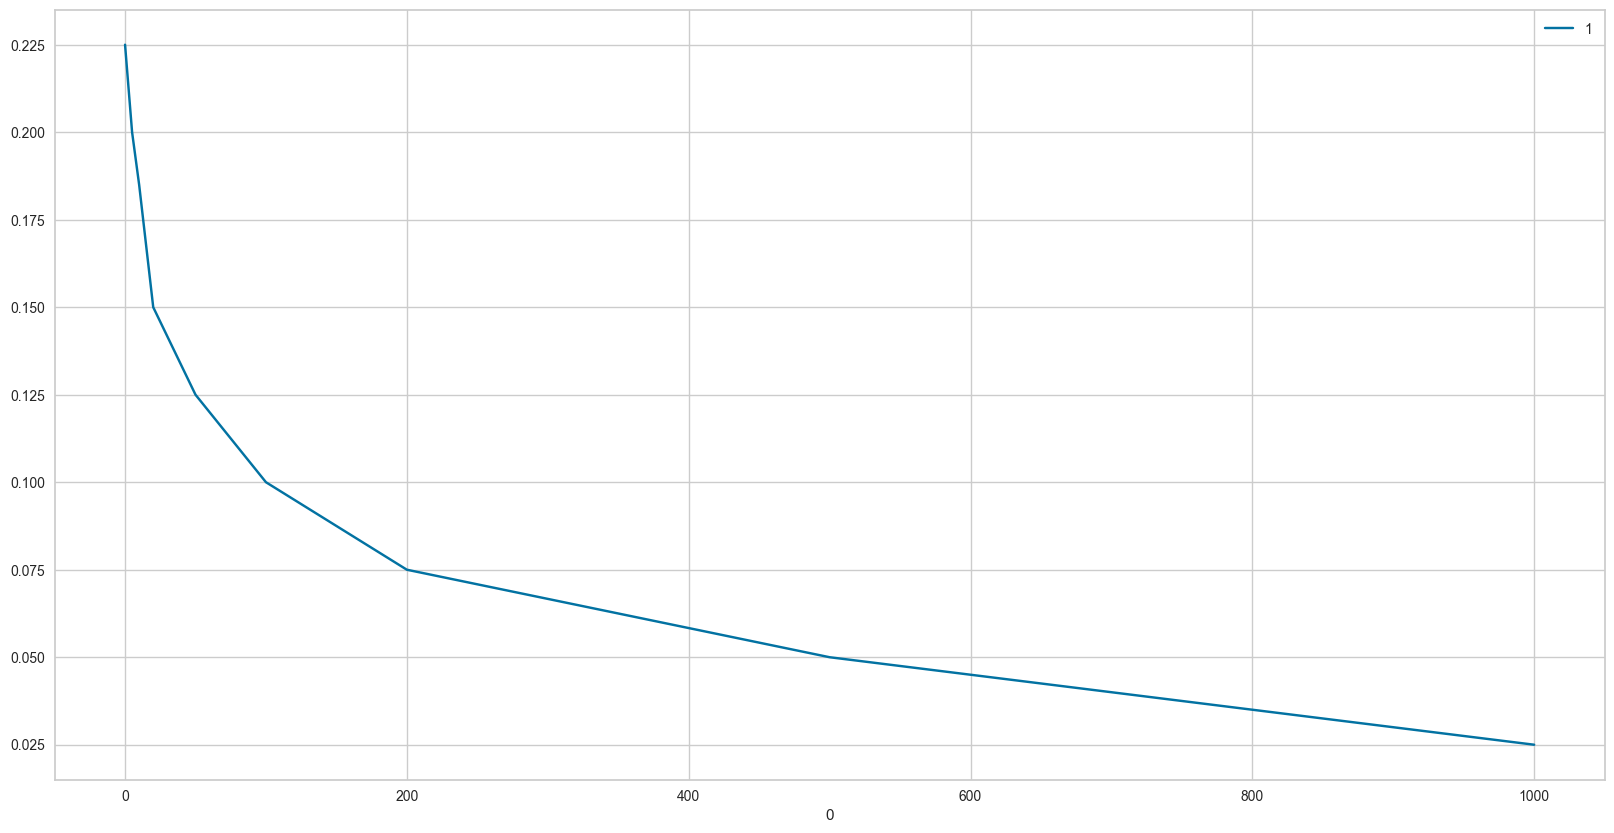

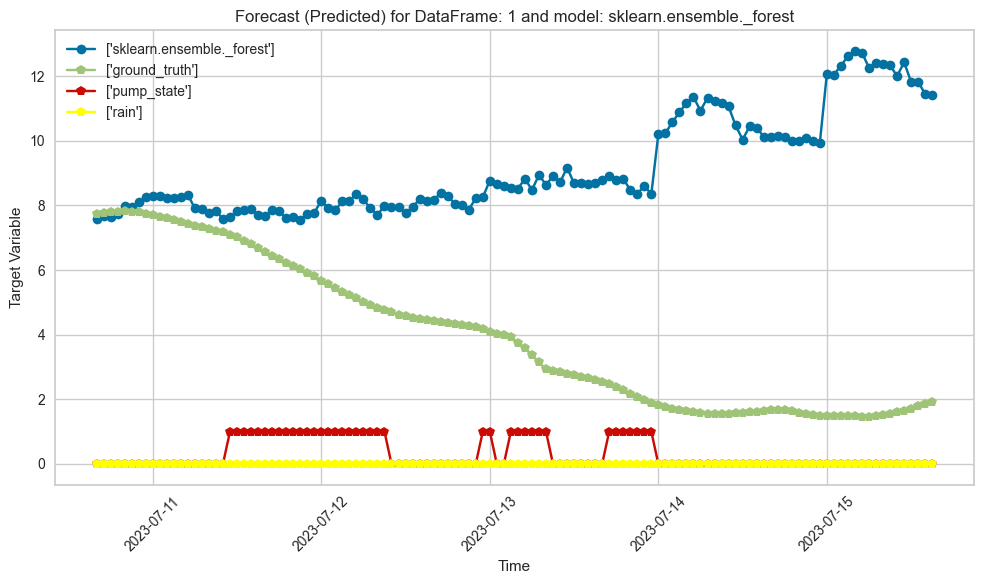

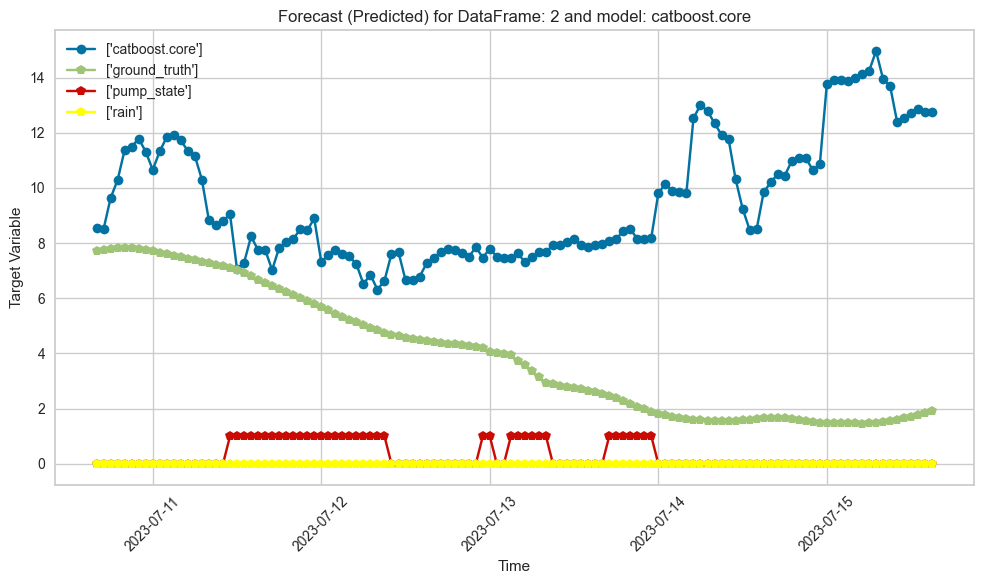

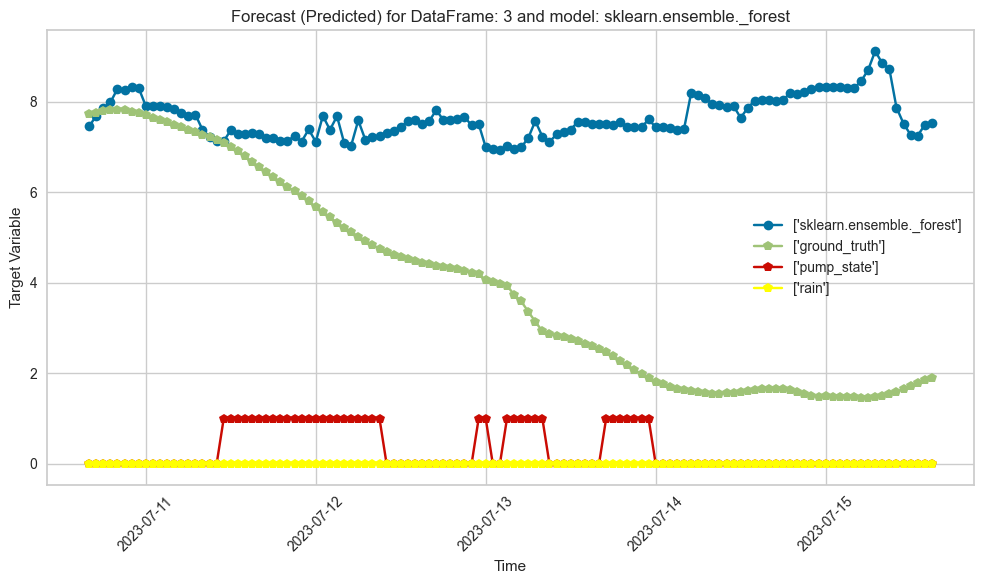

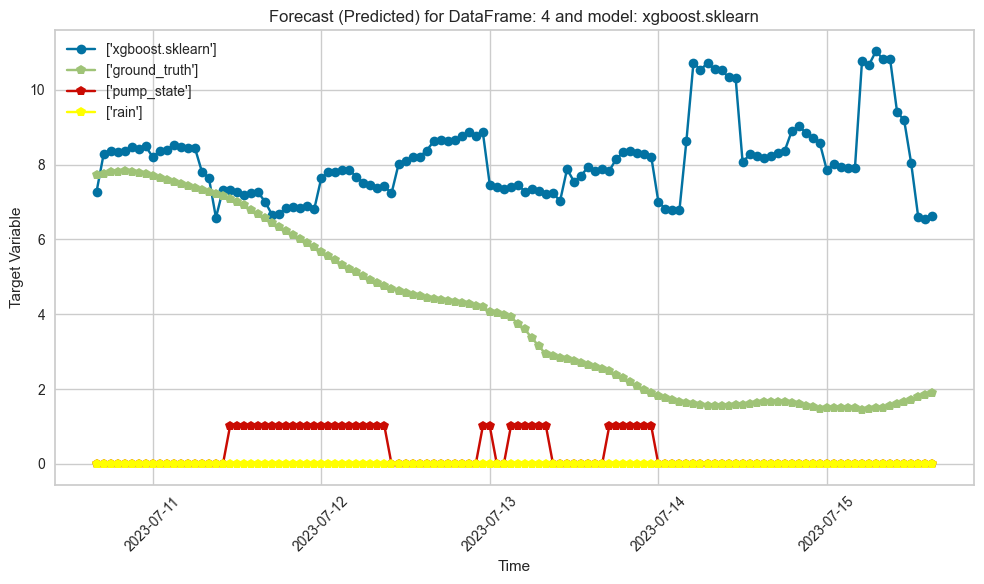

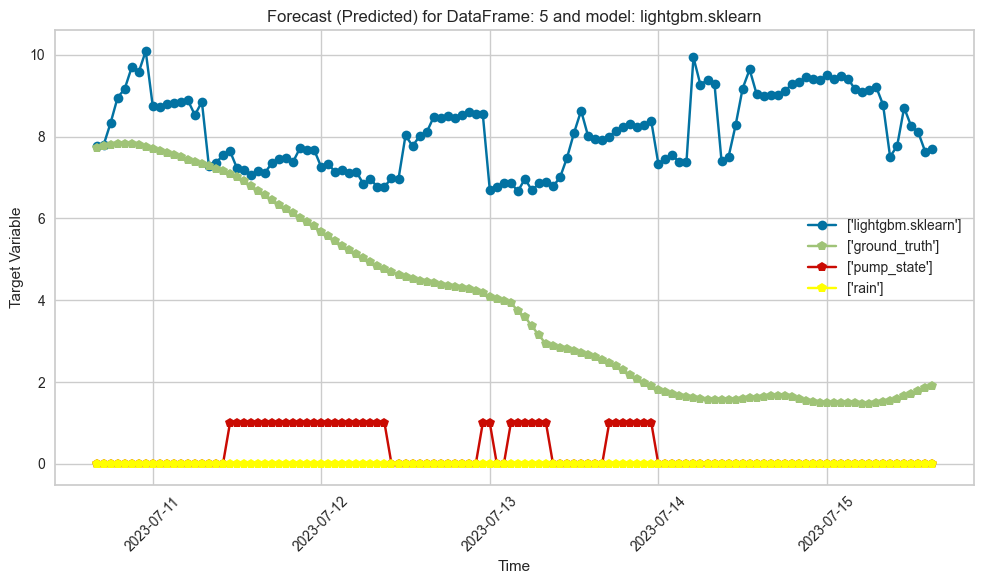

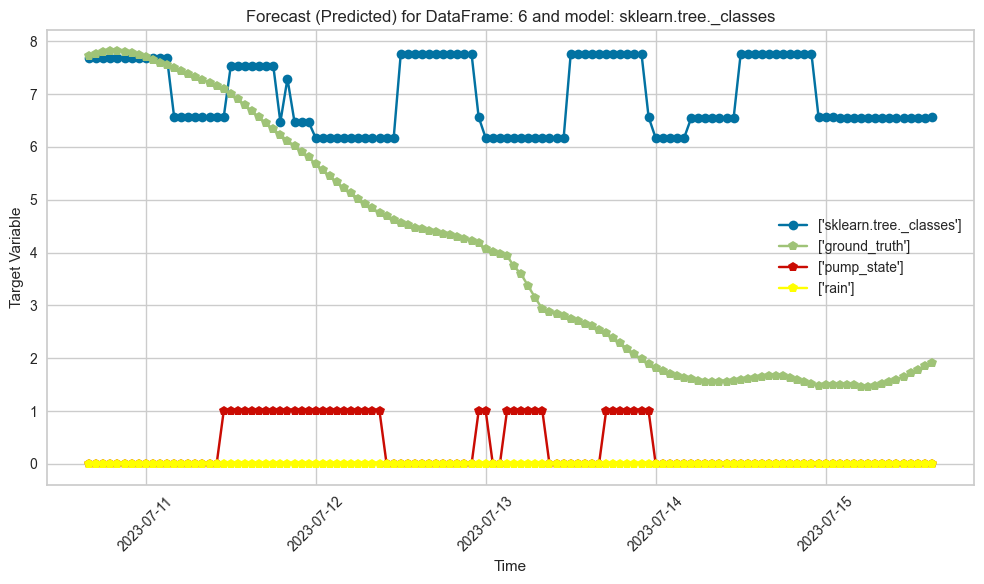

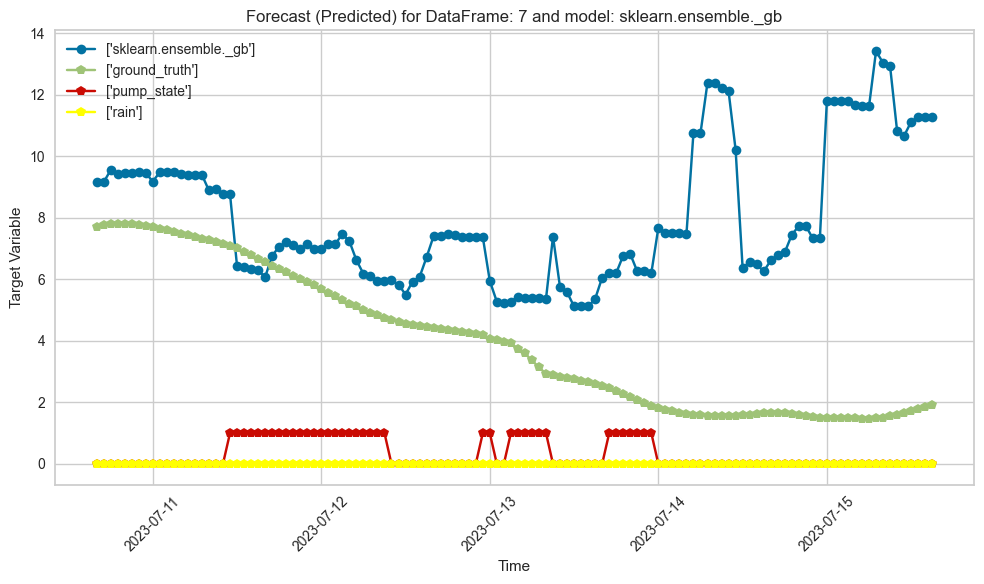

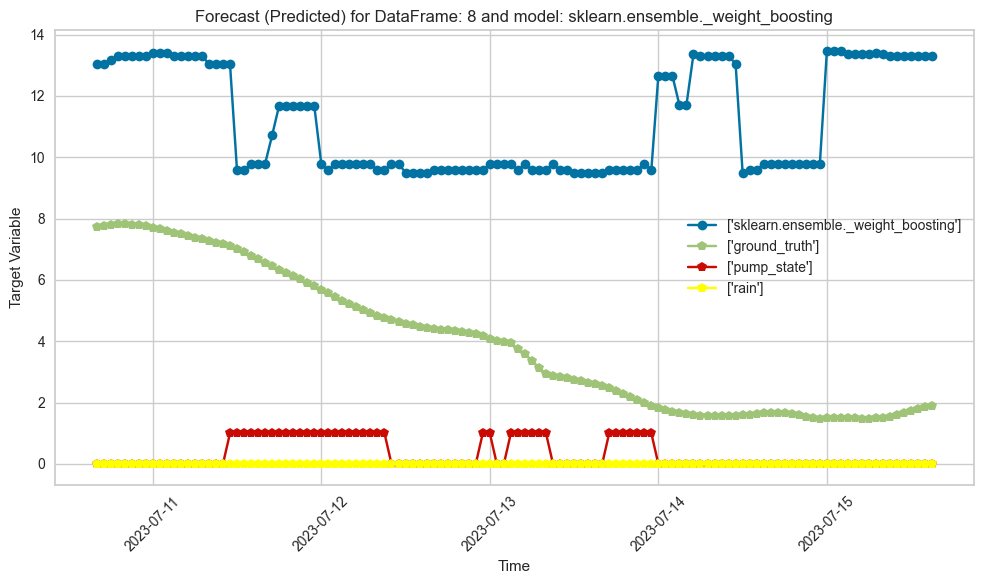

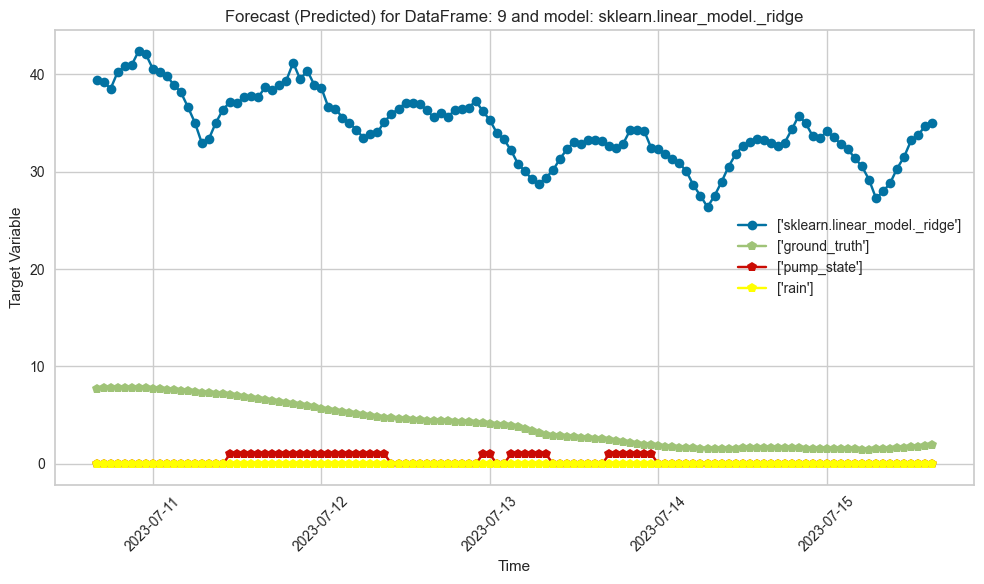

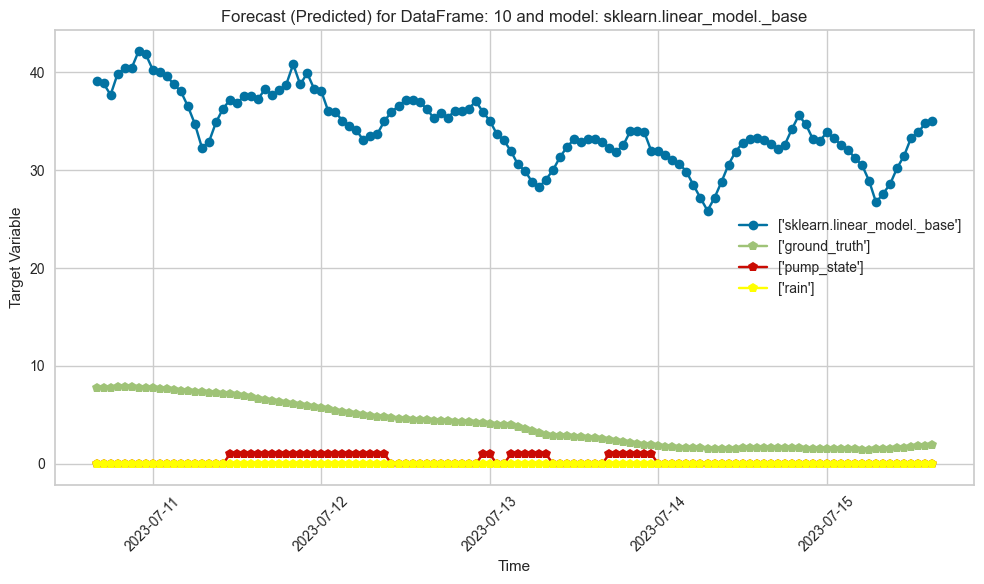

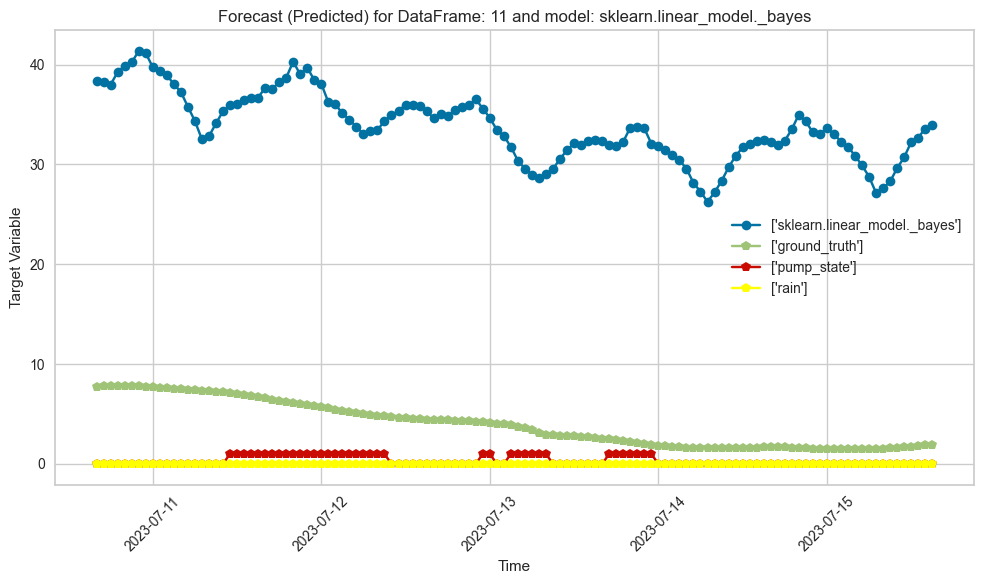

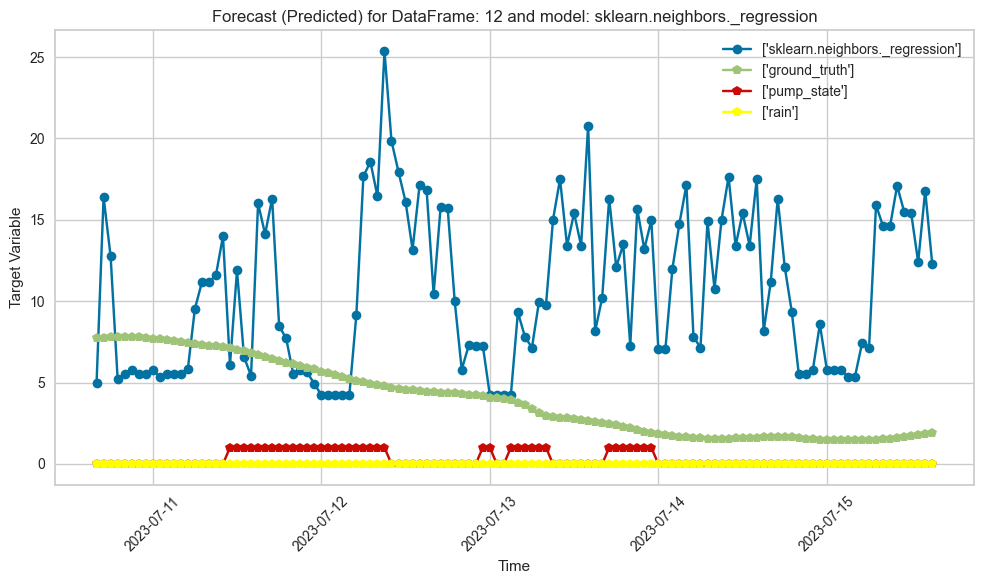

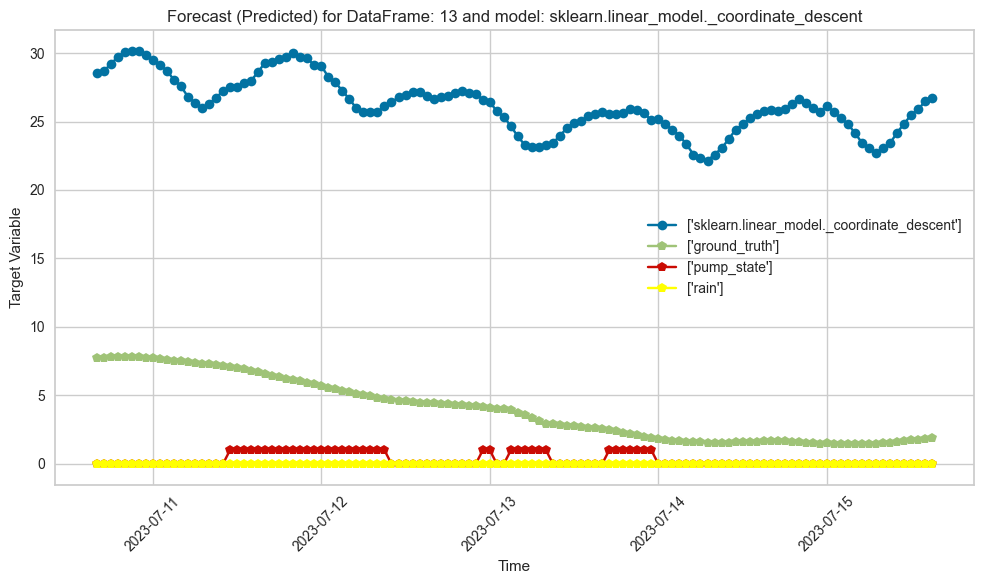

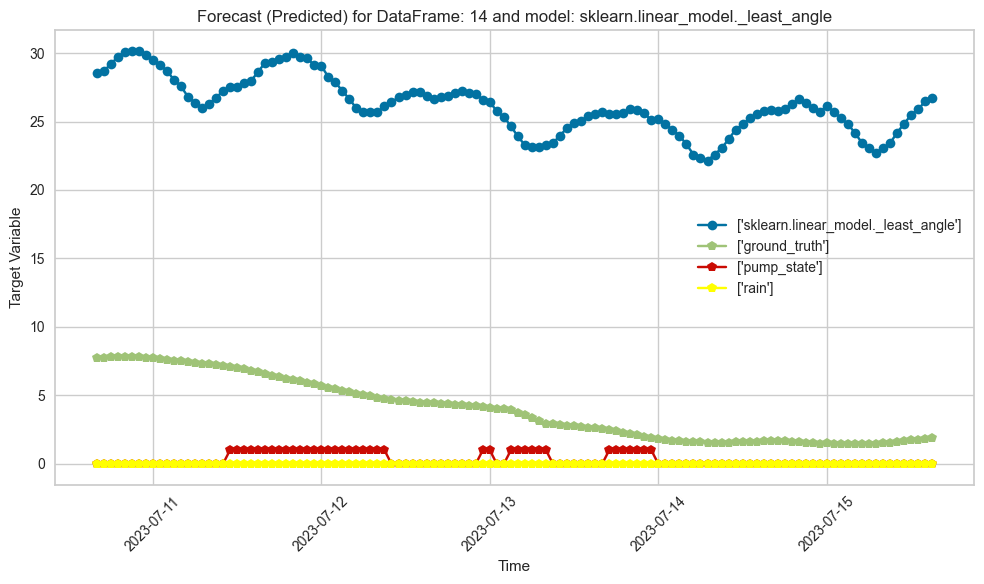

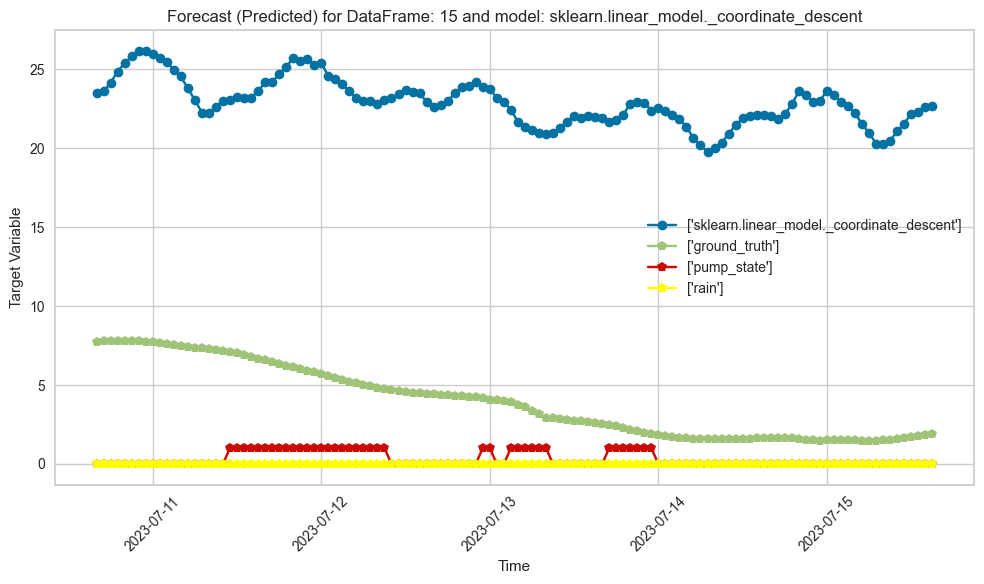

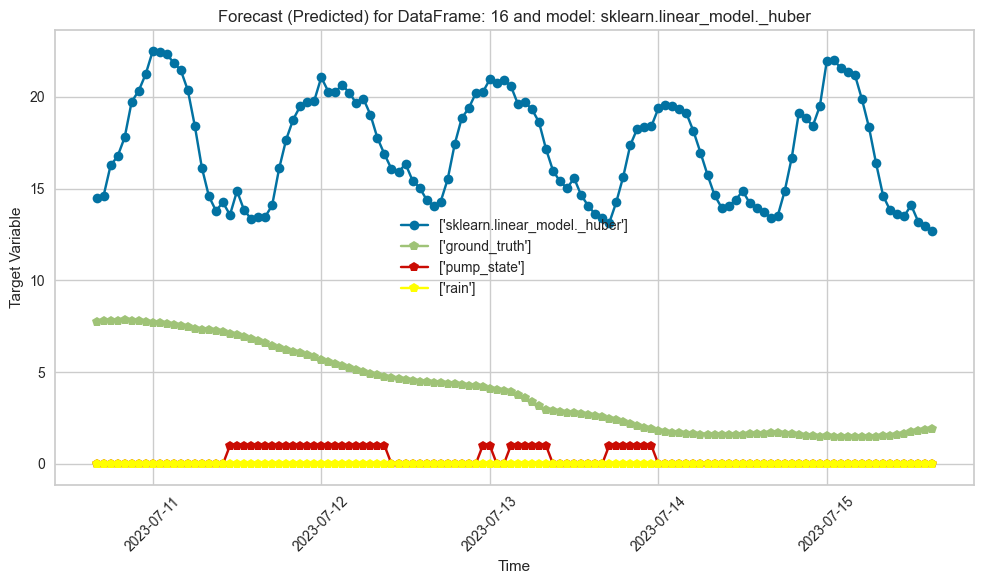

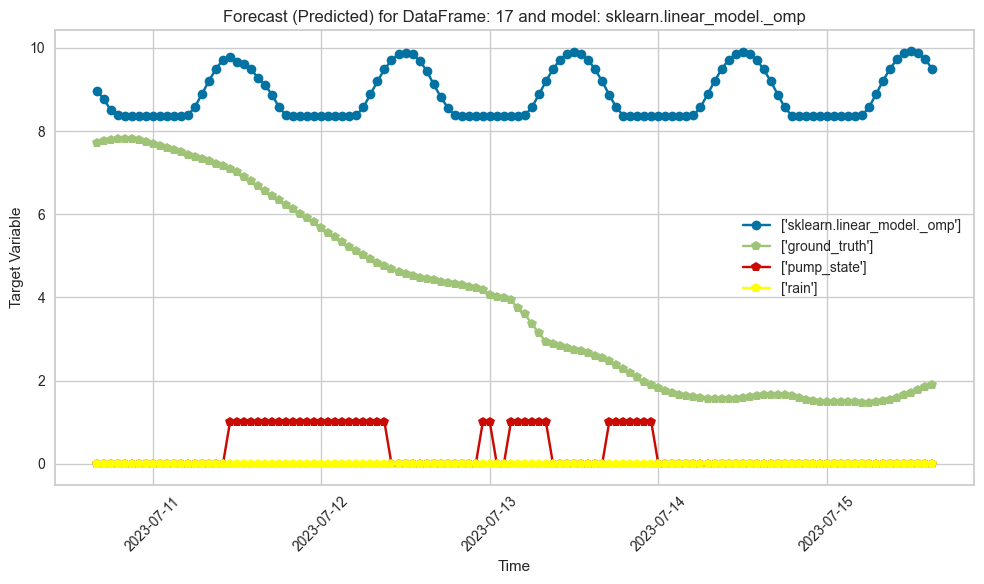

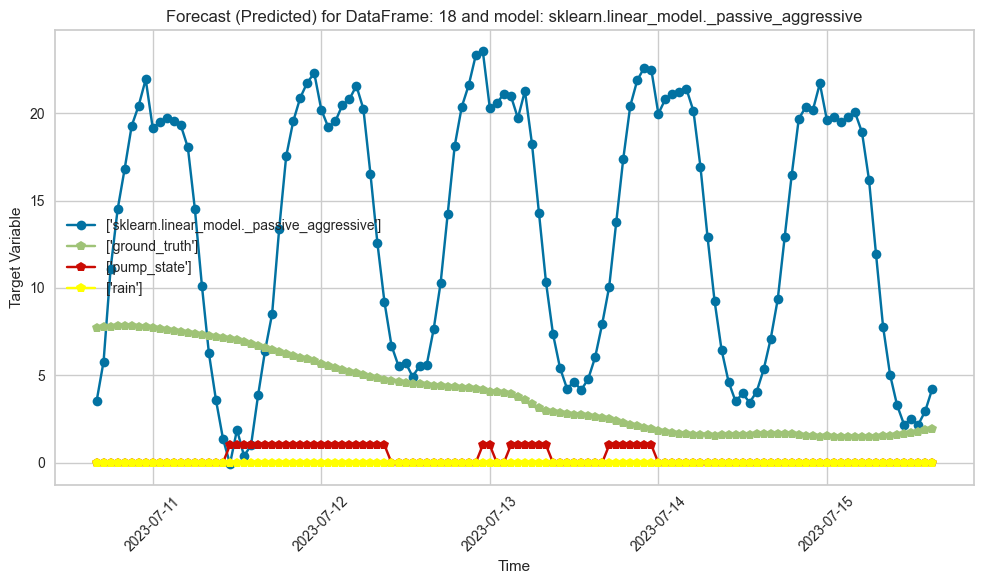

Timestamp
2023-07-10 16:00:00    7.566302
2023-07-10 17:00:00    7.674364
2023-07-10 18:00:00    7.654962
2023-07-10 19:00:00    7.719062
2023-07-10 20:00:00    7.981596
Name: prediction_label, dtype: float64
2023-07-10 16:00:00    7.719143
2023-07-10 17:00:00    7.758989
2023-07-10 18:00:00    7.790165
2023-07-10 19:00:00    7.809343
2023-07-10 20:00:00    7.815620
Freq: 60T, Name: rolling_mean_grouped_soil, dtype: float64
CSV file "appended_results.csv" already exists.
sklearn.ensemble._forest
MAE: 5.22
RMSE: 6.33
MPE: 260.84 %
R2 -6.87 

catboost.core
MAE: 5.54
RMSE: 6.65
MPE: 271.84 %
R2 -7.69 

sklearn.ensemble._forest
MAE: 3.69
RMSE: 4.41
MPE: 181.40 %
R2 -2.82 

xgboost.sklearn
MAE: 4.19
RMSE: 5.03
MPE: 204.57 %
R2 -3.96 

lightgbm.sklearn
MAE: 4.14
RMSE: 4.89
MPE: 201.04 %
R2 -3.70 

sklearn.tree._classes
MAE: 3.11
RMSE: 3.76
MPE: 151.96 %
R2 -1.77 

sklearn.ensemble._gb
MAE: 4.06
RMSE: 5.24
MPE: 207.78 %
R2 -4.39 

sklearn.ensemble._weight_boosting
MAE: 7.22
RMSE: 7.69
MPE: 31

Processing:   0%|          | 0/94 [00:00<?, ?it/s]

start:  2023-08-16 04:00:00
train end before adding:  2023-09-09 19:00:00
end after adding:  2023-09-14 19:00:00 

all dates:  DatetimeIndex(['2023-09-09 19:00:00', '2023-09-09 20:00:00',
               '2023-09-09 21:00:00', '2023-09-09 22:00:00',
               '2023-09-09 23:00:00', '2023-09-10 00:00:00',
               '2023-09-10 01:00:00', '2023-09-10 02:00:00',
               '2023-09-10 03:00:00', '2023-09-10 04:00:00',
               ...
               '2023-09-14 10:00:00', '2023-09-14 11:00:00',
               '2023-09-14 12:00:00', '2023-09-14 13:00:00',
               '2023-09-14 14:00:00', '2023-09-14 15:00:00',
               '2023-09-14 16:00:00', '2023-09-14 17:00:00',
               '2023-09-14 18:00:00', '2023-09-14 19:00:00'],
              dtype='datetime64[ns]', length=121, freq='60T') 

Length of data_weather_api_cut: 121
                     Temperature  Humidity  Rain  Cloudcover  \
date                                                           
2023-09-09 19:0

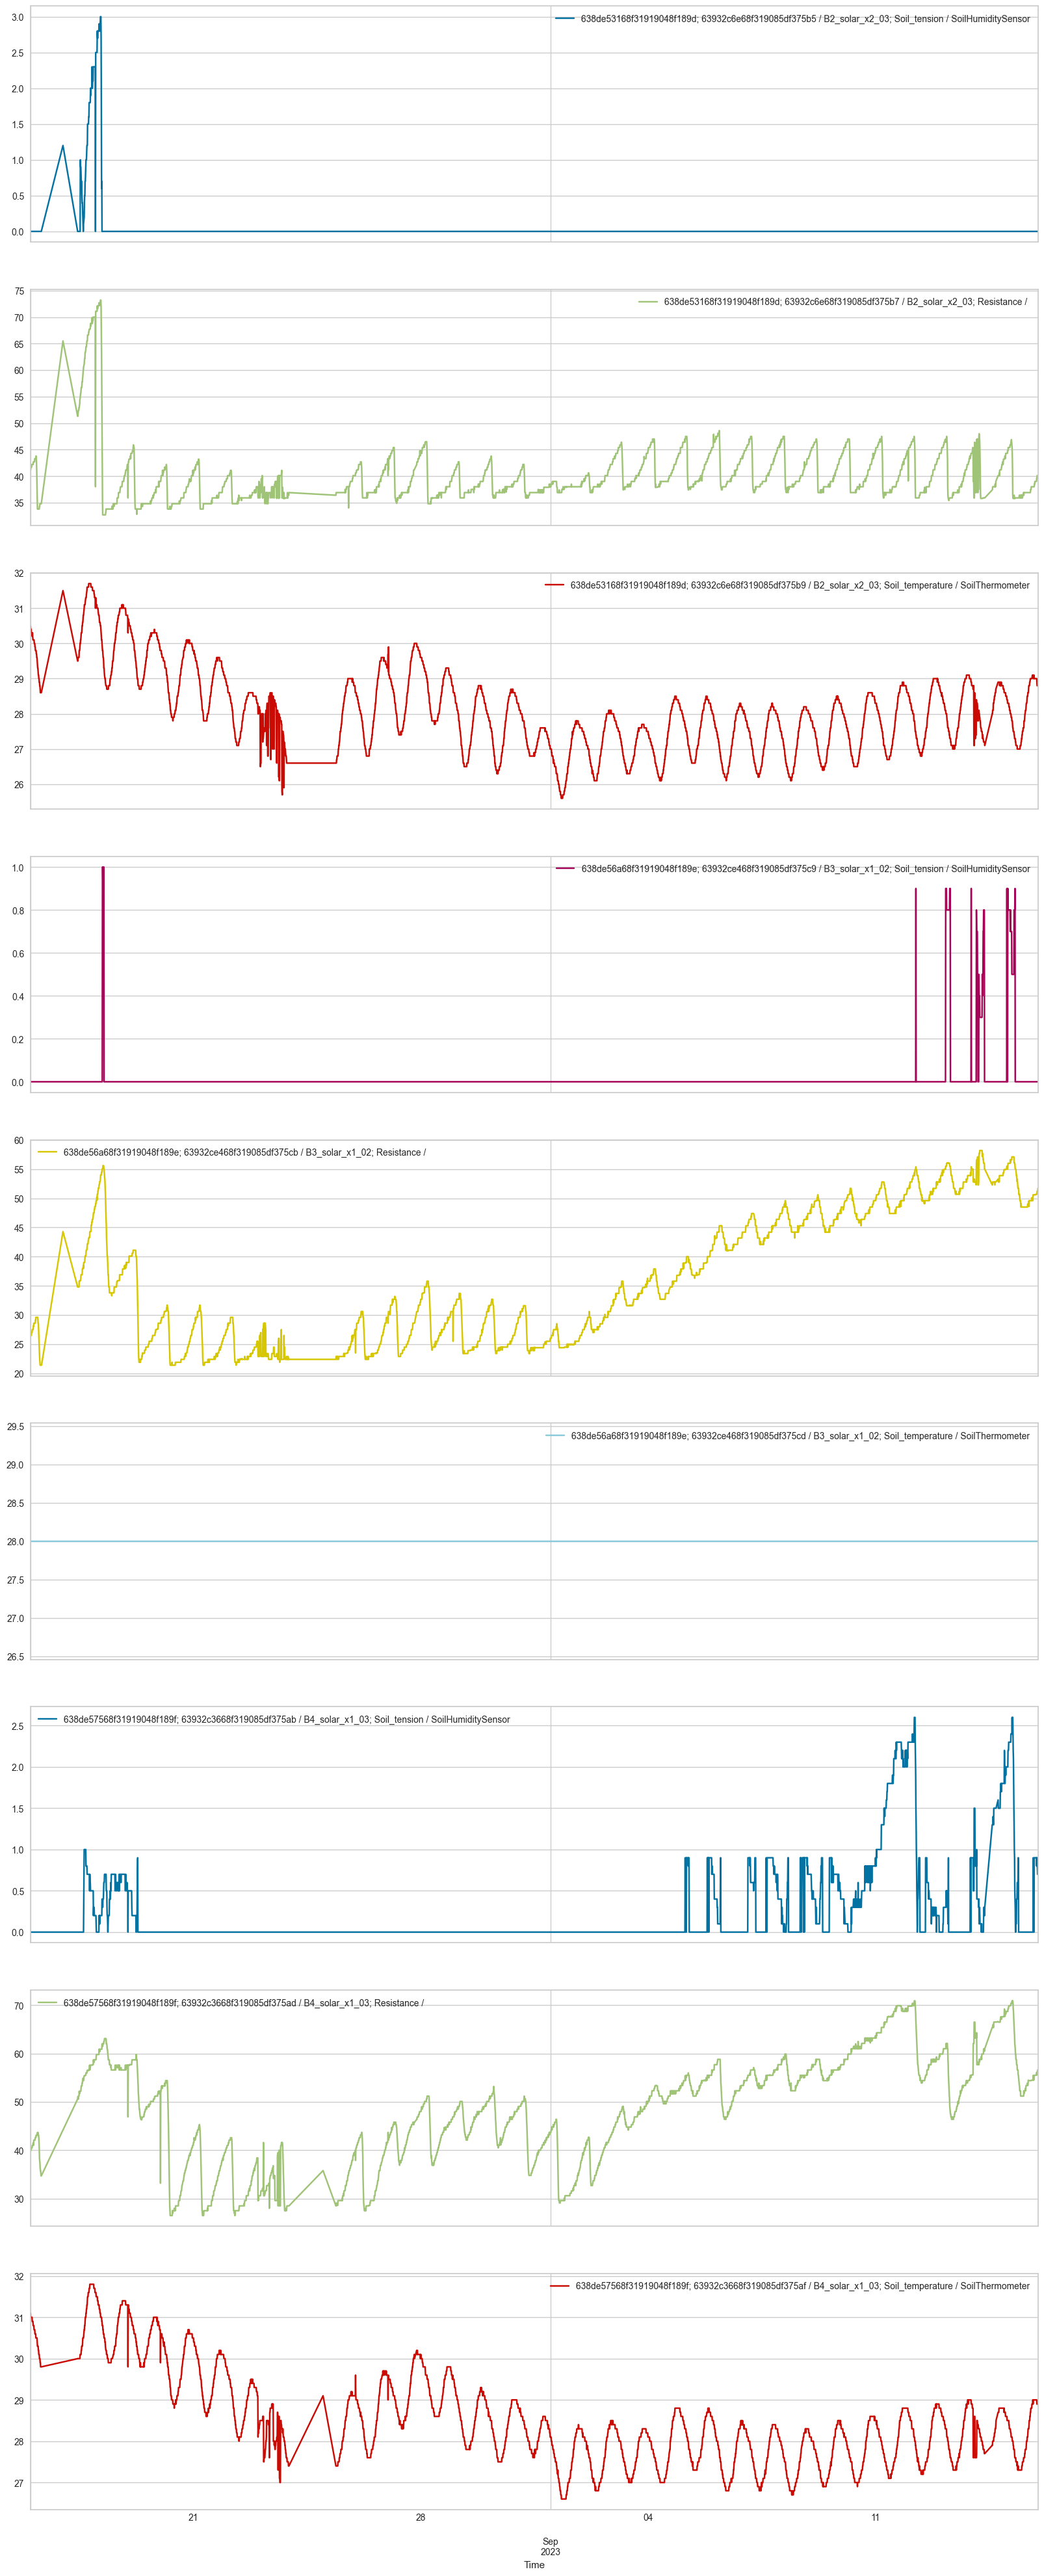

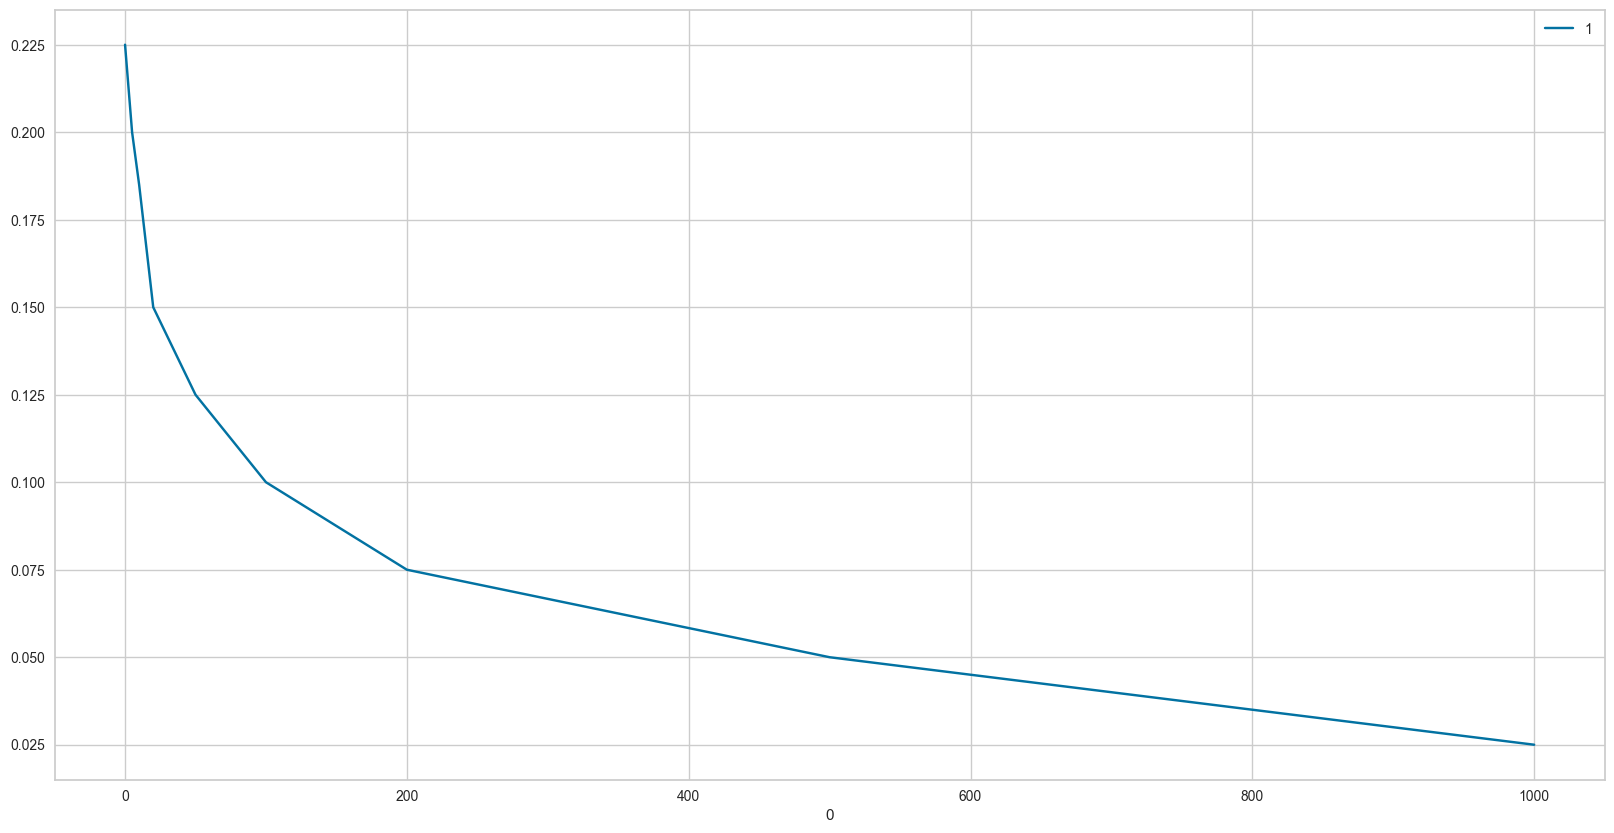

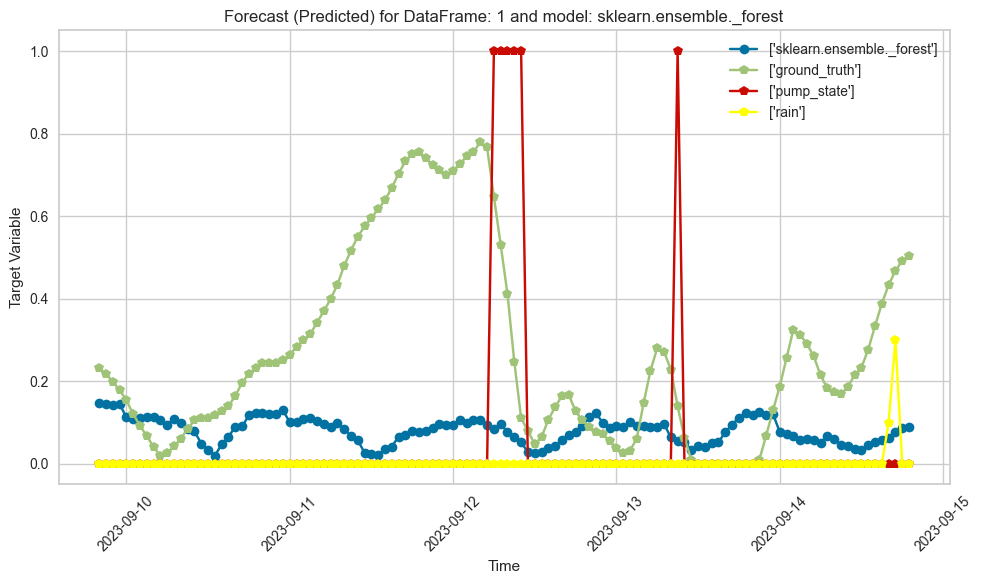

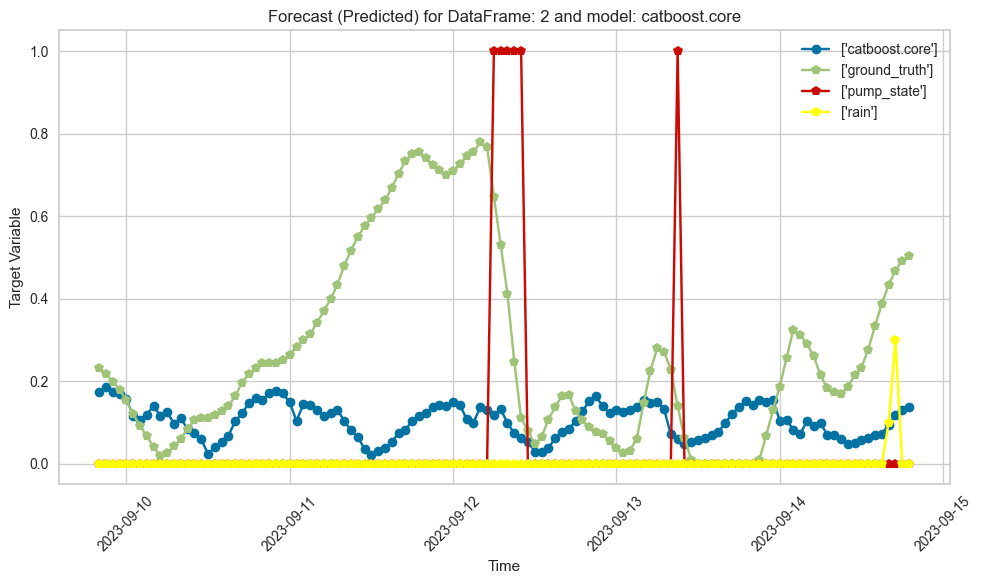

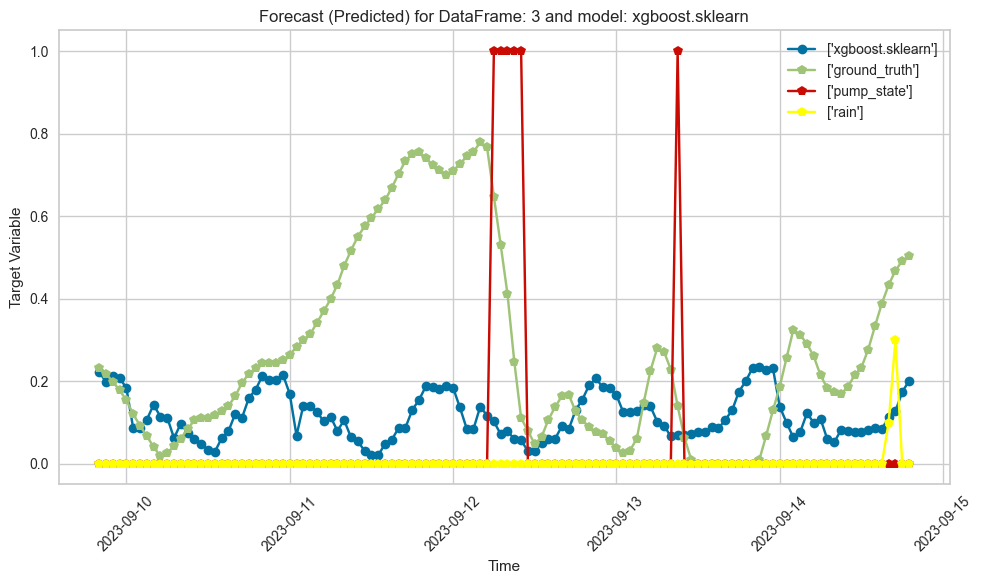

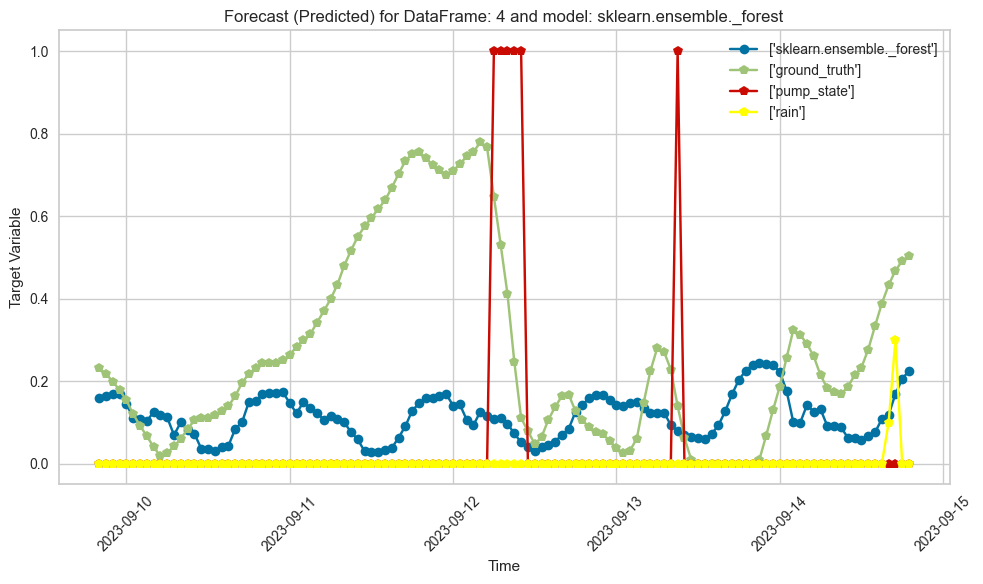

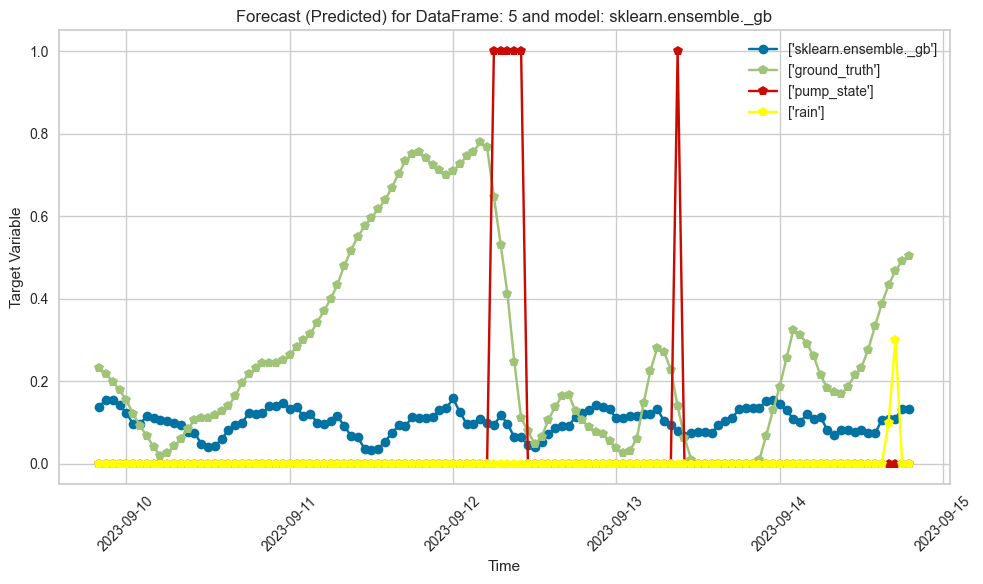

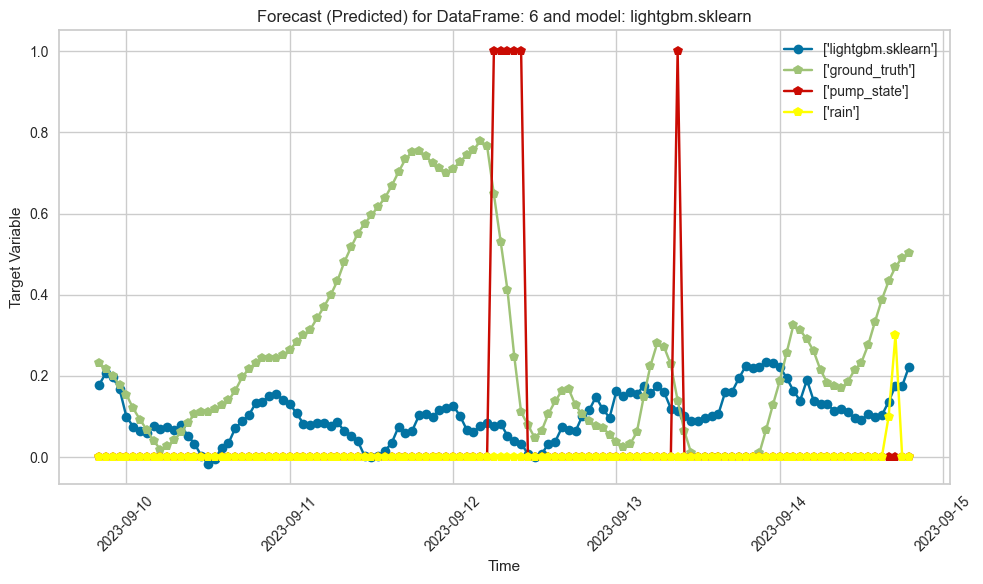

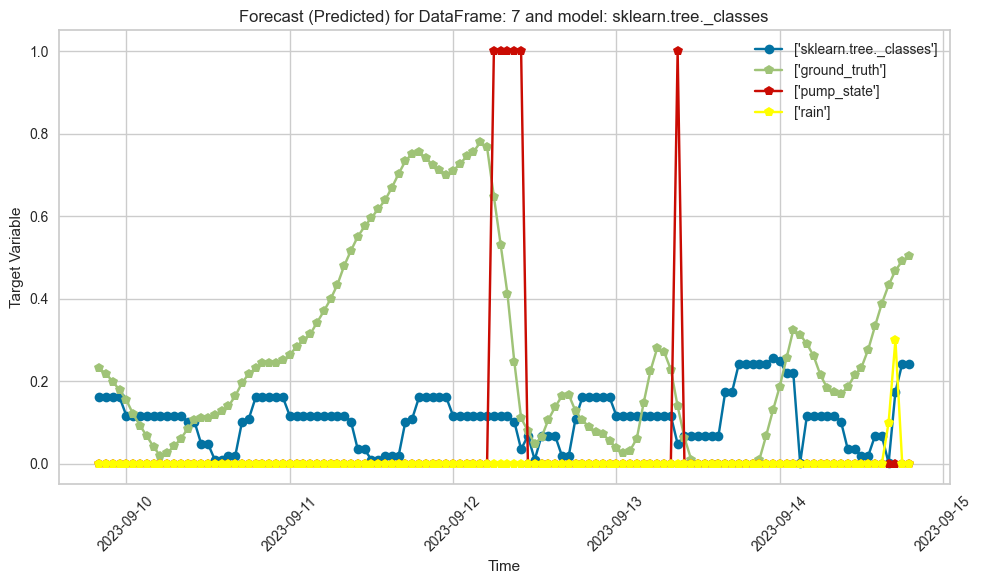

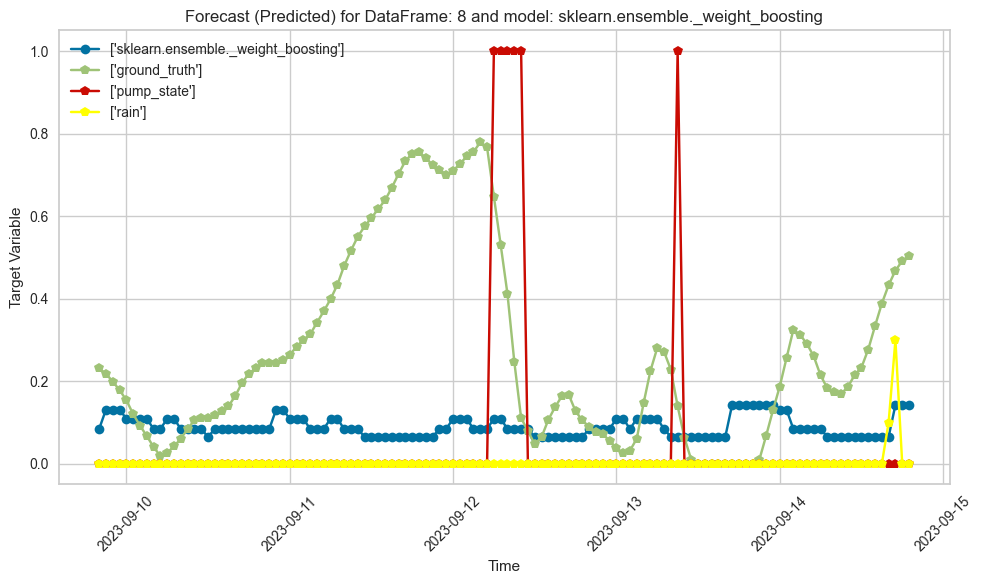

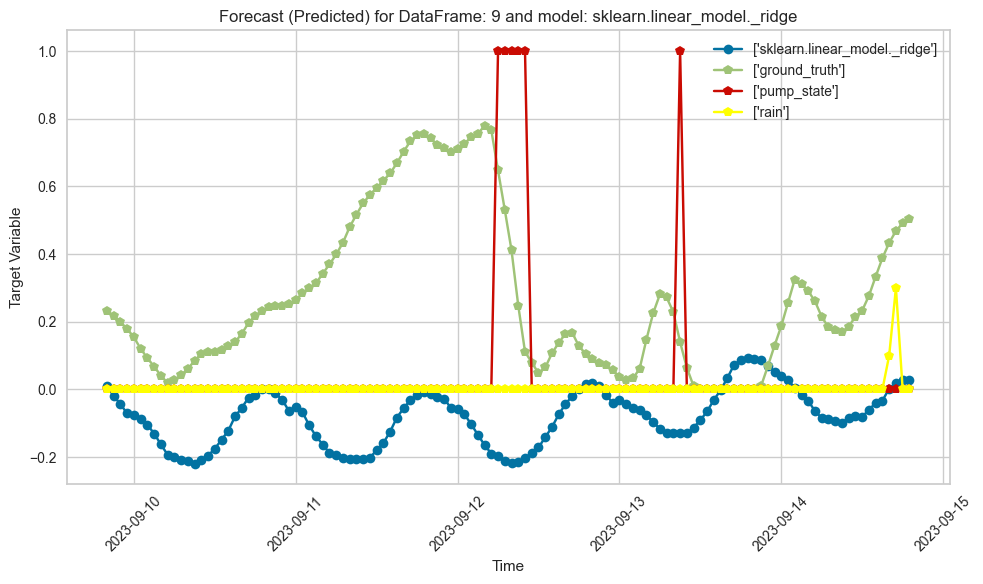

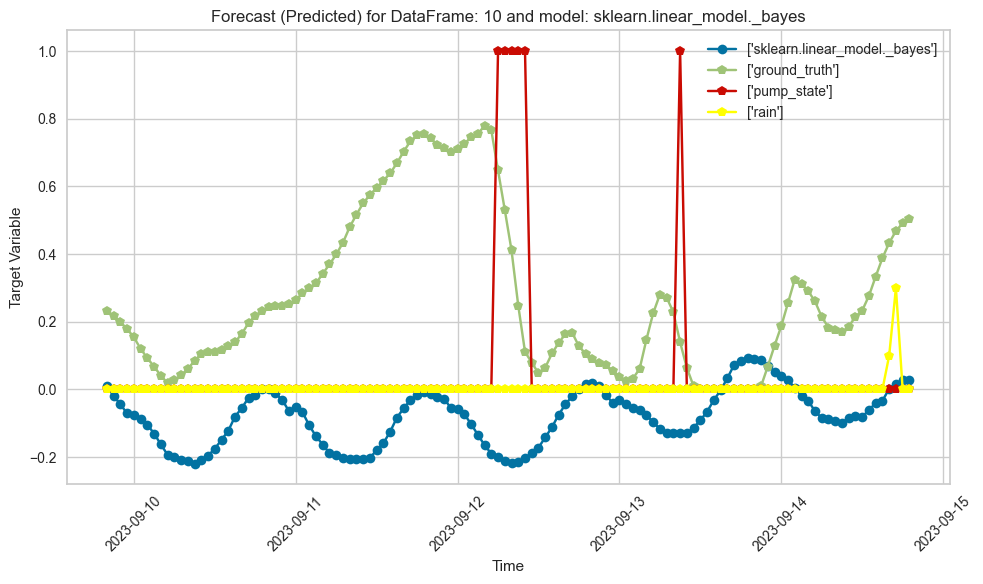

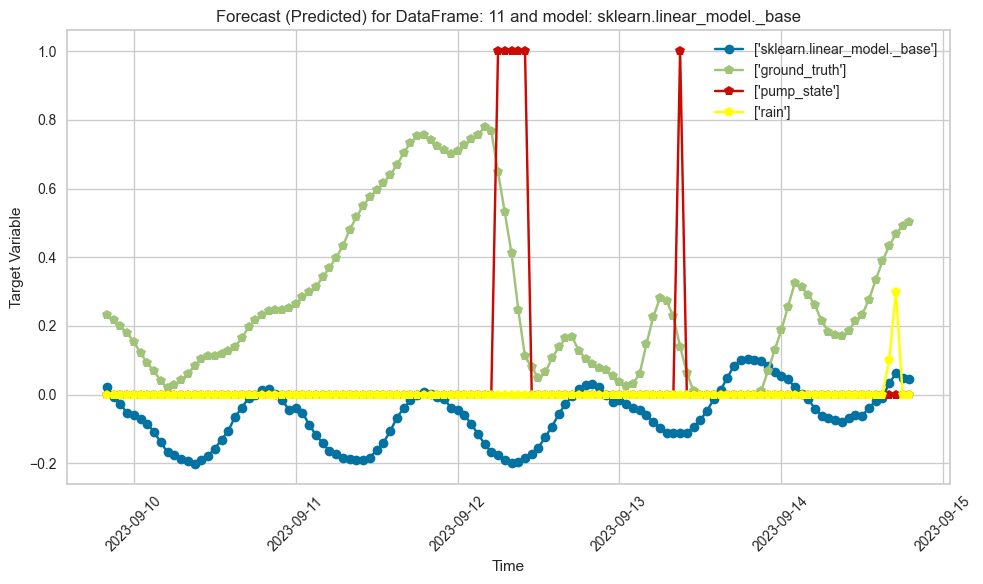

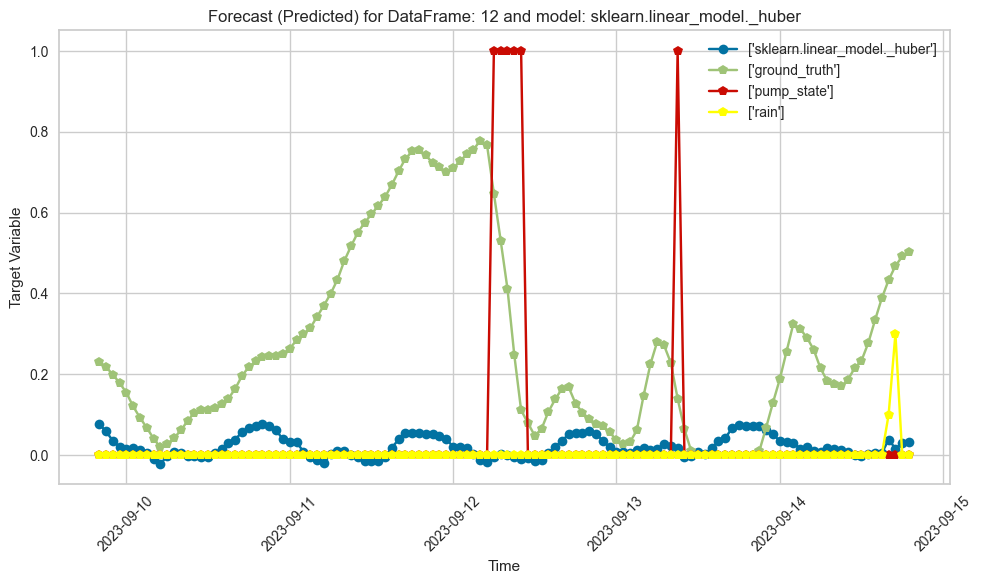

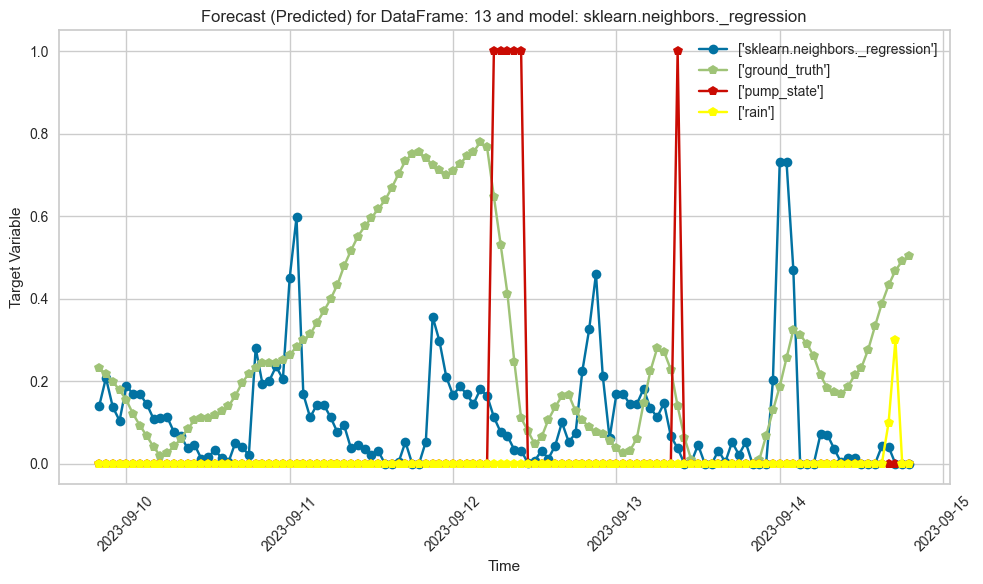

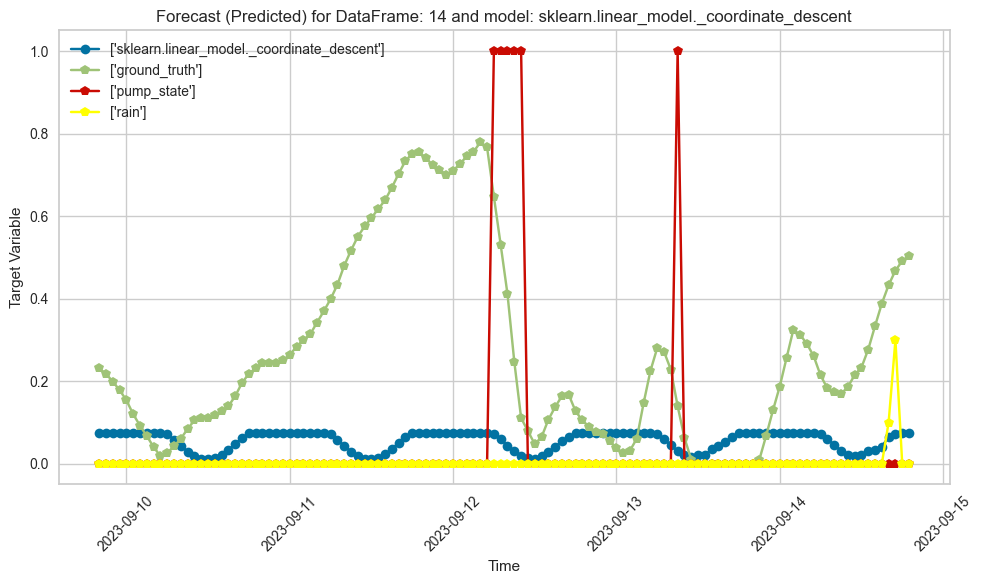

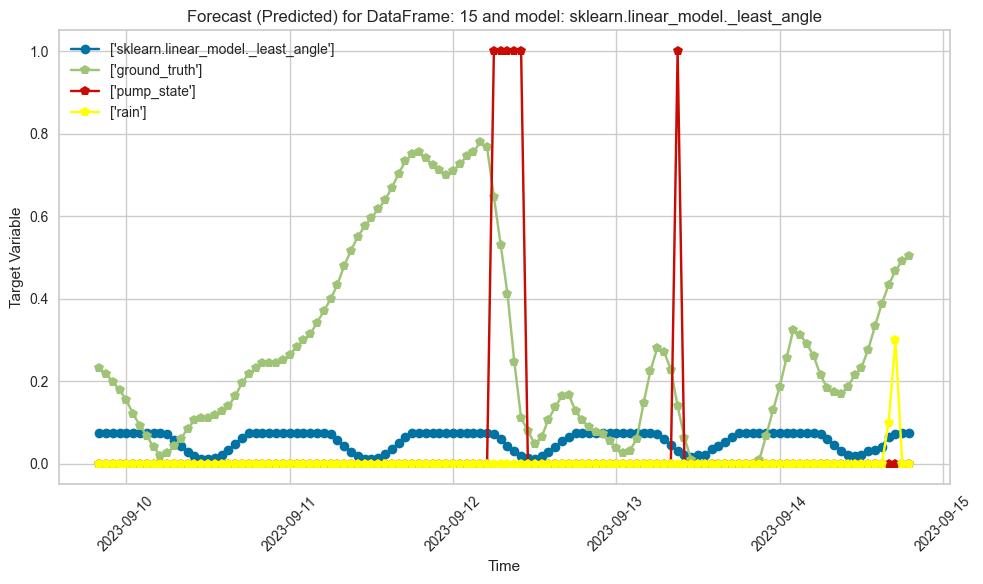

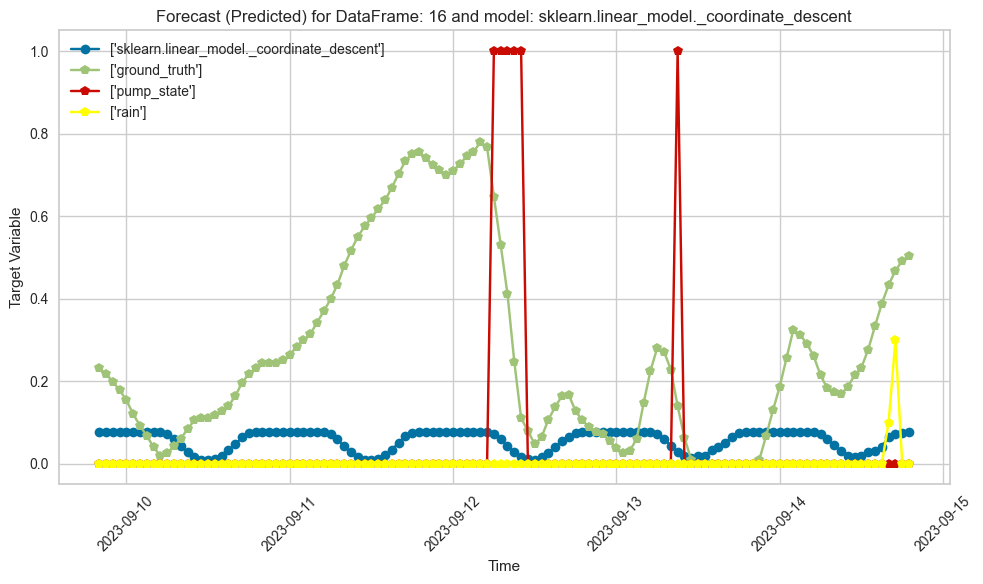

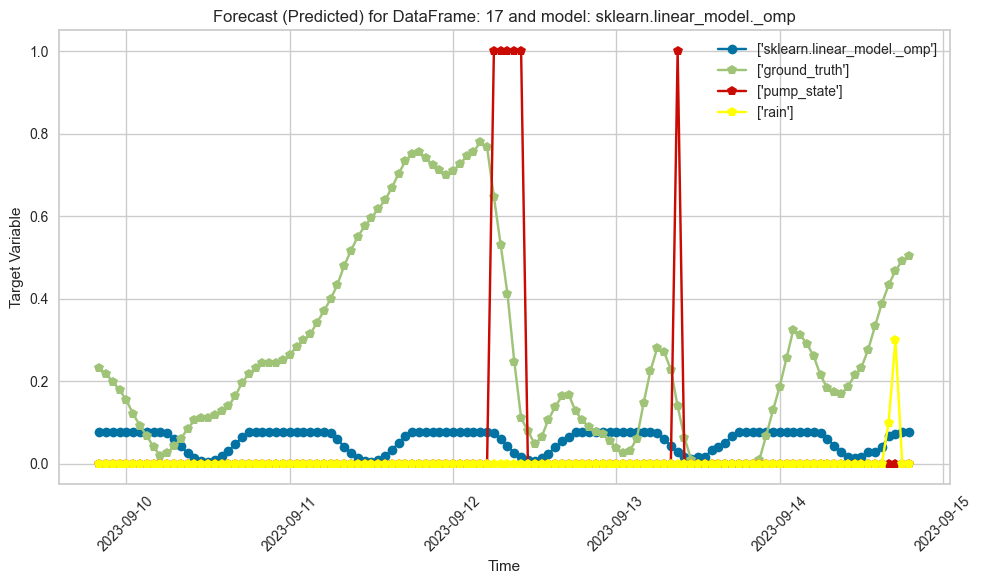

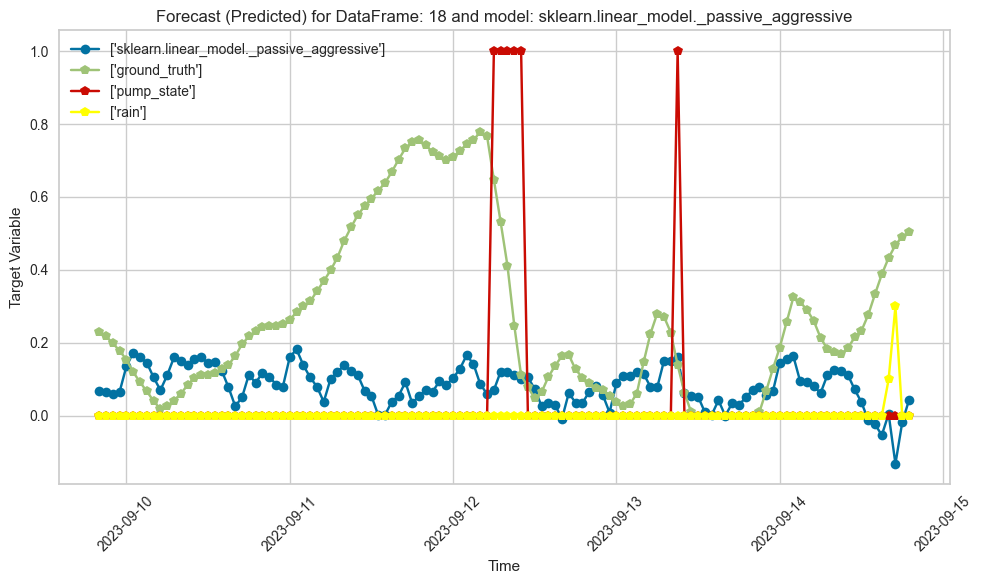

Timestamp
2023-09-09 20:00:00    0.146813
2023-09-09 21:00:00    0.145290
2023-09-09 22:00:00    0.143034
2023-09-09 23:00:00    0.145346
2023-09-10 00:00:00    0.112460
Name: prediction_label, dtype: float64
2023-09-09 20:00:00    0.231199
2023-09-09 21:00:00    0.218198
2023-09-09 22:00:00    0.199266
2023-09-09 23:00:00    0.178756
2023-09-10 00:00:00    0.154156
Freq: 60T, Name: rolling_mean_grouped_soil, dtype: float64
CSV file "appended_results.csv" already exists.
sklearn.ensemble._forest
MAE: 0.22
RMSE: 0.30
MPE: inf %
R2 -0.69 

catboost.core
MAE: 0.21
RMSE: 0.29
MPE: inf %
R2 -0.53 

xgboost.sklearn
MAE: 0.21
RMSE: 0.29
MPE: inf %
R2 -0.51 

sklearn.ensemble._forest
MAE: 0.21
RMSE: 0.29
MPE: inf %
R2 -0.51 

sklearn.ensemble._gb
MAE: 0.21
RMSE: 0.29
MPE: inf %
R2 -0.54 

lightgbm.sklearn
MAE: 0.21
RMSE: 0.30
MPE: inf %
R2 -0.66 

sklearn.tree._classes
MAE: 0.21
RMSE: 0.29
MPE: inf %
R2 -0.57 

sklearn.ensemble._weight_boosting
MAE: 0.21
RMSE: 0.30
MPE: inf %
R2 -0.64 

sklear

Processing:   0%|          | 0/94 [00:00<?, ?it/s]

start:  2023-04-07 04:00:00
train end before adding:  2023-06-21 05:00:00
end after adding:  2023-06-26 05:00:00 

all dates:  DatetimeIndex(['2023-06-21 05:00:00', '2023-06-21 06:00:00',
               '2023-06-21 07:00:00', '2023-06-21 08:00:00',
               '2023-06-21 09:00:00', '2023-06-21 10:00:00',
               '2023-06-21 11:00:00', '2023-06-21 12:00:00',
               '2023-06-21 13:00:00', '2023-06-21 14:00:00',
               ...
               '2023-06-25 20:00:00', '2023-06-25 21:00:00',
               '2023-06-25 22:00:00', '2023-06-25 23:00:00',
               '2023-06-26 00:00:00', '2023-06-26 01:00:00',
               '2023-06-26 02:00:00', '2023-06-26 03:00:00',
               '2023-06-26 04:00:00', '2023-06-26 05:00:00'],
              dtype='datetime64[ns]', length=121, freq='60T') 

Length of data_weather_api_cut: 121
                     Temperature  Humidity  Rain  Cloudcover  \
date                                                           
2023-06-21 05:0

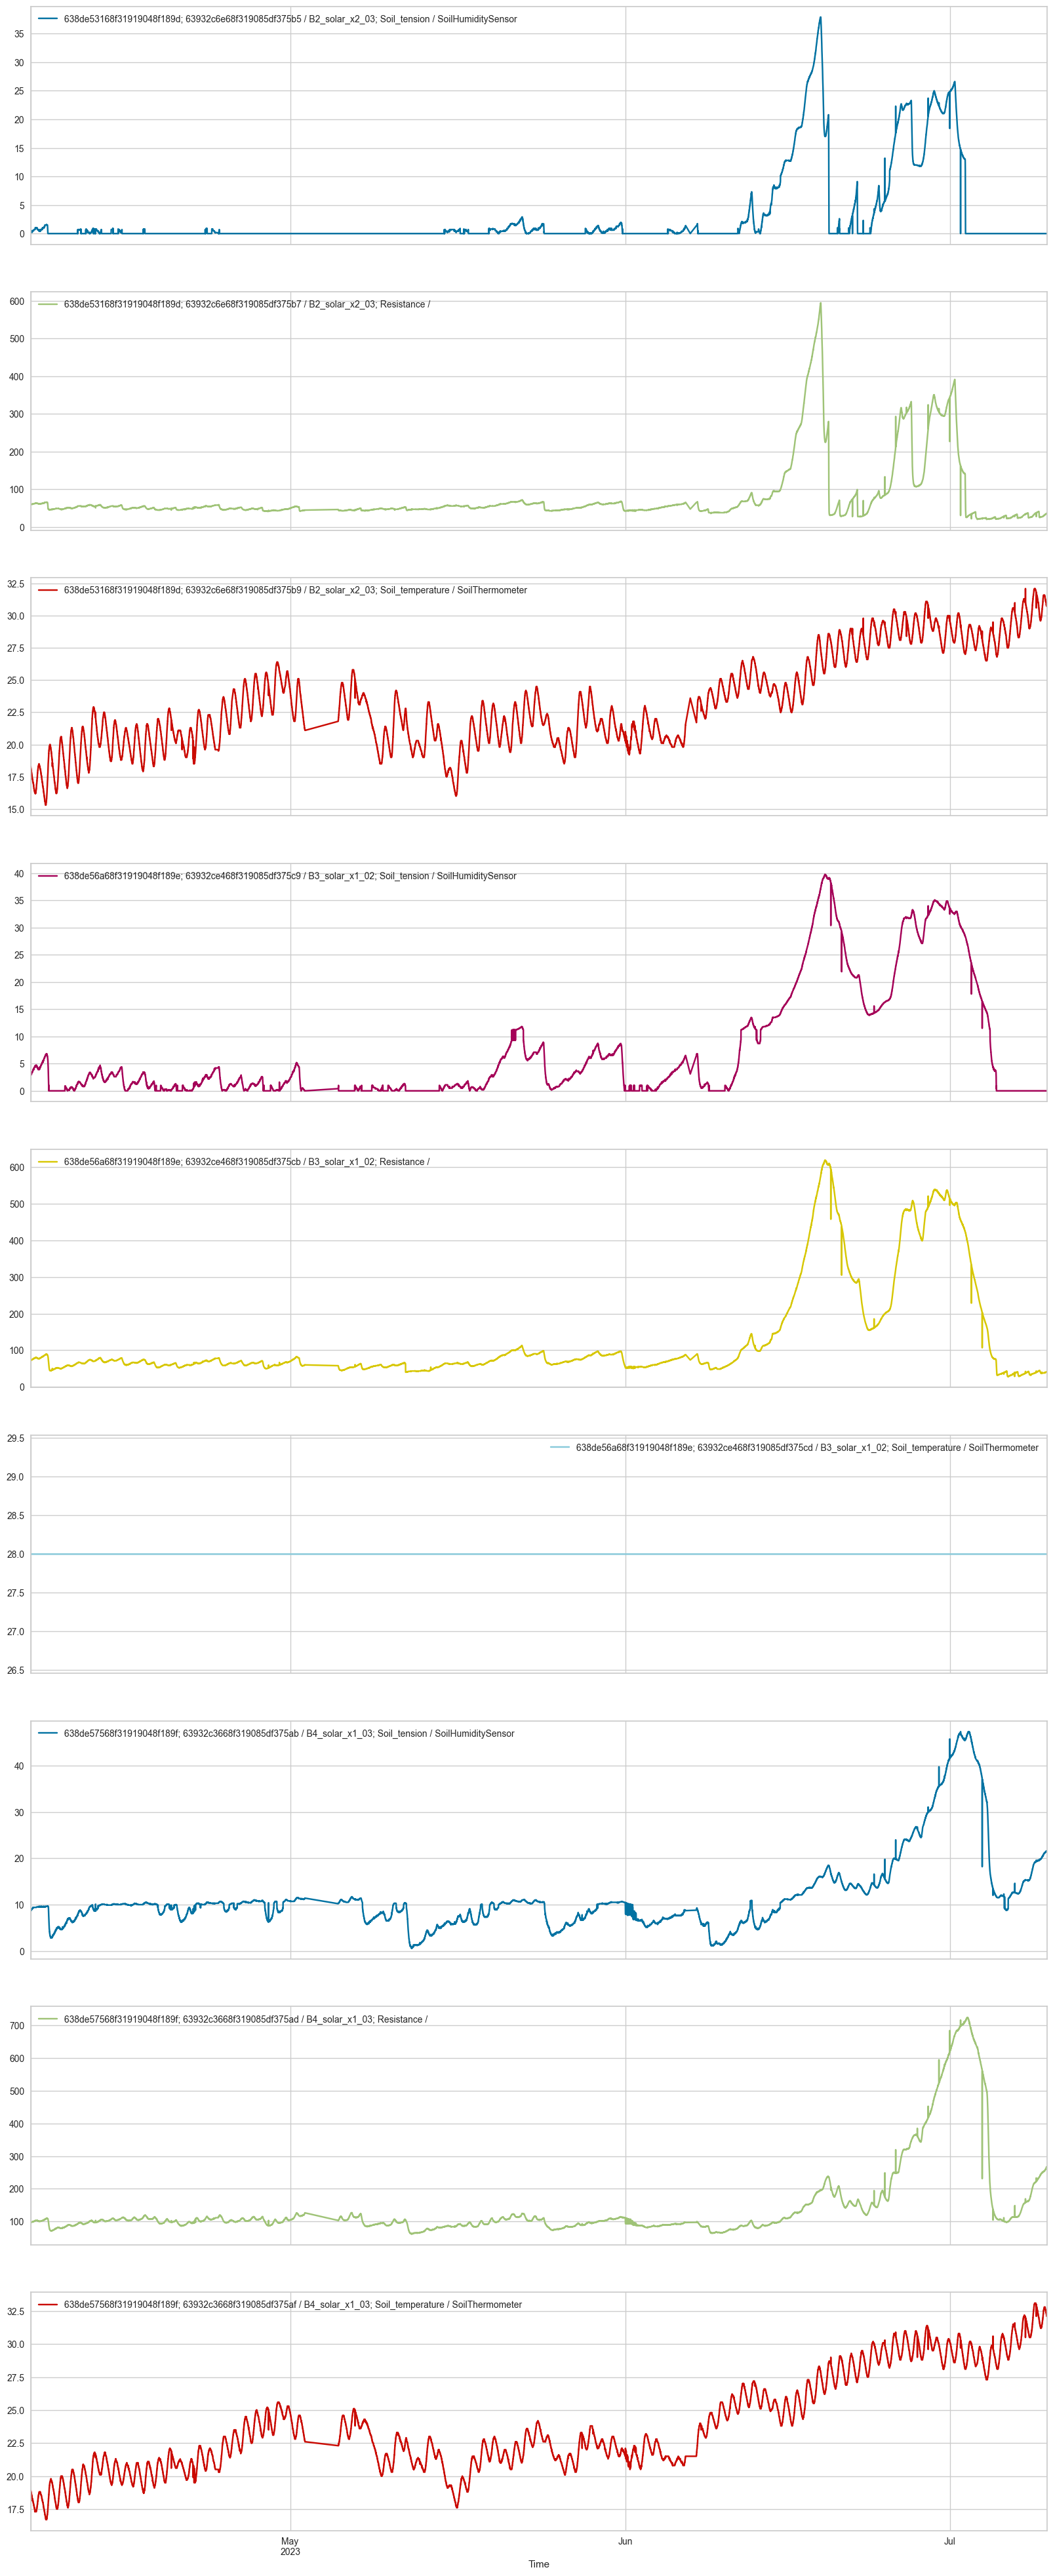

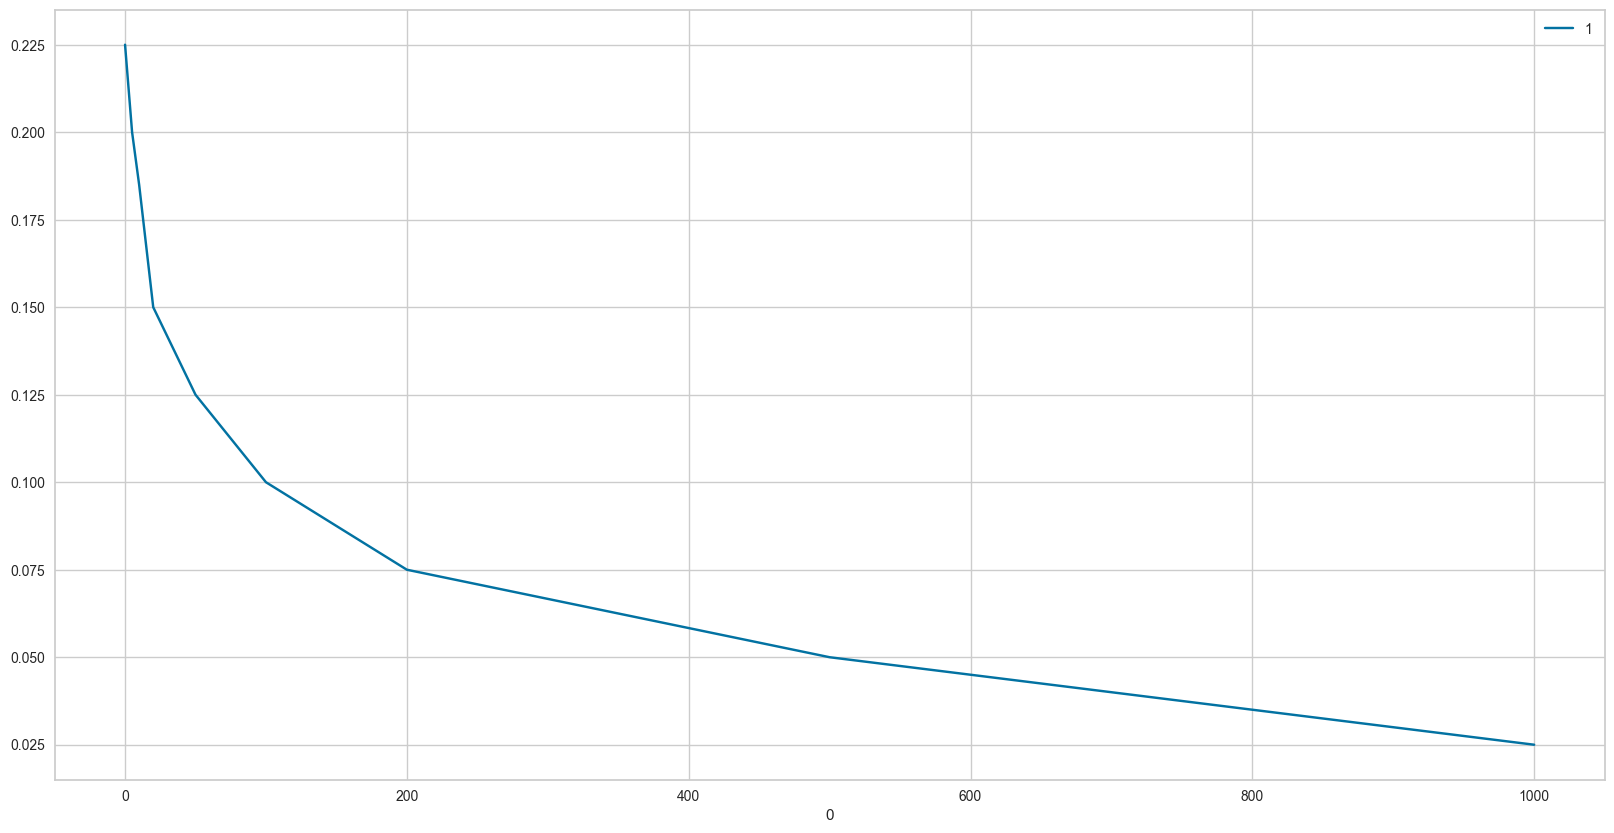

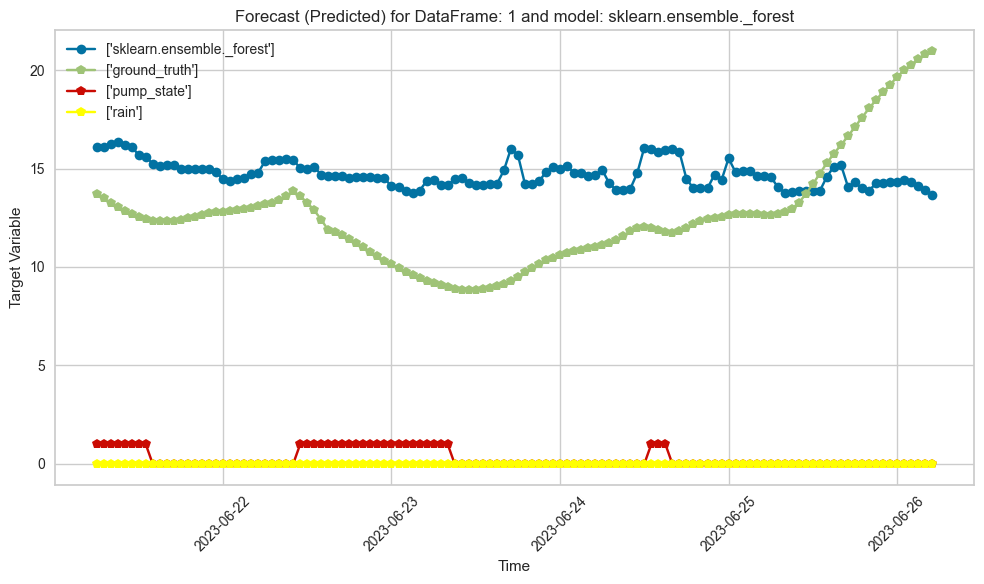

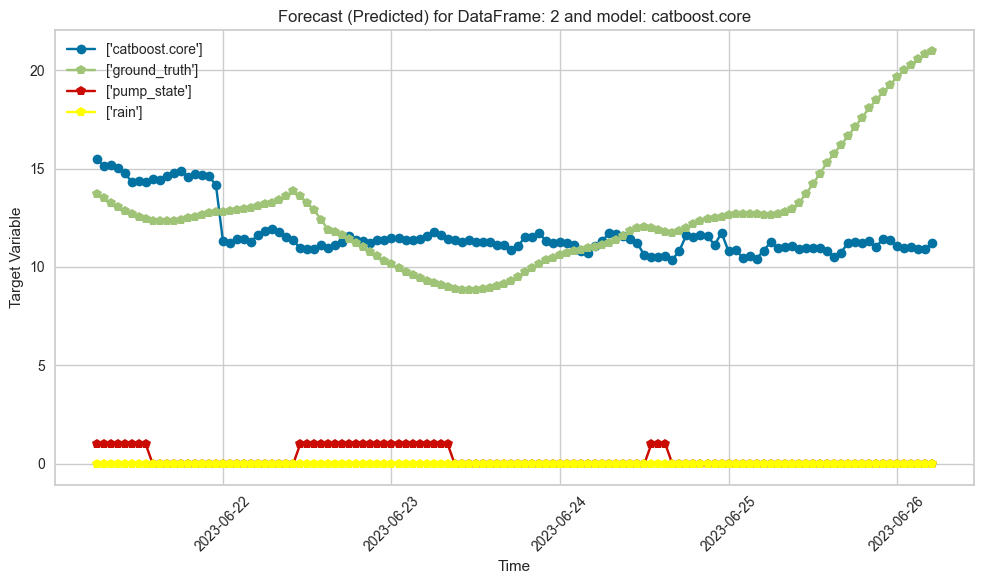

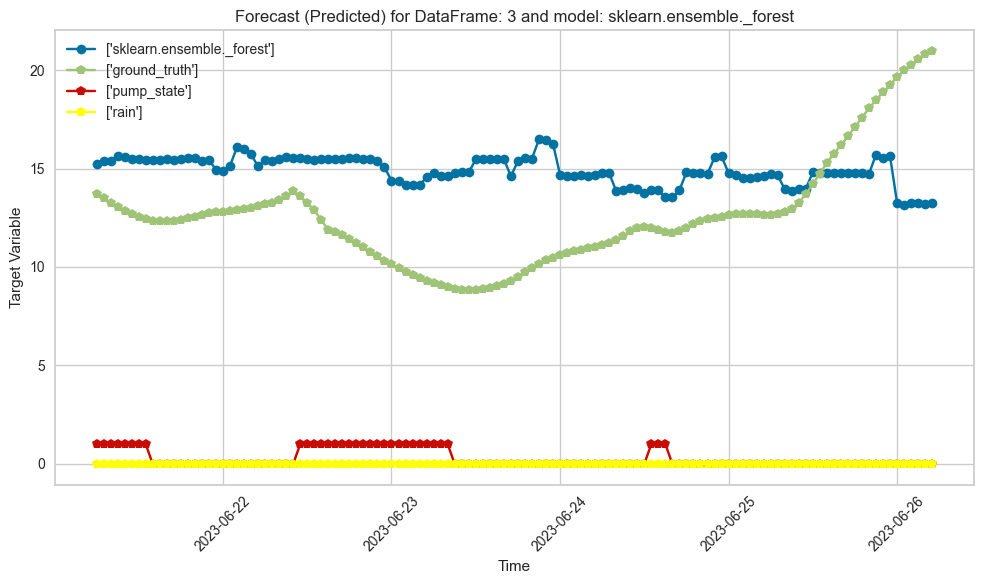

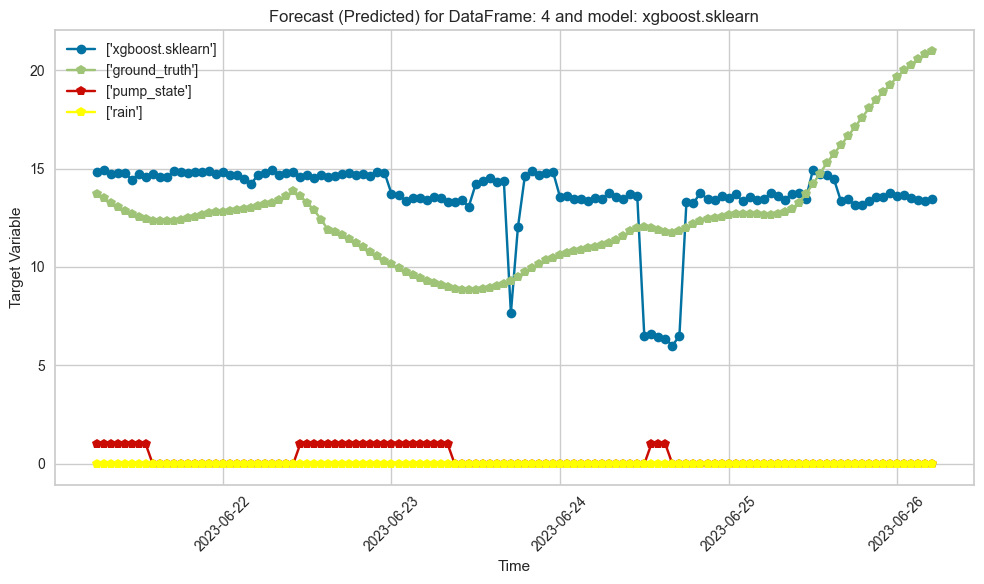

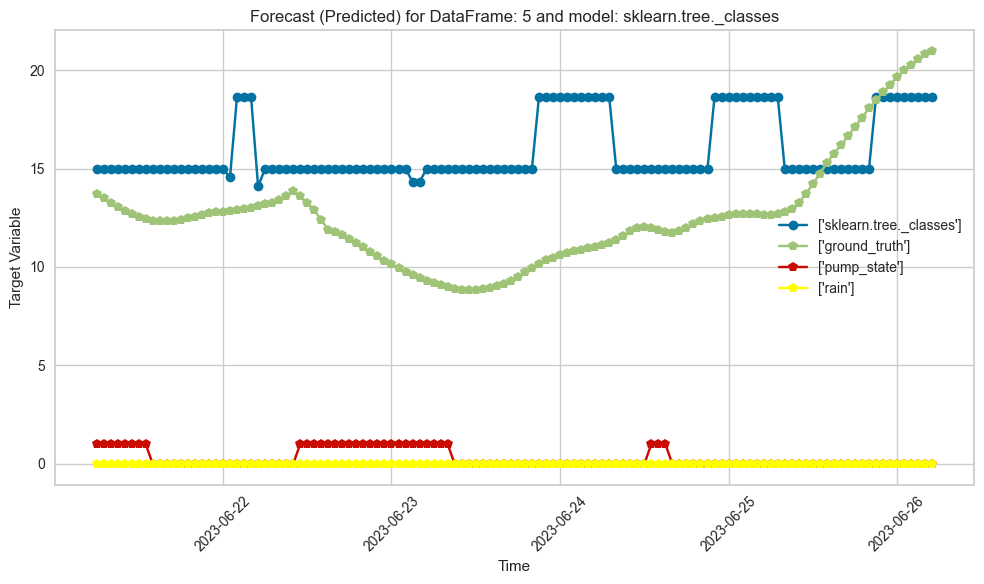

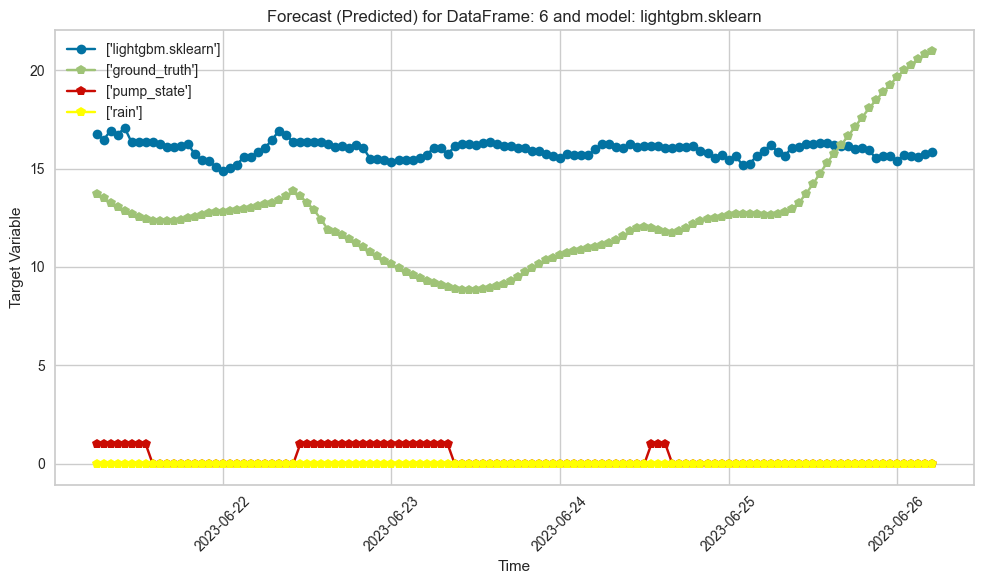

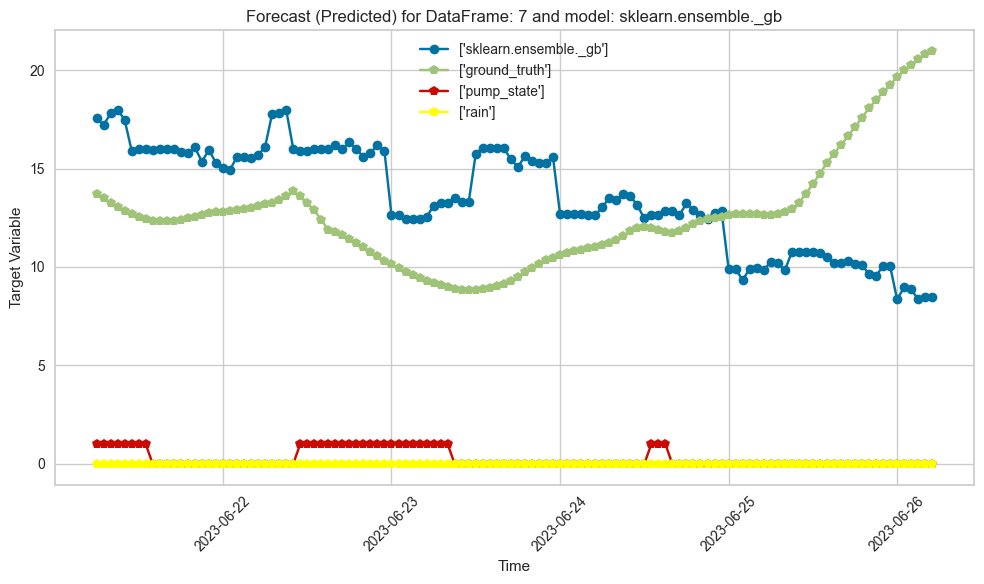

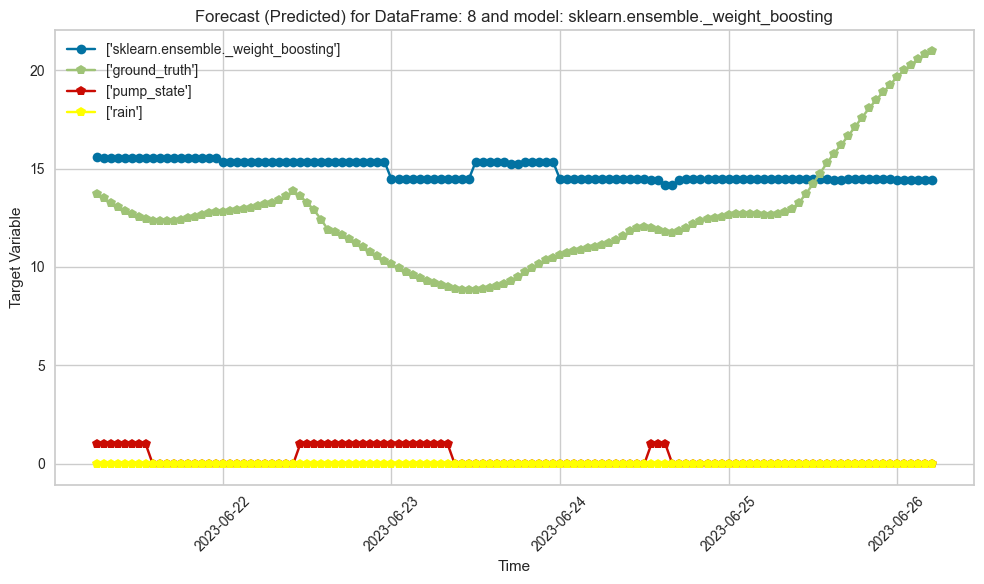

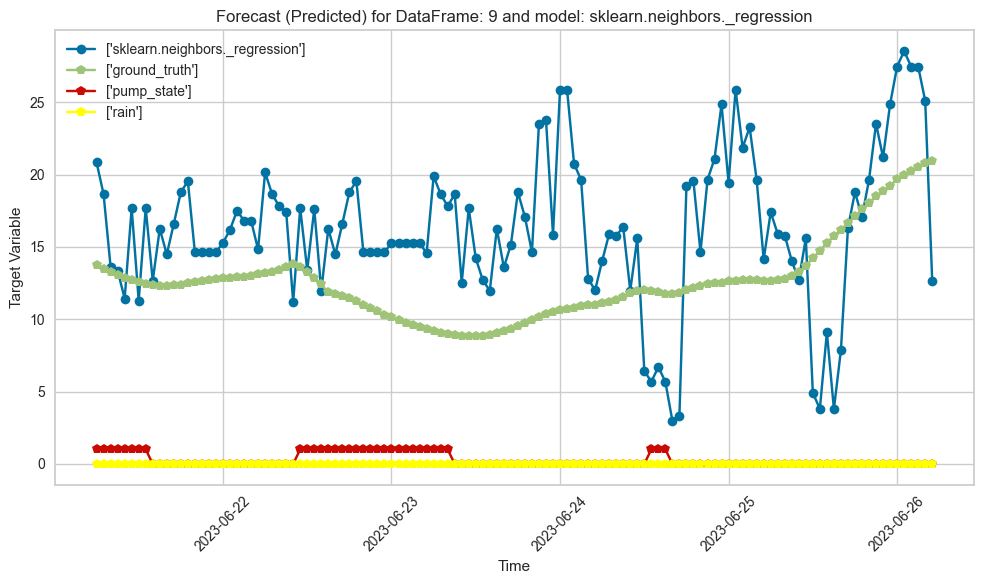

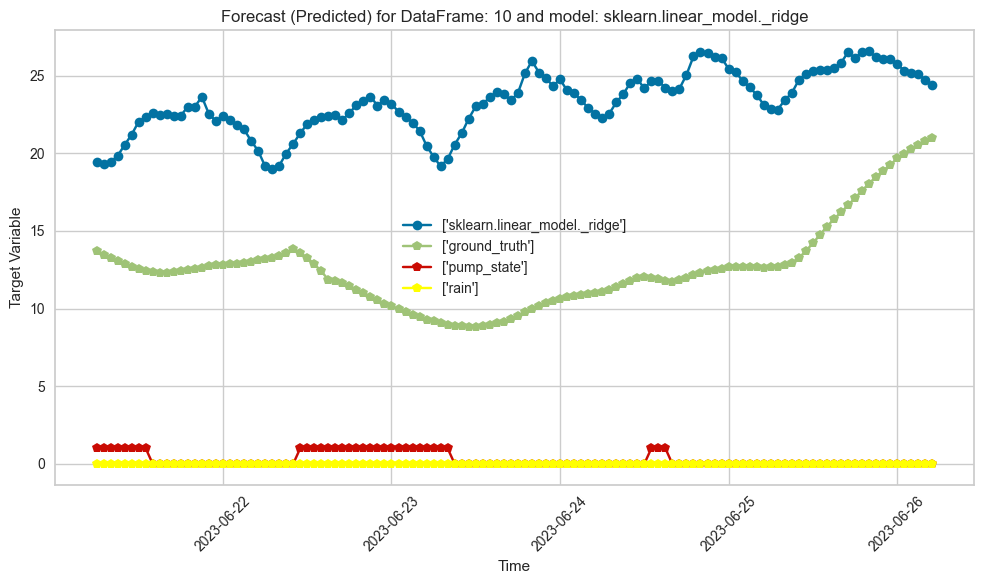

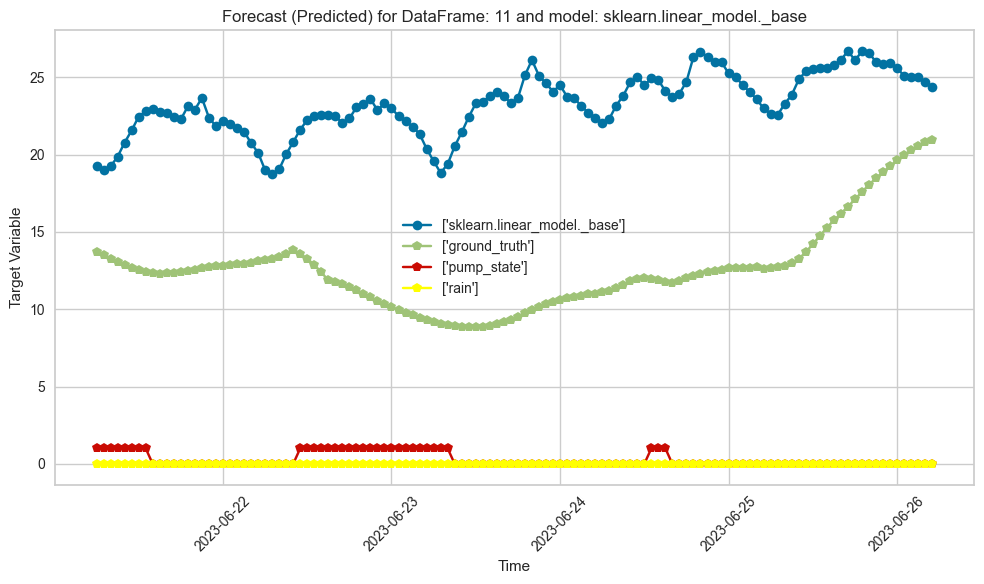

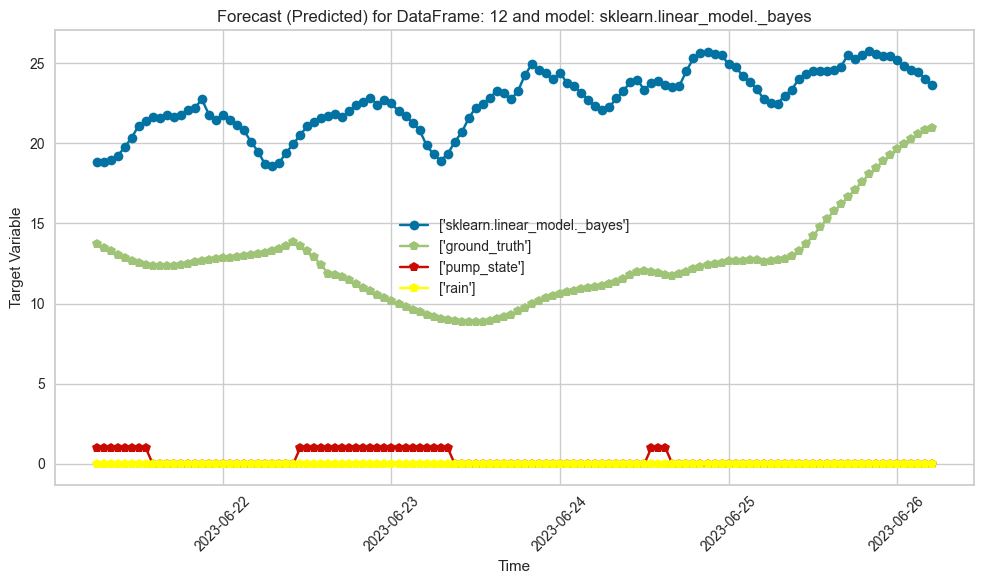

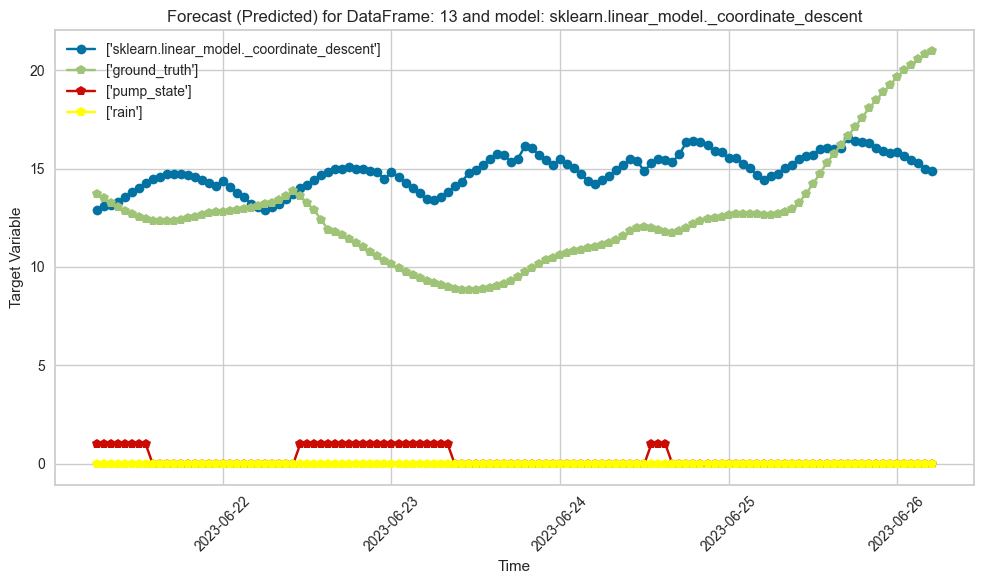

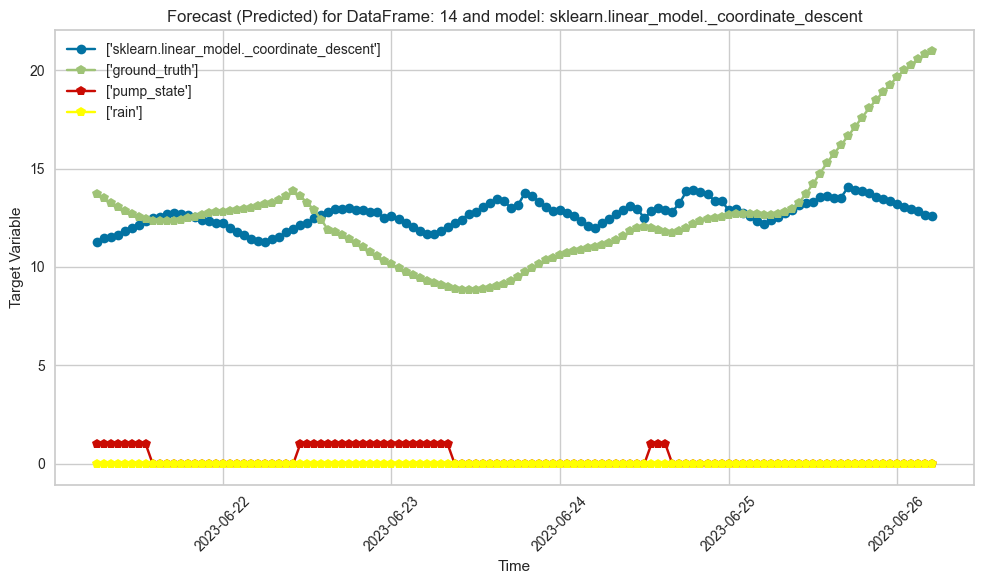

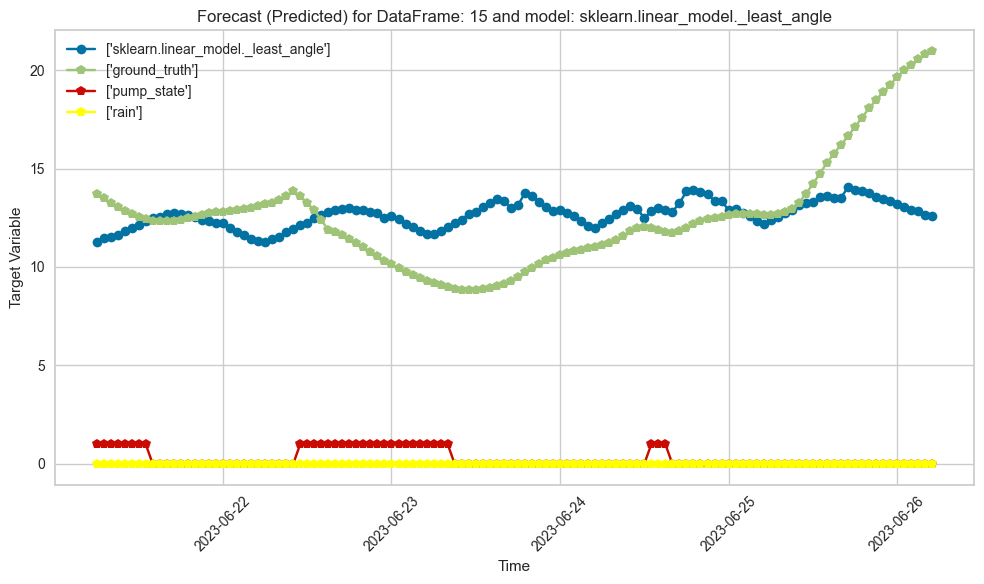

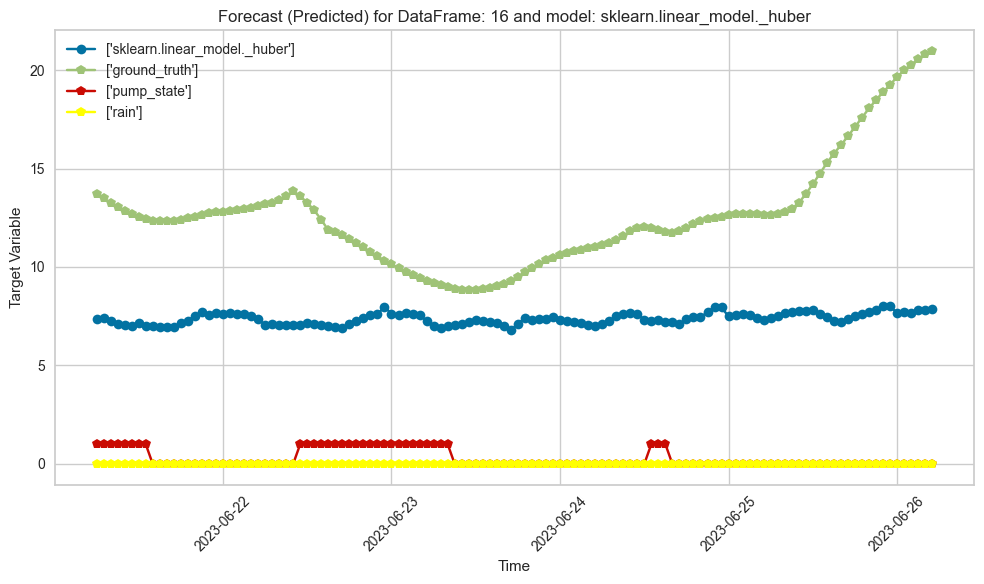

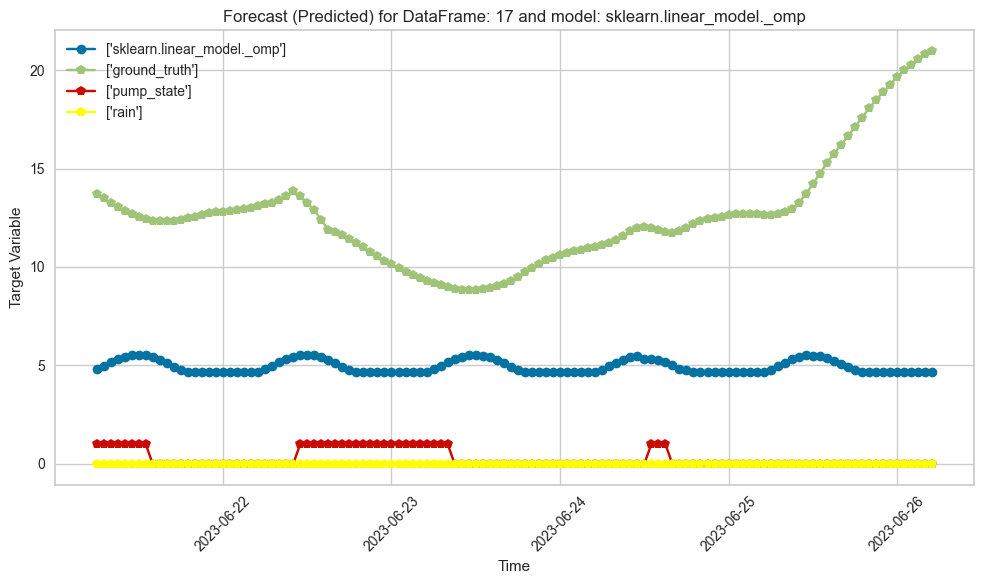

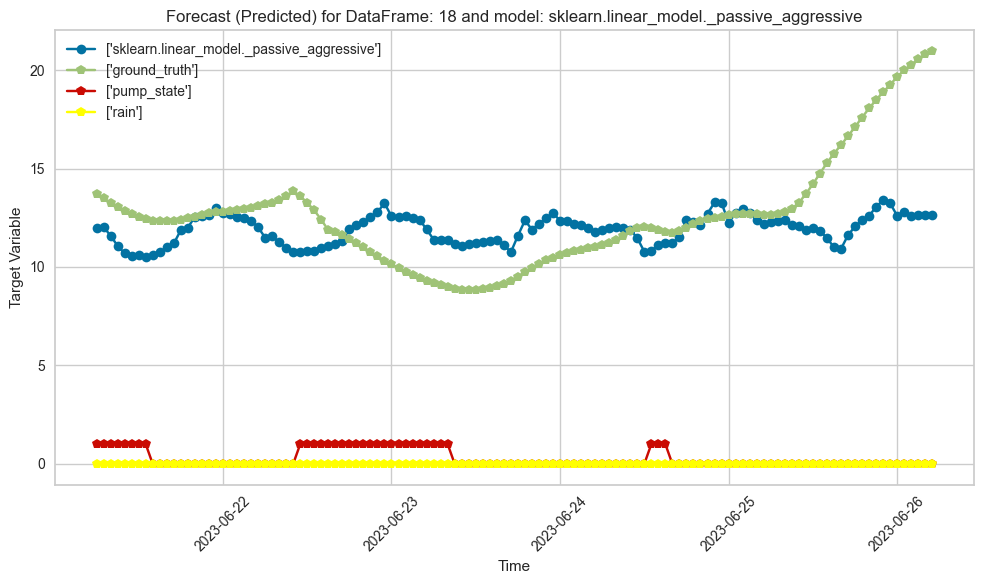

Timestamp
2023-06-21 06:00:00    16.111979
2023-06-21 07:00:00    16.095776
2023-06-21 08:00:00    16.243416
2023-06-21 09:00:00    16.371231
2023-06-21 10:00:00    16.196307
Name: prediction_label, dtype: float64
2023-06-21 06:00:00    13.713022
2023-06-21 07:00:00    13.477712
2023-06-21 08:00:00    13.252114
2023-06-21 09:00:00    13.043822
2023-06-21 10:00:00    12.849117
Freq: 60T, Name: rolling_mean_grouped_soil, dtype: float64
CSV file "appended_results.csv" already exists.
sklearn.ensemble._forest
MAE: 3.26
RMSE: 3.61
MPE: 27.75 %
R2 -0.69 

catboost.core
MAE: 2.33
RMSE: 3.21
MPE: 16.95 %
R2 -0.35 

sklearn.ensemble._forest
MAE: 3.42
RMSE: 3.84
MPE: 29.34 %
R2 -0.92 

xgboost.sklearn
MAE: 2.92
RMSE: 3.42
MPE: 24.39 %
R2 -0.52 

sklearn.tree._classes
MAE: 3.77
RMSE: 4.35
MPE: 33.59 %
R2 -1.47 

lightgbm.sklearn
MAE: 4.10
RMSE: 4.40
MPE: 35.84 %
R2 -1.52 

sklearn.ensemble._gb
MAE: 4.03
RMSE: 4.80
MPE: 31.83 %
R2 -2.00 

sklearn.ensemble._weight_boosting
MAE: 3.37
RMSE: 3.71
MPE:

ValueError: 24 missing values found in the target column: rolling_mean_grouped_soil. To proceed, remove the respective rows from the data. 

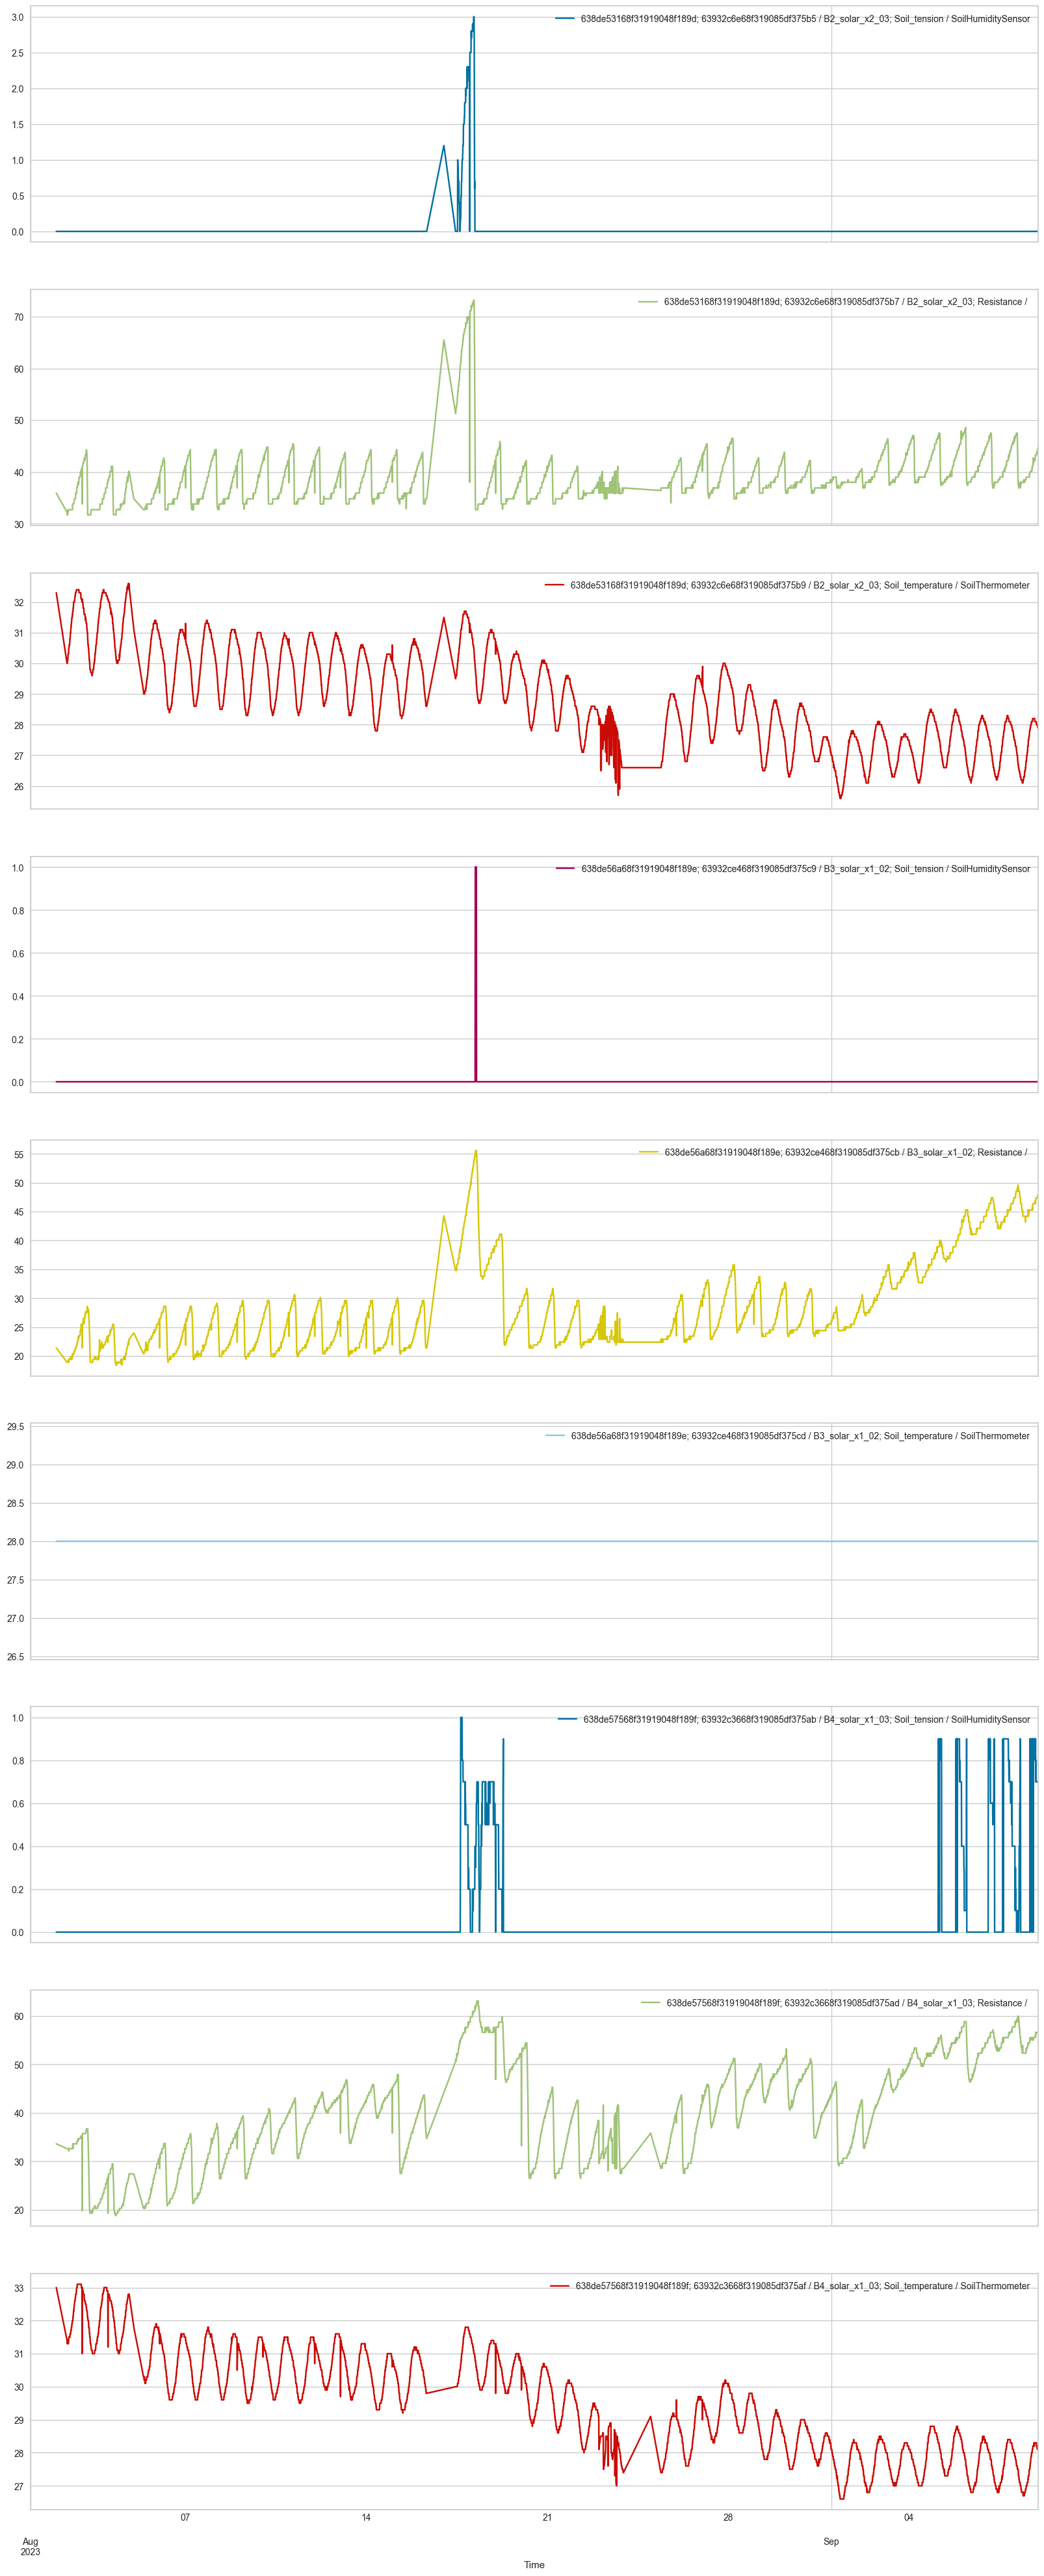

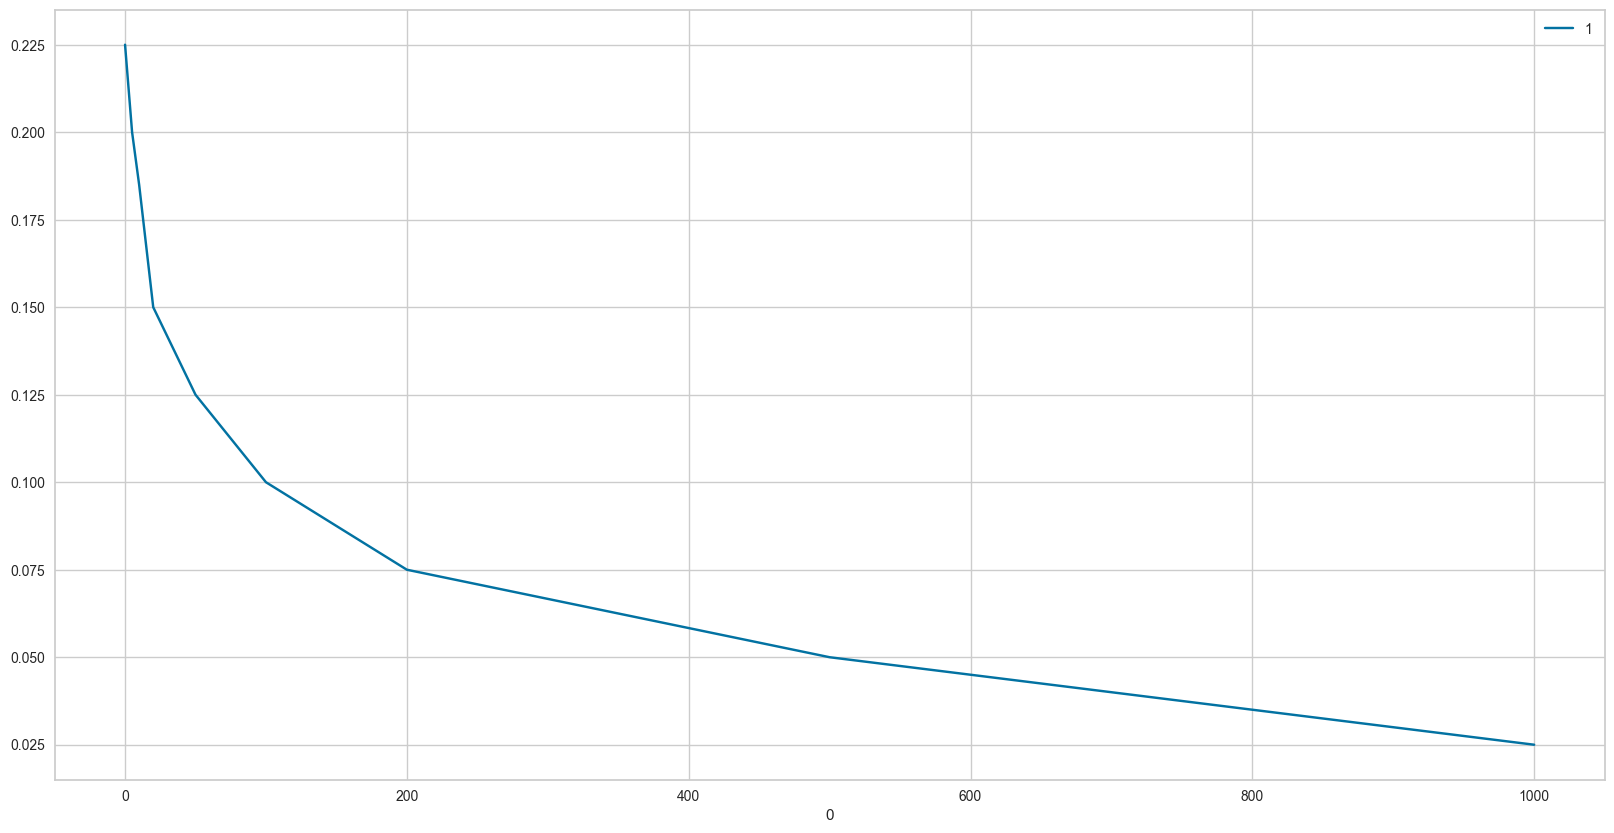

In [2]:
import random
from datetime import datetime, timedelta

def generate_random_timespans(start_date, end_date, num_timespans):
    timespans = []
    min_timespan_length = timedelta(days=30)  # Minimum length of one month

    # Convert start_date and end_date to datetime objects
    start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
    end_datetime = datetime.strptime(end_date, '%Y-%m-%d')

    for _ in range(num_timespans):
        # Generate a random start date within the specified range
        random_start = random.randint(0, (end_datetime - start_datetime).days)
        start_of_timespan = start_datetime + timedelta(days=random_start)

        # Calculate the maximum possible end day
        max_end_day = (end_datetime - start_of_timespan).days

        # Generate a random end date that ensures the timespan is at least one month long
        if max_end_day >= 30:
            random_end = random.randint(random_start + 30, random_start + max(30, max_end_day))
            end_of_timespan = start_datetime + timedelta(days=random_end)
            timespans.append((start_of_timespan.strftime('%Y-%m-%d'), end_of_timespan.strftime('%Y-%m-%d')))

    return timespans

# Example usage:
start_date = '2023-03-24'
end_date = '2023-09-15'
num_timespans = 25

random_timespans = generate_random_timespans(start_date, end_date, num_timespans)
for i, timespan in enumerate(random_timespans, start=1):
    print(f"Timespan {i}: {timespan[0]} to {timespan[1]}")
    run_pipeline('binned_removed-2024.csv', timespan[0], timespan[1])

In [ ]:
import os
# evaluate performance of prediction against test part of data
def evaluate_target_variable(model, series1, series2):
    # drop missing
    values1 = series1.dropna()
    values2 = series2.dropna()

    # calc max length
    min_length = min(len(values1), len(values2))
    values1 = values1[:min_length]
    values2 = values2[:min_length]

    # test print
    #print(values1)
    #print(values2)
    
    # MAE, RMSE, MPE
    diff = np.abs(values1.values - values2.values)
    mae = np.mean(diff)
    rmse = np.sqrt(np.mean(diff ** 2))
    mpe = np.mean(diff / values1.values) * 100

    # R2
    mean_series1 = np.mean(series1)
    ss_total = np.sum((series1 - mean_series1) ** 2)
    ss_residual = np.sum((series1 - series2) ** 2)
    r2_score = 1 - (ss_residual / ss_total)

    # print metrics
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MPE: {mpe:.2f} %")
    print(f"R2 {r2_score:.2f}",'\n')
    #print("df1 len:",len(values1),"df2 len:",len(values2),'\n')

    return pd.Series({#'Dataset / Timespan': source_filename + " / " + str(train.index[0]) + " - " + str(train.index[-1]), 
                      'MAE': str(mae), 
                      'RMSE':str(rmse), 
                      'MPE': str(mpe),
                      'R2': str(r2_score)
                     })

file_path = 'appended_results.csv'
existing_data = pd.DataFrame()

# Check if the file exists
if not os.path.isfile(file_path):
    # Create an empty DataFrame
    table_head = []
    table_head.append('Dataset / Timespan')

    for i in range(len(best_re)):
        table_head.append(best_re[i].__module__)

    print(table_head)
    existing_data = pd.DataFrame(columns=[table_head])
    # Save the empty DataFrame to a CSV file
    existing_data.to_csv(file_path, index=False)
    print(f'CSV file "{file_path}" created successfully.')
else:
    print(f'CSV file "{file_path}" already exists.')
    existing_data = pd.read_csv(file_path)

# Find the index of the first row where the specific column is empty
len_existing_data = len(existing_data)
existing_data.at[len_existing_data, 'Dataset / Timespan'] = source_filename + " / " + str(train.index[0]) + " - " + str(train.index[-1])

#print(existing_data.head())
for i in range(len(best_re)):
    print(best_re[i].__module__)
    row = evaluate_target_variable(best_re[i].__module__, test['rolling_mean_grouped_soil'], predictions[i]['prediction_label'])
    existing_data.at[len_existing_data, best_re[i].__module__]  = str(row)

# Save the updated DataFrame to a CSV file
existing_data.to_csv(file_path, index=False)
print(f'Results appended to "{file_path}" successfully.')

In [ ]:
predictions_df = pd.DataFrame(predictions[len(predictions)-1])

In [ ]:
predictions_df.rename(columns={'rolling_mean_grouped_soil_vol': 'open_meteo_prediction_vol'}, inplace=True)
testitest = add_volumetric_col_to_df(predictions_df, 'prediction_label',soil_water_retention_curve2)
testitest.head()

In [ ]:
# comparing predictions to forecast might be not expressive:
print("mean_predictions_vol: ", predictions_df["prediction_label_vol"].mean(), " mean_open_meteo_prediction_vol: ", predictions_df["open_meteo_prediction_vol"].mean())

### Notes:
Catboost seems to be the most promising, use it..

With normalization the metrics are better, but the curve is not represented in a articulated way.

## Analyze Model

You can use the `plot_model` function to analyzes the performance of a trained model on the test set. It may require re-training the model in certain cases.

In [ ]:
# plot forecast
exp.plot_model(best, plot = 'forecast')

In [ ]:
# plot forecast for 36 months in future
exp.plot_model(best, plot = 'forecast', data_kwargs = {'fh' : 240})

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

X = data_re.drop(['rolling_mean_grouped_soil', 'minute', 'grouped_soil', 'grouped_resistance', 'grouped_soil_temp', 'gradient', 'Timestamp'],axis=1)
y = data_re['rolling_mean_grouped_soil']

# Assuming you have already trained the XGBoost model
xgboost_model = xgb.XGBRegressor()
xgboost_model.fit(X, y)  # Replace X and y with your training data

# Plot feature importance
xgb.plot_importance(xgboost_model)
plt.show()

An alternate to `plot_model` function is `evaluate_model`. It can only be used in Notebook since it uses ipywidget.

## Prediction
The `predict_model` function returns `y_pred`. When data is `None` (default), it uses `fh` as defined during the `setup` function. 

In [ ]:
# predict on test set
holdout_pred = []
for i in range(len(best)):
    holdout_pred.append(exp.predict_model(best[i], fh = 240)) # 5 (days) * 2 (readings per hour) * 24 (hours) = 240 (readings in five days)

In [ ]:
# show predictions df
for i in range(len(holdout_pred)):
    print("Model: " + str(i+1))
    print(holdout_pred[i].head(100))
    print(holdout_pred[i].tail(100))

In [ ]:
len(holdout_pred[len(holdout_pred)-1]) # same as forecast_horizon!!!

In [ ]:
was_reached = False
last_df = holdout_pred[len(holdout_pred)-1]
last_df_len = len(last_df) # same as forecast horizon

# calculate 
for i in range(last_df_len):
    if last_df['y_pred'][i] > tension_threshold:
        print("Threshold will be reached on", last_df.index[i], "With a value of:", last_df['y_pred'][i])
        was_reached = True
        break
    if was_reached == False and last_df_len-1 == i:
        print("Threshold is not expected to reached in the coming 5 days!")
        break

## Save Model

Finally, you can save the entire pipeline on disk for later use, using pycaret's `save_model` function.

In [ ]:
# save pipeline
for i in range(len(best)):
    exp.save_model(best[i], 'all_in_one' + str(i))

In [ ]:
# load pipeline
loaded_best_pipeline = []
for i in range(len(best)): # TODO: exp will not work if it is not set before, use OS later
    loaded_best_pipeline.append(load_model('my_weather_SPLIT_pipeline_TS_' + str(i)))
    loaded_best_pipeline

# 👇 Detailed function-by-function overview

## ✅ Setup
This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function in PyCaret. `Setup` has only one required parameter i.e. `data`. All the other parameters are optional.

To access all the variables created by the setup function such as transformed dataset, random_state, etc. you can use `get_config` method.

In [ ]:
# check all available config
print(dir(exp.get_config()))
#exp[0].get_config('memory')

In [ ]:
# lets access y_train_transformed
print(exp.get_config('y_train_transformed'))
print(exp.get_config('X_train'))

In [ ]:
# another example: let's access seed
#print("The current seed is: {}".format(exp[0].get_config('seed')))

# now lets change it using set_config
#set_config('seed', 786)
#print("The new seed is: {}".format(get_config('seed')))

All the preprocessing configurations and experiment settings/parameters are passed into the `setup` function. To see all available parameters, check the docstring:

In [ ]:
# help(setup)

## ✅  Check Stats
The `check_stats` function is used to get summary statistics and run statistical tests on the original data or model residuals.

In [ ]:
# check stats on original data, swap index of exp to see stats-> otherwise use print->ugly
exp.check_stats()

## ✅ Tune Model

The `tune_model` function tunes the hyperparameters of the model. The output of this function is a scoring grid with cross-validated scores by fold. The best model is selected based on the metric defined in optimize parameter. Metrics evaluated during cross-validation can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

In [ ]:
# train a dt model with default params
#dt = create_model('dt_cds_dt')
for i in range(len(best)):
    print("Model: ", i+1)
    print(best[i])

In [ ]:
best[0].__module__

In [ ]:
# tune hyperparameters of best without grid
def tune_all_without_grid(best):
    tuned_best_models_array = []
    for j in range(len(exp)):
        tuned_best_models = []
        for i in range(len(best[j])):
            if re.search(r"^pycaret", best[j][i].__module__):
                print("This is for DataFrame", j+1, "This is for the",i+1,".best model:",best[j][i])
                tuned_best_models.append(exp[j].tune_model(best[j][i])) #TODO: Problem: not all estimators allow tuning without grid
            else:
                print("Cannot tune without grid:",best[j][i])
        tuned_best_models_array.append(tuned_best_models)
    return tuned_best_models_array
        
tuned_best_models_array = tune_all_without_grid(best)

Metric to optimize can be defined in `optimize` parameter (default = 'MASE'). Also, a custom tuned grid can be passed with `custom_grid` parameter. 

In [ ]:
len(tuned_best_models_array)

In [ ]:
for j in range(len(tuned_best_models_array)):
    print("Dataset: ",j+1,"\n------------")
    for i in range(len(tuned_best_models_array[j])):
        print(i+1,". :",tuned_best_models_array[j][i])

In [ ]:
current = best[0][0]
print(str(current.regressor), type(str(current.regressor)))
print(current.get_params().keys())
print(type(current).__name__)
print(type(current).__name__.split('.')[-1])
print(exp[0].models(internal = True).Name)

In [ ]:
for model in best[0]:
    column_reference = data.columns[0]
    print(model.__class__.__name__, column_reference)

In [ ]:
models = {'huber_cds_dt': 'HuberRegressor',
          'naive': 'NaiveBayes',
          'snaive': 'SeasonalNaiveBayes',
          'dt_cds_dt': 'DecisionTreeRegressor',
          'xgboost_cds_dt': 'XGBoostRegressor',
          'et_cds_dt': 'ExtraTreesRegressor',
          'lightgbm_cds_dt': 'LGBMRegressor',
          'gbr_cds_dt': 'GradientBoostingRegressor',
          'par_cds_dt': 'PassiveAggressiveRegressor',
          'ada_cds_dt': 'AdaBoostRegressor',
          'rf_cds_dt': 'RandomForestRegressor',
          'knn_cds_dt': 'KNeighborsRegressor',
          'catboost_cds_dt': 'catboost',
          'en_cds_dt': 'ElasticNet',
          'lasso_cds_dt': 'Lasso',
          'llar_cds_dt': 'LassoLars',
          'xgboost_cds_dt': 'XGBRegressor' 
}

models_dict = {v: k for k, v in models.items()}

print("Original dictionary:")
print(models)
print("\nSwapped dictionary:")
print(models_dict)

In [ ]:
# define tuning grid -> no grid for model defined, TODO: come back later
#grid = {'regressor__max_depth' : [None, 2, 4, 6, 8, 10, 12]}
#sp = {'regressor__max_depth' : [None, 2, 4, 6, 8, 10, 12]}
# define the custom grid
param_grid_linear = {
    'degree': [1, 2, 3],
    'deseasonal_model': ['multiplicative', 'additive'],
    #'fe_target_rr': [True, False],
    #'regressor__copy_X': [True, False],
    #'regressor__fit_intercept': [True, False],
    'regressor__n_jobs': [-1, 1, 2],
    #'regressor__normalize': [True, False],
    'regressor__positive': [True, False],
    'sp': [1, 2, 3],
    'window_length': [10, 20, 30]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}

params_grid = {
    'naive_bayes': {
        'alpha': [0.1, 0.5, 1.0],
        'fit_prior': [True, False]
    },
    'linear_regression': {
        'fit_intercept': [True, False],
        'normalize': [True, False]
    },
    'ridge': {
        'alpha': [0.1, 0.5, 1.0],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'lasso': {
        'alpha': [0.1, 0.5, 1.0],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'selection': ['cyclic', 'random']
    },
    'elastic_net': {
        'alpha': [0.1, 0.5, 1.0],
        'l1_ratio': [0.1, 0.5, 0.9],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'selection': ['cyclic', 'random']
    },
    'knn': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [15, 20, 30, 40]
    },
    'decision_tree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'random_forest': {
        'n_estimators': [10, 50, 100],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'gradient_boosting': {
        'n_estimators': [10, 50, 100],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.5, 0.7, 1],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'support_vector': {
        'C': [0.1, 0.5, 1.0],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }
}

In [ ]:
# TODO: add content to the missing ones
params_grid_idNames = {
    'huber_cds_dt': {
        'regressor__epsilon': [1.35, 1.5, 1.75],
        'regressor__max_iter': [100, 200, 300],
        'regressor__alpha': [0.0001, 0.001, 0.01],
        'regressor__warm_start': [True, False]
    },
    'naive': { #not used, adpot
        'estimator__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'snaive': { #not used, adpot
        'estimator__sp': [2, 3, 4, 5, 6],
        'estimator__window_length': [2, 3, 4, 5, 6],
        'alpha': [0.1, 0.5, 1.0],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'dt_cds_dt': {
        'regressor__ccp_alpha': [0.0, 0.1, 0.2],
        'regressor__criterion': ['poisson', 'friedman_mse', 'squared_error', 'absolute_error'],
        'regressor__max_depth': [None, 5, 10, 15, 20],
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__max_leaf_nodes': [None, 5, 10, 15, 20],
        'regressor__min_impurity_decrease': [0.0, 0.1, 0.2],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
        'regressor__random_state': [None, 123],
        'regressor__splitter': ['best', 'random'],
        'degree': [1, 2, 3],
        'deseasonal_model': ['multiplicative', 'additive'],
        'sp': [1, 2, 3],
        'window_length': [2, 3, 4],
    },
#    'xgboost_cds_dt': {
#        'alpha': [0.1, 0.5, 1.0],
#        'l1_ratio': [0.1, 0.5, 0.9],
#        'fit_intercept': [True, False],
#        'normalize': [True, False],
#        'selection': ['cyclic', 'random']
#    },
    'et_cds_dt': {
        'regressor__n_estimators': [10, 50, 100],
        'regressor__criterion': ['poisson', 'friedman_mse', 'squared_error', 'absolute_error'],
        'regressor__max_depth': [None, 5, 10, 20],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__bootstrap': [True, False]
    },
    'lightgbm_cds_dt': {
        'regressor__learning_rate': [0.01, 0.1, 0.3],
        'regressor__n_estimators': [50, 100, 150],
        'regressor__max_depth': [3, 5, 7],
        'regressor__num_leaves': [10, 20, 30],
        'regressor__min_child_samples': [1, 5, 10],
        'regressor__subsample': [0.5, 0.7, 0.9],
        'regressor__colsample_bytree': [0.5, 0.7, 0.9],
        'regressor__reg_alpha': [0, 0.1, 0.5, 1],
        'regressor__reg_lambda': [0, 0.1, 0.5, 1],
        'regressor__min_split_gain': [0, 0.1, 0.5],
        'regressor__max_bin': [100, 200, 300]
    },
    'gbr_cds_dt': {
        'regressor__n_estimators': [50, 100, 150],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.01, 0.1, 0.3],
        'regressor__subsample': [0.5, 0.7, 0.9],
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__alpha': [0.1, 0.3, 0.5],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__max_leaf_nodes': [None, 5, 10, 20]
    },
    'par_cds_dt': { #not used, adpot
        'C': [0.1, 1, 10],
        'fit_intercept': [True, False],
        'max_iter': [1000, 2000, 3000],
        'tol': [1e-3, 1e-4, 1e-5],
        'early_stopping': [True, False],
        'validation_fraction': [0.1, 0.2, 0.3],
        'n_iter_no_change': [5, 10, 15],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']

    },
    'ada_cds_dt': {#Valid parameters are: ['base_estimator', 'estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'].
        #'regressor__base_estimator': ['None'],
        'regressor__n_estimators': [10, 50, 100],
        'regressor__learning_rate': [0.01, 0.1, 1],
        'regressor__loss': ['linear', 'square', 'exponential'],
        'regressor__random_state': [123],
        'regressor__base_estimator': [None]
    },
    'rf_cds_dt': {
        'regressor__ccp_alpha': [0.0, 0.1, 0.2],
        'regressor__criterion': ['poisson', 'friedman_mse', 'squared_error', 'absolute_error'],
        'regressor__max_depth': [None, 5, 10, 15, 20],
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__max_leaf_nodes': [None, 5, 10, 15, 20],
        'regressor__min_impurity_decrease': [0.0, 0.1, 0.2],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
        'regressor__random_state': [None, 123],
    },
    'knn_cds_dt': { #not used, adpot
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [15, 20, 30, 40]
    },
    'catboost_cds_dt': {
        'regressor__iterations': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.5],
        'regressor__depth': [4, 6, 8],
        'regressor__l2_leaf_reg': [1, 3, 5],
        'regressor__subsample': [0.5, 0.7, 1],
        'regressor__random_strength': [0.1, 0.5, 1],
        'regressor__eval_metric': ['RMSE', 'MAE', 'Poisson'],
        'regressor__iterations': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.5],
        'regressor__depth': [4, 6, 8],
        'regressor__l2_leaf_reg': [1, 3, 5],
        'regressor__subsample': [0.5, 0.7, 1],
        'regressor__random_strength': [0.1, 0.5, 1],
    },
    'en_cds_dt': { #not used, adpot
        'n_estimators': [10, 50, 100],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.5, 0.7, 1],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'lasso_cds_dt': { #not used, adpot
        'C': [0.1, 0.5, 1.0],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    },
    'llar_cds_dt': { #not used, adpot
        'n_estimators': [10, 50, 100],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'xgboost_cds_dt': {
        'regressor__learning_rate': [0.01, 0.1, 0.3],
        'regressor__n_estimators': [50, 100, 150],
        'regressor__max_depth': [3, 5, 7],
        'regressor__subsample': [0.5, 0.7, 0.9],
        'regressor__colsample_bytree': [0.5, 0.7, 0.9],
        'regressor__gamma': [0, 0.1, 0.5],
        'regressor__min_child_weight': [1, 5, 10],
        'regressor__reg_alpha': [0, 0.1, 0.5, 1],
        'regressor__reg_lambda': [0, 0.1, 0.5, 1],
        'regressor__max_delta_step': [0, 1, 2],
        'regressor__scale_pos_weight': [1, 2, 5]
    },
    'par_cds_dt': {
        'regressor__C': [0.1, 1, 10],
        'regressor__fit_intercept': [True, False],
        'regressor__max_iter': [1000, 2000, 3000],
        'regressor__tol': [1e-3, 1e-4, 1e-5],
        'regressor__early_stopping': [True, False],
        'regressor__validation_fraction': [0.1, 0.2, 0.3],
        'regressor__n_iter_no_change': [5, 10, 15]
    },
}

In [ ]:
#print( str(best[1][1].regressor))
match = re.match(r'<([A-Za-z]+)', str(best[1][6].regressor))
if match:
    print(match.group(1))


In [ ]:
# tune model with custom grid and metric = MAE
tuned_best_models_grid_all = []
for i in range(len(exp)):
    tuned_best_models_grid_exp = []
    print("This is for Dataset number: ",i+1)
    if i<0:
        print("...skipped Dataset!!!!")
        continue 
    for j in range(len(best[i])):
        print("This is for the",j+1,". best model:",best[i][j])
        if j<0:
            print("...skipped!!!!")
            tuned_best_models_grid_exp.append(best[i][j])
            continue
        if re.match(r'<([A-Za-z]+)', str(best[i][j].regressor)): # For Catboost
            tuned_best_models_grid_exp.append(
                exp[i].tune_model(
                    best[i][j], 
                    custom_grid = params_grid_idNames[
                        models_dict[re.search(r"([A-Za-z]+)", str(best[i][j].regressor)).group(1)]
                    ], 
                    choose_better = True)
            )
        else:
            tuned_best_models_grid_exp.append(
                exp[i].tune_model(
                    best[i][j], 
                    custom_grid = params_grid_idNames[
                        models_dict[re.match(r"([A-Za-z]+)", str(best[i][j].regressor)).group(0)]
                    ], 
                    choose_better = True)
            )
        print("Done!!!!")
        
        
#        if str(best[i][j].regressor) == "LinearRegression(n_jobs=-1)":
#            tuned_best_models_grid_exp.append(exp[i].tune_model(best[i][j], custom_grid = param_grid_linear, optimize = 'MAE'))
#        elif str(best[i][j].regressor) == "KNeighborsRegressor(n_jobs=-1)":
#            tuned_best_models_grid_exp.append(exp[i].tune_model(best[i][j], custom_grid = param_grid_knn, optimize = 'MAE'))
    tuned_best_models_grid_all.append(tuned_best_models_grid_exp)

In [ ]:
len(tuned_best_models_grid_all[0])

In [ ]:
# see tuned_dt params
for i in range(len(tuned_best_models_grid_all)):
    print("Dataset :", i+1)
    for j in range(len(tuned_best_models_grid_all[i])):
        print(j+1, ". best model:", tuned_best_models_grid_all[i][j])

In [ ]:
# to access the tuner object you can set return_tuner = True
tuners = []
tuned_best_models_tuner = []

for i in range(len(best)):
    tuned_model, tuner = exp[i].tune_model(best[i][0], custom_grid = params_grid_idNames, return_tuner=True) #tuned_best_models_grid[i] does not work
    tuned_best_models_tuner.append(tuned_model)
    tuners.append(tuner)    

In [ ]:
# model object
for i in range(len(tuned_best_models_tuner)):
    tuned_best_models_tuner[i]

In [ ]:
# tuner object
for i in range(len(tuner)):
    tuner[i]

For more details on all available `search_library` and `search_algorithm` please check the docstring. Some other parameters that you might find very useful in `tune_model` are:

- choose_better
- custom_scorer
- n_iter
- search_algorithm
- optimize

You can check the docstring of the function for more info.

In [ ]:
# help(tune_model)

In [ ]:
# plot forecast
for i in range(len(exp)):
    exp[i].plot_model(tuned_best_models_grid_all[i], plot = 'forecast')
  

In [ ]:
# Extract features using tsfresh
extracted_features = extract_features(cut_sub_dfs[0], column_id="Symbol", column_sort="Datetime")

# Handle missing values
impute(extracted_features)

# Select relevant features
selected_features = select_features(extracted_features, data['Class'])

# Create a model and train it
model = create_model('lightgbm', data=selected_features, cross_validation=False)

# Split the data into features (X) and target variable (y)
X = selected_features.drop('Class', axis=1)
y = selected_features['Class']

# Evaluate the model on the forecasting horizon (fh)
predictions = predict_model(model, data=X, forecast_horizon=y)

# Evaluate the predictions against the actual target variable
evaluate_model(predictions, forecast_horizon=y)

# ✅ Ensemble Models
## ✅ Blend Models

This function trains a `EnsembleForecaster` for select models passed in the estimator_list parameter. The output of this function is a scoring grid with CV scores by fold. Metrics evaluated during CV can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

In [ ]:
# top 3 models based on mae
for i in range(len(best)):
    print(best[i])

In [ ]:
# minimal working example
blended_model = exp.blend_models(estimator_list=[best[0],best[1],best[2],best[3]])

In [ ]:
# blend top model of every dataset
blended_model = []
best_models = []

for i in range(len(exp)):
    best_models.append(tuned_best_models_grid_all[i][0])
print(best_models)
blended_model = exp[0].blend_models(estimator_list=best_models, choose_better=True, method='voting', weights=[0.5, 0.3, 0.2], verbose=True)



#best_models = [dataset[0] for dataset in tuned_best_models_grid_all]
#print(best_models)
#for i in range(len(best_models)):
#    blended_model = exp[blend_models(estimator_list=best_models[i])

#for i in range(len(tuned_best_models_grid_all)):
#    print(tuned_best_models_grid_all[i][0])
#    blended_model = exp[i].blend_models(estimator_list=[tuned_best_models_grid_all[0][0],tuned_best_models_grid_all[0][1],tuned_best_models_grid_all[0][2]])

Some other parameters that you might find very useful in `blend_models` are:

- choose_better
- method
- weights
- fit_kwargs
- optimize

You can check the docstring of the function for more info.

In [ ]:
# plot forecast
exp[0].plot_model(blended_model, plot = 'forecast')

In [ ]:
print("Largest forecast_horizon (fh): \n","value :",int(exp[0].get_config('fh')[len(exp[0].get_config('fh'))-1])," type: ",type(int(exp[0].get_config('fh')[len(exp[0].get_config('fh'))-1])))

In [ ]:
refit_blended = blended_model.fit(exp[0].get_config('X_train'), exp[0].get_config('y_train'), fh=int(exp[0].get_config('fh')[len(exp[0].get_config('fh'))-1]))

In [ ]:
from sktime.forecasting.base._fh import ForecastingHorizon

refit_blended.fh[0]

new_fh_obj = ForecastingHorizon(refit_blended.fh[0])

In [ ]:
refit_blended.forecasters

In [ ]:
refit_blended.get_estimator_names()

In [ ]:
blended_model_new = refit_blended(estimators=refit_blended.forecasters, method='soft')
blended_model_new.set_params(fh=720)

In [ ]:
exp[0].plot_model(refit_blended, plot = 'forecast', data_kwargs = {'fh' : 48})

In [ ]:
len(cut_sub_dfs)

In [ ]:
forecasts = blended_model.forecast(data=cut_sub_dfs[2])

In [ ]:
# change forecast horizon
desired_forecast_horizon = 720
blended_model_trained = exp[0].finalize_model(blended_model, forecast_horizon=desired_forecast_horizon)

# plot forecast
exp[0].plot_model(blended_model_trained, plot = 'forecast',data_kwargs = {'fh' : desired_forecast_horizon})

In [ ]:
forecasts = exp[0].predict_model(blended_model)

In [ ]:
help(blend_models)

## ✅ Model Stacking
Model stacking is not available for a time series forecasting experiment!!!!!!!!!!!!!!!! Change pipeline to regression!

In [ ]:
# train a decision tree classifier as the meta-model
dt = DecisionTreeRegressor()
dt.fit(exp[0].get_config('X_train'), exp[0].get_config('y_train'))

In [ ]:
stacked_models = exp[0].stack_models(estimator_list=best_models, optimize='MAE', meta_model=dt)

## ✅ Plot Model

This function analyzes the performance of a trained model on the hold-out set. It may require re-training the model in certain cases.

In [ ]:
blended_model

In [ ]:
# extend forecast horizon

In [ ]:
# plot forecast
#for i in range(len(exp)):
#time_series_forecast()
blended_model.fit(exp.get_config('X_train'), exp.get_config('y_train'),fh=500)
exp.plot_model(blended_model, plot = 'forecast', data_kwargs = {'fh' : 500}) #exp[i].plot_model(best[i], plot = 'forecast', data_kwargs = {'fh' : 500})

In [ ]:
future_df = exp.predict_model(blended_model, fh=48)
print(future_df)

In [ ]:
start=data.index[0]
print("start: ", start)
train_end = train.index[len(train)-1]
print("train end before adding: ", train_end)
end=train_end+pd.Timedelta(days=5)
print("end after adding: ", end)
all_dates = pd.date_range(start=train_end, end=end, freq='30T') #end= cut_sub_dfs[1]['Time'][len(cut_sub_dfs[1])-1]
#print("Dataframe",i,":",all_dates[i])

In [ ]:
print(data.columns)

In [ ]:
data_weather_api_cut = data_weather_api.loc[train_end:end]
print("Length of data_weather_api_cut:",len(data_weather_api_cut))
print(data_weather_api_cut.head(1))
print(data_weather_api_cut.tail(1))
data_weather_api_cut.head(10)

In [ ]:
# create new data (only dates)

new_data = pd.DataFrame()

new_data.index = all_dates
new_data = pd.concat([new_data, data_weather_api_cut], axis=1)


new_data['hour'] = [i.hour for i in new_data.index]
# new_data['minute'] = [i.minute for i in new_data.index] #minute is not important
new_data['date'] = [i.day for i in new_data.index]
new_data['month'] = [i.month for i in new_data.index]
new_data['day_of_year'] = [i.dayofyear for i in new_data.index]
new_data['rolling_mean_grouped_soil_vol'] = new_data['Soil_moisture_0-7']
new_data['rolling_mean_grouped_soil_temp'] = new_data['Soil_temperature_7-28']
new_data['pump_state'] = test['pump_state'].iloc[:len(new_data)]
new_data['pump_state'][0] = 0 #omg I must be stupid, just a quick fix...
# new_data = add_volumetric_col_to_df(new_data,"Soil_moisture_0-7") # already volumetric


# TODO: add weather forecast 
print("Train end:", train_end , "Test start:",new_data.index[0], "Test end:", new_data.index[-1])
print(new_data.dtypes)
new_data.head(30)


In [ ]:
new_data['Soil_moisture_0-7'].plot()

In [ ]:
future_df = []
for i in range(len(best)):
    future_df.append(exp.predict_model(best[i], X=test.loc[train_end:].drop(['rolling_mean_grouped_soil','NumericalIndex','minute'],axis=1), fh=240))

In [ ]:
for i in range(len(best)):
    future_df[i].plot()

In [ ]:
print(test['rolling_mean_grouped_soil'].head())
print(future_df[0].head())

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

# Replace 'target_variable' with the name of your target variable
y_true = test['rolling_mean_grouped_soil']
y_pred = future_df

# Example evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

In [ ]:
# plot acf
# for certain plots you don't need a trained model
exp.plot_model(plot = 'acf')

In [ ]:
# plot diagnostics
# for certain plots you don't need a trained model
exp.plot_model(plot = 'diagnostics')

Some other parameters that you might find very useful in `plot_model` are:

- fig_kwargs
- data_kwargs
- display_format
- return_fig
- return_data
- save

You can check the docstring of the function for more info.

In [ ]:
# help(plot_model)

## ✅ Finalize Model
This function trains a given model on the entire dataset including the hold-out set.

In [ ]:
final_best = finalize_model(best) #TODO: for loop

In [ ]:
final_best

## ✅ Deploy Model
This function deploys the entire ML pipeline on the cloud.

**AWS:**  When deploying model on AWS S3, environment variables must be configured using the command-line interface. To configure AWS environment variables, type `aws configure` in terminal. The following information is required which can be generated using the Identity and Access Management (IAM) portal of your amazon console account:

- AWS Access Key ID
- AWS Secret Key Access
- Default Region Name (can be seen under Global settings on your AWS console)
- Default output format (must be left blank)

**GCP:** To deploy a model on Google Cloud Platform ('gcp'), the project must be created using the command-line or GCP console. Once the project is created, you must create a service account and download the service account key as a JSON file to set environment variables in your local environment. Learn more about it: https://cloud.google.com/docs/authentication/production

**Azure:** To deploy a model on Microsoft Azure ('azure'), environment variables for the connection string must be set in your local environment. Go to settings of storage account on Azure portal to access the connection string required.
AZURE_STORAGE_CONNECTION_STRING (required as environment variable)
Learn more about it: https://docs.microsoft.com/en-us/azure/storage/blobs/storage-quickstart-blobs-python?toc=%2Fpython%2Fazure%2FTOC.json

In [ ]:
# deploy model on aws s3
# deploy_model(best, model_name = 'my_first_platform_on_aws',
#             platform = 'aws', authentication = {'bucket' : 'pycaret-test'})

In [ ]:
# load model from aws s3
# loaded_from_aws = load_model(model_name = 'my_first_platform_on_aws', platform = 'aws',
#                              authentication = {'bucket' : 'pycaret-test'})

# loaded_from_aws

## ✅ Save / Load Model
This function saves the transformation pipeline and a trained model object into the current working directory as a pickle file for later use.

In [ ]:
# save model
for i in range(len(best_models)):
    save_model(best_models[i], 'my_first_SPLIT_model' + str(i))

In [ ]:
# load model
for i in range(len(best_models)): # will not work need to know how many models->use os TODO
    loaded_from_disk = load_model('my_first_SPILT_model'+str(i))
    loaded_from_disk

## ✅ Save / Load Experiment
This function saves all the experiment variables on disk, allowing to later resume without rerunning the setup function.

In [ ]:
# save experiment
save_experiment('my_SPLIT_experiment')

In [ ]:
# load experiment from disk
exp_from_disk = load_experiment('my_SPLIT_experiment', data=data)